# Часть 1 Бустинг (5 баллов)

В этой части будем предсказывать зарплату data scientist-ов в зависимости  от ряда факторов с помощью градиентного бустинга.

В датасете есть следующие признаки:



* work_year: The number of years of work experience in the field of data science.

* experience_level: The level of experience, such as Junior, Senior, or Lead.

* employment_type: The type of employment, such as Full-time or Contract.

* job_title: The specific job title or role, such as Data Analyst or Data Scientist.

* salary: The salary amount for the given job.

* salary_currency: The currency in which the salary is denoted.

* salary_in_usd: The equivalent salary amount converted to US dollars (USD) for comparison purposes.

* employee_residence: The country or region where the employee resides.

* remote_ratio: The percentage of remote work offered in the job.

* company_location: The location of the company or organization.

* company_size: The company's size is categorized as Small, Medium, or Large.

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving ds_salaries.csv to ds_salaries.csv


In [ ]:
import pandas as pd

df = pd.read_csv("ds_salaries.csv")
df.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


## Задание 1 (0.5 балла) Подготовка



*   Разделите выборку на train, val, test (80%, 10%, 10%)
*   Выдерите salary_in_usd в качестве таргета
*   Найдите и удалите признак, из-за которого возможен лик в данных


In [ ]:
from sklearn.model_selection import train_test_split
y = df['salary_in_usd']
X = df.drop('salary_in_usd', axis = 1)
X = X.drop('salary', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=152)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=152)



# -- YOUR CODE HERE --

## Задание 2 (0.5 балла) Линейная модель


*   Закодируйте категориальные  признаки с помощью OneHotEncoder
*   Обучите модель линейной регрессии
*   Оцените  качество через MAPE и RMSE


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import OneHotEncoder
import numpy as np

categorical_features = [col for col in X.columns if X[col].dtype == 'object']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)


x_train = np.concatenate((X_train.drop(categorical_features, axis=1),  encoder.fit_transform(X_train[categorical_features])), axis=1)
x_test = np.concatenate((X_test.drop(categorical_features, axis=1),  encoder.transform(X_test[categorical_features])), axis=1)
x_val = np.concatenate((X_val.drop(categorical_features, axis=1),  encoder.transform(X_val[categorical_features])), axis=1)

lr = LinearRegression()

# Обучение модели на кодированных данных
lr.fit(x_train, y_train)

# Прогнозирование на тестовых данных после их кодирования

y_pred = lr.predict(x_test)

# Вычисление метрик качества
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print('MAPE: ', mape)
print('RMSE: ', rmse)



MAPE:  47686154.25717852
RMSE:  5382573712016.831


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00


## Задание 3 (0.5 балла) XGboost

Начнем с библиотеки xgboost.

Обучите модель `XGBRegressor` на тех же данных, что линейную модель, подобрав оптимальные гиперпараметры (`max_depth, learning_rate, n_estimators, gamma`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:
from xgboost.sklearn import XGBRegressor
import numpy as np
import optuna
import time


def objective(trial):
      start_time = time.time()  # Начало отсчета времени
      param = {
      'max_depth' : trial.suggest_categorical('max_depth', [1, 2, 3, 4, 5, 7, 10]),
      'learning_rate' : trial.suggest_categorical('learning_rate', [0.1, 0.2, 0.5, 1]),
      'n_estimators' : trial.suggest_int('n_estimators', 10, 100, step=10),
      'gamma' : trial.suggest_categorical('gamma', [0.01, 0.2,0.5,0.7,0.1])

    }
      model = XGBRegressor(**param,random_state=152)



      pred = model.fit(x_train, y_train).predict(x_val)

      rmse = mean_squared_error(y_val, pred,squared=False)
      mape = mean_absolute_percentage_error(y_val, pred)

      return rmse, mape





study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

trials = study.best_trials



best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} RMSE, MAPE {best_trials[i].values}')




[I 2024-06-08 20:17:13,978] A new study created in memory with name: no-name-1d424bd6-65ee-488a-b6d8-566872a88a73
[I 2024-06-08 20:17:15,079] Trial 0 finished with values: [54347.80478206442, 0.4161457032443555] and parameters: {'max_depth': 1, 'learning_rate': 0.2, 'n_estimators': 50, 'gamma': 0.2}. 
[I 2024-06-08 20:17:15,342] Trial 1 finished with values: [52443.7884012409, 0.3762474516365804] and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100, 'gamma': 0.2}. 
[I 2024-06-08 20:17:15,486] Trial 2 finished with values: [54510.63823448801, 0.4216714235429849] and parameters: {'max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 90, 'gamma': 0.5}. 
[I 2024-06-08 20:17:15,582] Trial 3 finished with values: [54505.68469985556, 0.47869988947829006] and parameters: {'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 10, 'gamma': 0.5}. 
[I 2024-06-08 20:17:15,773] Trial 4 finished with values: [54737.43817455212, 0.37175108538028945] and parameters: {'max_depth':

Number of finished trials: 100
{'max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 80, 'gamma': 0.2} RMSE, MAPE [51772.563424273, 0.35927116951814825]
{'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 50, 'gamma': 0.01} RMSE, MAPE [52181.042603711016, 0.35645529848521157]
{'max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 100, 'gamma': 0.2} RMSE, MAPE [52324.35829212318, 0.3495810980174646]
{'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 100, 'gamma': 0.01} RMSE, MAPE [52730.81216073946, 0.3435678136116469]
{'max_depth': 7, 'learning_rate': 0.2, 'n_estimators': 80, 'gamma': 0.1} RMSE, MAPE [52625.7315441881, 0.34909203622889995]
{'max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 70, 'gamma': 0.01} RMSE, MAPE [52184.79569170894, 0.35528292540487555]
{'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 100, 'gamma': 0.2} RMSE, MAPE [52730.81216073946, 0.3435678136116469]
{'max_depth': 4, 'learning_rate': 0.2, 'n_estimators': 80, 'gamma': 0.2} RMSE, MAPE [52188.84

In [ ]:
gbm_df = study.trials_dataframe()

training_time = gbm_df['duration'].sum()


In [ ]:
# -- YOUR CODE HERE --
import time


model_xgb = XGBRegressor(**{'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 100, 'gamma': 0.01},random_state=152)
model_xgb.fit(x_train,y_train)


start_time = time.time()
pred_y = model_xgb.predict(x_test)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_test, pred_y)
rmse = mean_squared_error(y_test, pred_y, squared=False)


print("MAPE:", mape)
print("RMSE:", rmse)
print("Training time:", training_time)
print("Prediction time:", prediction_time)


MAPE: 0.4560555393173204
RMSE: 48652.3408413433
Training time: 0 days 00:00:17.766829
Prediction time: 0.0030095577239990234


In [ ]:
!pip install --upgrade catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.8 MB/s eta 0:00:00


## Задание 4 (1 балл) CatBoost

Теперь библиотека CatBoost.

Обучите модель `CatBoostRegressor`, подобрав оптимальные гиперпараметры (`depth, learning_rate, iterations`, etc.) по валидационной выборке. Оцените качество итоговой модели (MAPE, RMSE), скорость обучения и скорость предсказания.

In [ ]:

from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error




def objective(trial):
      param = {
    'depth' : trial.suggest_categorical('depth', [1, 2, 3, 4, 5, 7, 10]),
    'learning_rate' : trial.suggest_categorical('learning_rate',  [0.1, 0.2, 0.5, 1]),
    'iterations' : trial.suggest_int('iterations', 10, 100, step=10),
    }
      model =  CatBoostRegressor(**param,random_state=152)



      pred = model.fit(x_train, y_train).predict(x_val)
      rmse = mean_squared_error(y_val, pred,squared=False)


      mape = mean_absolute_percentage_error(y_val, pred)

      return rmse, mape





study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

trials = study.best_trials



best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} RMSE, MAPE {best_trials[i].values}')




[I 2024-06-08 20:31:15,500] A new study created in memory with name: no-name-92d607de-f428-46b0-98d5-3d88b37e6fe2


0:	learn: 60941.6458159	total: 4.36ms	remaining: 127ms
1:	learn: 59152.8911836	total: 9.59ms	remaining: 134ms
2:	learn: 57649.5164877	total: 19.3ms	remaining: 174ms
3:	learn: 56179.4036497	total: 21.1ms	remaining: 137ms
4:	learn: 55184.5471679	total: 24.8ms	remaining: 124ms
5:	learn: 54518.9105537	total: 33.6ms	remaining: 135ms
6:	learn: 53830.2868654	total: 35.3ms	remaining: 116ms
7:	learn: 53080.5612258	total: 36.9ms	remaining: 101ms
8:	learn: 52401.3745596	total: 39.9ms	remaining: 93.2ms
9:	learn: 51897.6541391	total: 43.2ms	remaining: 86.3ms
10:	learn: 51411.1374972	total: 46.4ms	remaining: 80.1ms
11:	learn: 51027.7111709	total: 54.5ms	remaining: 81.7ms
12:	learn: 50752.4328887	total: 56.2ms	remaining: 73.5ms
13:	learn: 50478.1320382	total: 57.8ms	remaining: 66.1ms
14:	learn: 50267.2773499	total: 61.3ms	remaining: 61.3ms
15:	learn: 50051.5420968	total: 62.5ms	remaining: 54.7ms
16:	learn: 49817.7278177	total: 72.4ms	remaining: 55.3ms
17:	learn: 49595.3519988	total: 74.1ms	remaining:

[I 2024-06-08 20:31:16,765] Trial 0 finished with values: [54739.93105128674, 0.4463004391210924] and parameters: {'depth': 4, 'learning_rate': 0.1, 'iterations': 30}. 
[I 2024-06-08 20:31:17,496] Trial 1 finished with values: [54722.97405358183, 0.47971543278802614] and parameters: {'depth': 10, 'learning_rate': 0.2, 'iterations': 10}. 


0:	learn: 58476.7211642	total: 26.7ms	remaining: 240ms
1:	learn: 55517.1364189	total: 31.4ms	remaining: 126ms
2:	learn: 53522.8535251	total: 34.1ms	remaining: 79.5ms
3:	learn: 51840.8628817	total: 45.2ms	remaining: 67.8ms
4:	learn: 50810.7056038	total: 48.3ms	remaining: 48.3ms
5:	learn: 49702.5200533	total: 57.7ms	remaining: 38.5ms
6:	learn: 49147.3993045	total: 60.7ms	remaining: 26ms
7:	learn: 48578.4447086	total: 69.8ms	remaining: 17.5ms
8:	learn: 48173.0349585	total: 78.5ms	remaining: 8.72ms
9:	learn: 47717.0681718	total: 87.9ms	remaining: 0us


[I 2024-06-08 20:31:18,153] Trial 2 finished with values: [52811.875209301084, 0.42839058720374096] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 30}. 


0:	learn: 53690.0333194	total: 4.5ms	remaining: 131ms
1:	learn: 50589.8343552	total: 5.96ms	remaining: 83.5ms
2:	learn: 49779.4410452	total: 6.75ms	remaining: 60.7ms
3:	learn: 49248.4718697	total: 7.36ms	remaining: 47.8ms
4:	learn: 48837.3943716	total: 7.98ms	remaining: 39.9ms
5:	learn: 48589.4075027	total: 8.58ms	remaining: 34.3ms
6:	learn: 48139.9540876	total: 11.1ms	remaining: 36.4ms
7:	learn: 48008.2842256	total: 15.1ms	remaining: 41.7ms
8:	learn: 47752.7746313	total: 16.3ms	remaining: 38.1ms
9:	learn: 47670.2752688	total: 17.1ms	remaining: 34.3ms
10:	learn: 47510.2235883	total: 18.5ms	remaining: 32ms
11:	learn: 47370.9195719	total: 20.2ms	remaining: 30.2ms
12:	learn: 47277.8285421	total: 21.7ms	remaining: 28.4ms
13:	learn: 47147.2547955	total: 22.9ms	remaining: 26.2ms
14:	learn: 46986.3637914	total: 24.3ms	remaining: 24.3ms
15:	learn: 46850.4366485	total: 26ms	remaining: 22.7ms
16:	learn: 46751.3131115	total: 27.5ms	remaining: 21.1ms
17:	learn: 46654.8896338	total: 29.1ms	remainin

[I 2024-06-08 20:31:19,098] Trial 3 finished with values: [53658.5929331626, 0.41337327788247347] and parameters: {'depth': 10, 'learning_rate': 0.2, 'iterations': 30}. 


20:	learn: 46070.3105339	total: 208ms	remaining: 89ms
21:	learn: 45952.9564800	total: 220ms	remaining: 79.8ms
22:	learn: 45816.1451175	total: 228ms	remaining: 69.5ms
23:	learn: 45687.7086387	total: 238ms	remaining: 59.4ms
24:	learn: 45628.4736929	total: 247ms	remaining: 49.4ms
25:	learn: 45559.0333146	total: 257ms	remaining: 39.5ms
26:	learn: 45445.2048127	total: 266ms	remaining: 29.6ms
27:	learn: 45326.4389022	total: 276ms	remaining: 19.7ms
28:	learn: 45213.1434939	total: 285ms	remaining: 9.83ms
29:	learn: 45122.0892907	total: 294ms	remaining: 0us
0:	learn: 54317.8719548	total: 2ms	remaining: 138ms
1:	learn: 50528.0578839	total: 5.88ms	remaining: 200ms
2:	learn: 49156.8986882	total: 9.74ms	remaining: 218ms
3:	learn: 48600.6541498	total: 13.4ms	remaining: 221ms
4:	learn: 48067.8950740	total: 17.1ms	remaining: 222ms
5:	learn: 47925.7378732	total: 20.7ms	remaining: 221ms
6:	learn: 47878.7659337	total: 24.1ms	remaining: 217ms
7:	learn: 47792.3429339	total: 27.6ms	remaining: 214ms
8:	learn

[I 2024-06-08 20:31:19,974] Trial 4 finished with values: [52589.34762797993, 0.36182413582739537] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 70}. 


65:	learn: 42511.9603116	total: 169ms	remaining: 10.2ms
66:	learn: 42402.0227171	total: 172ms	remaining: 7.71ms
67:	learn: 42385.6219962	total: 175ms	remaining: 5.16ms
68:	learn: 42369.6578398	total: 178ms	remaining: 2.58ms
69:	learn: 42359.8889172	total: 181ms	remaining: 0us


[I 2024-06-08 20:31:20,433] Trial 5 finished with values: [54412.081297479235, 0.4167355589439007] and parameters: {'depth': 1, 'learning_rate': 0.2, 'iterations': 70}. 


0:	learn: 60192.8416075	total: 565us	remaining: 39ms
1:	learn: 58332.5342895	total: 1.1ms	remaining: 37.4ms
2:	learn: 56902.8934215	total: 1.68ms	remaining: 37.6ms
3:	learn: 55966.8109607	total: 2.16ms	remaining: 35.6ms
4:	learn: 55413.3765795	total: 2.8ms	remaining: 36.4ms
5:	learn: 54670.0166957	total: 3.3ms	remaining: 35.2ms
6:	learn: 54086.2971216	total: 3.99ms	remaining: 35.9ms
7:	learn: 53455.8547858	total: 4.71ms	remaining: 36.5ms
8:	learn: 53047.3349049	total: 5.4ms	remaining: 36.6ms
9:	learn: 52684.2731946	total: 6.36ms	remaining: 38.2ms
10:	learn: 52331.6150238	total: 7.14ms	remaining: 38.3ms
11:	learn: 52061.4239445	total: 7.98ms	remaining: 38.6ms
12:	learn: 51775.0512426	total: 8.77ms	remaining: 38.5ms
13:	learn: 51522.7377575	total: 9.52ms	remaining: 38.1ms
14:	learn: 51283.3782880	total: 10.3ms	remaining: 37.7ms
15:	learn: 51081.6215030	total: 11ms	remaining: 37.3ms
16:	learn: 50915.4983532	total: 11.8ms	remaining: 36.8ms
17:	learn: 50730.3880169	total: 12.5ms	remaining: 

[I 2024-06-08 20:31:20,843] Trial 6 finished with values: [52943.26284218663, 0.40702734479223657] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 80}. 


0:	learn: 57359.4207031	total: 556us	remaining: 44ms
1:	learn: 55300.2964472	total: 1.7ms	remaining: 66.1ms
2:	learn: 53823.3736056	total: 2.43ms	remaining: 62.4ms
3:	learn: 52478.5479087	total: 3.12ms	remaining: 59.3ms
4:	learn: 51583.8939383	total: 3.63ms	remaining: 54.4ms
5:	learn: 51101.4801929	total: 4.34ms	remaining: 53.5ms
6:	learn: 50810.2173344	total: 5.01ms	remaining: 52.2ms
7:	learn: 50390.5316068	total: 5.75ms	remaining: 51.8ms
8:	learn: 50170.7978441	total: 6.5ms	remaining: 51.3ms
9:	learn: 49874.5392434	total: 7.21ms	remaining: 50.5ms
10:	learn: 49785.6465071	total: 7.91ms	remaining: 49.6ms
11:	learn: 49481.0738439	total: 8.63ms	remaining: 48.9ms
12:	learn: 49413.1564101	total: 9.33ms	remaining: 48.1ms
13:	learn: 49253.2548439	total: 9.79ms	remaining: 46.2ms
14:	learn: 49114.9422969	total: 10.5ms	remaining: 45.6ms
15:	learn: 48947.7402656	total: 11.3ms	remaining: 45ms
16:	learn: 48896.4867993	total: 12ms	remaining: 44.4ms
17:	learn: 48739.2485811	total: 12.8ms	remaining: 

[I 2024-06-08 20:31:21,275] Trial 7 finished with values: [52846.74179429165, 0.3821628650059912] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 50}. 


0:	learn: 53578.2650359	total: 951us	remaining: 46.6ms
1:	learn: 49843.1233418	total: 2.48ms	remaining: 59.6ms
2:	learn: 49236.6266034	total: 3.32ms	remaining: 52ms
3:	learn: 48748.3897551	total: 4.33ms	remaining: 49.8ms
4:	learn: 48333.3150019	total: 5.36ms	remaining: 48.2ms
5:	learn: 48225.1195059	total: 6.36ms	remaining: 46.6ms
6:	learn: 47993.8794412	total: 7.39ms	remaining: 45.4ms
7:	learn: 47870.1895370	total: 8.43ms	remaining: 44.3ms
8:	learn: 47471.1802956	total: 9.78ms	remaining: 44.5ms
9:	learn: 47190.2507776	total: 11.1ms	remaining: 44.2ms
10:	learn: 46841.8429004	total: 12.1ms	remaining: 42.9ms
11:	learn: 46738.6540097	total: 13.3ms	remaining: 42.2ms
12:	learn: 46640.9383485	total: 16.7ms	remaining: 47.5ms
13:	learn: 46454.3442356	total: 17.8ms	remaining: 45.8ms
14:	learn: 46283.9491045	total: 18.9ms	remaining: 44ms
15:	learn: 46180.9676223	total: 19.9ms	remaining: 42.2ms
16:	learn: 45932.8696259	total: 20.9ms	remaining: 40.6ms
17:	learn: 45777.3872933	total: 21.9ms	remaini

[I 2024-06-08 20:31:21,682] Trial 8 finished with values: [53975.148725212865, 0.3994181144140554] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 50}. 


0:	learn: 59632.2784850	total: 772us	remaining: 37.9ms
1:	learn: 56904.3078350	total: 1.78ms	remaining: 42.8ms
2:	learn: 55219.8133158	total: 2.75ms	remaining: 43.1ms
3:	learn: 53824.1131923	total: 3.96ms	remaining: 45.5ms
4:	learn: 52937.1506799	total: 4.92ms	remaining: 44.3ms
5:	learn: 52210.0299943	total: 5.84ms	remaining: 42.9ms
6:	learn: 51378.2212381	total: 6.91ms	remaining: 42.4ms
7:	learn: 50953.2556088	total: 7.87ms	remaining: 41.3ms
8:	learn: 50563.4986386	total: 8.79ms	remaining: 40ms
9:	learn: 50268.2333874	total: 9.65ms	remaining: 38.6ms
10:	learn: 50063.4748769	total: 10.6ms	remaining: 37.4ms
11:	learn: 49962.7347341	total: 11.4ms	remaining: 36.2ms
12:	learn: 49786.3637076	total: 12.3ms	remaining: 35.1ms
13:	learn: 49751.6329004	total: 13.2ms	remaining: 34.1ms
14:	learn: 49610.5034452	total: 14.3ms	remaining: 33.3ms
15:	learn: 49494.8270847	total: 15.2ms	remaining: 32.3ms
16:	learn: 49284.6392805	total: 16.1ms	remaining: 31.3ms
17:	learn: 49130.2602564	total: 17ms	remaini

[I 2024-06-08 20:31:22,123] Trial 9 finished with values: [53862.339800365124, 0.3950097897428729] and parameters: {'depth': 3, 'learning_rate': 0.1, 'iterations': 90}. 


0:	learn: 61090.4077380	total: 1ms	remaining: 89.1ms
1:	learn: 59396.0499305	total: 2.21ms	remaining: 97.1ms
2:	learn: 58121.6242662	total: 3.36ms	remaining: 97.6ms
3:	learn: 56898.4325502	total: 4.6ms	remaining: 98.9ms
4:	learn: 55969.0754782	total: 5.7ms	remaining: 96.8ms
5:	learn: 54997.1733557	total: 6.75ms	remaining: 94.5ms
6:	learn: 54247.9732145	total: 7.81ms	remaining: 92.6ms
7:	learn: 53762.1340750	total: 8.86ms	remaining: 90.8ms
8:	learn: 53228.8257917	total: 10.2ms	remaining: 91.5ms
9:	learn: 52889.8037857	total: 11.1ms	remaining: 89.1ms
10:	learn: 52450.1374523	total: 13.5ms	remaining: 97ms
11:	learn: 52018.3401086	total: 14.3ms	remaining: 93.2ms
12:	learn: 51546.8620421	total: 15.1ms	remaining: 89.7ms
13:	learn: 51200.8820335	total: 15.9ms	remaining: 86.4ms
14:	learn: 50913.5894431	total: 17ms	remaining: 84.9ms
15:	learn: 50664.6789599	total: 18.1ms	remaining: 83.6ms
16:	learn: 50394.0508894	total: 19.2ms	remaining: 82.3ms
17:	learn: 50185.1910175	total: 20.2ms	remaining: 

[I 2024-06-08 20:31:22,783] Trial 10 finished with values: [53581.347909591845, 0.4047791189651473] and parameters: {'depth': 10, 'learning_rate': 0.2, 'iterations': 40}. 


27:	learn: 45326.4389022	total: 208ms	remaining: 89.3ms
28:	learn: 45213.1434939	total: 217ms	remaining: 82.1ms
29:	learn: 45122.0892907	total: 224ms	remaining: 74.7ms
30:	learn: 45030.7766894	total: 232ms	remaining: 67.3ms
31:	learn: 44961.7631141	total: 239ms	remaining: 59.9ms
32:	learn: 44891.4418543	total: 247ms	remaining: 52.4ms
33:	learn: 44801.9921761	total: 255ms	remaining: 45ms
34:	learn: 44747.4029123	total: 264ms	remaining: 37.7ms
35:	learn: 44676.4546292	total: 272ms	remaining: 30.2ms
36:	learn: 44594.4250832	total: 280ms	remaining: 22.7ms
37:	learn: 44502.7998802	total: 287ms	remaining: 15.1ms
38:	learn: 44409.0908658	total: 295ms	remaining: 7.57ms
39:	learn: 44380.0613286	total: 297ms	remaining: 0us


[I 2024-06-08 20:31:23,174] Trial 11 finished with values: [52964.60278444277, 0.3934486289912536] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 50}. 


0:	learn: 53690.0333194	total: 788us	remaining: 38.6ms
1:	learn: 50589.8343552	total: 2.09ms	remaining: 50.3ms
2:	learn: 49779.4410452	total: 2.99ms	remaining: 46.9ms
3:	learn: 49248.4718697	total: 3.89ms	remaining: 44.7ms
4:	learn: 48837.3943716	total: 4.74ms	remaining: 42.6ms
5:	learn: 48589.4075027	total: 5.38ms	remaining: 39.4ms
6:	learn: 48139.9540876	total: 6.22ms	remaining: 38.2ms
7:	learn: 48008.2842256	total: 7.08ms	remaining: 37.2ms
8:	learn: 47752.7746313	total: 7.94ms	remaining: 36.2ms
9:	learn: 47670.2752688	total: 8.83ms	remaining: 35.3ms
10:	learn: 47510.2235883	total: 9.69ms	remaining: 34.4ms
11:	learn: 47370.9195719	total: 10.6ms	remaining: 33.4ms
12:	learn: 47277.8285421	total: 11.4ms	remaining: 32.5ms
13:	learn: 47147.2547955	total: 12.3ms	remaining: 31.5ms
14:	learn: 46986.3637914	total: 13.1ms	remaining: 30.6ms
15:	learn: 46850.4366485	total: 14ms	remaining: 29.7ms
16:	learn: 46751.3131115	total: 14.8ms	remaining: 28.8ms
17:	learn: 46654.8896338	total: 15.7ms	remai

[I 2024-06-08 20:31:23,602] Trial 12 finished with values: [53227.30666213923, 0.384520427778883] and parameters: {'depth': 3, 'learning_rate': 0.2, 'iterations': 70}. 


0:	learn: 59620.8823019	total: 979us	remaining: 67.6ms
1:	learn: 56722.8029369	total: 2.56ms	remaining: 87ms
2:	learn: 54964.8855116	total: 4.03ms	remaining: 90ms
3:	learn: 53606.0251823	total: 5.25ms	remaining: 86.6ms
4:	learn: 52287.1346786	total: 6.37ms	remaining: 82.8ms
5:	learn: 51405.1518334	total: 8.02ms	remaining: 85.5ms
6:	learn: 50761.1383832	total: 9.22ms	remaining: 82.9ms
7:	learn: 50481.8428261	total: 10.3ms	remaining: 80.2ms
8:	learn: 50212.9747473	total: 11.6ms	remaining: 78.3ms
9:	learn: 50050.0167497	total: 12.6ms	remaining: 75.5ms
10:	learn: 49723.9147840	total: 13.6ms	remaining: 73ms
11:	learn: 49491.4399422	total: 14.7ms	remaining: 70.9ms
12:	learn: 49256.0050794	total: 15.7ms	remaining: 68.8ms
13:	learn: 49161.1257340	total: 16.7ms	remaining: 66.8ms
14:	learn: 49036.1999533	total: 17.7ms	remaining: 65ms
15:	learn: 48869.7500362	total: 18.8ms	remaining: 63.3ms
16:	learn: 48711.3301038	total: 20ms	remaining: 62.3ms
17:	learn: 48617.5033916	total: 21ms	remaining: 60.7

[I 2024-06-08 20:31:24,001] Trial 13 finished with values: [52616.165968895686, 0.3809029074107987] and parameters: {'depth': 3, 'learning_rate': 0.5, 'iterations': 50}. 


0:	learn: 56080.2928130	total: 947us	remaining: 46.4ms
1:	learn: 51936.5064915	total: 2.54ms	remaining: 61ms
2:	learn: 50315.1940800	total: 3.38ms	remaining: 53ms
3:	learn: 49587.4980996	total: 4.2ms	remaining: 48.3ms
4:	learn: 49039.5767946	total: 5.24ms	remaining: 47.2ms
5:	learn: 48839.1993270	total: 6.25ms	remaining: 45.8ms
6:	learn: 48448.5691146	total: 7.29ms	remaining: 44.8ms
7:	learn: 48379.1288780	total: 8.29ms	remaining: 43.5ms
8:	learn: 48288.9429483	total: 9.28ms	remaining: 42.3ms
9:	learn: 48247.3170153	total: 10.3ms	remaining: 41.1ms
10:	learn: 47975.7889840	total: 11.3ms	remaining: 40ms
11:	learn: 47703.9022489	total: 12.6ms	remaining: 39.8ms
12:	learn: 47570.2414080	total: 13.6ms	remaining: 38.8ms
13:	learn: 47509.8094391	total: 14.6ms	remaining: 37.6ms
14:	learn: 47400.9250183	total: 16.8ms	remaining: 39.3ms
15:	learn: 47249.0399905	total: 17.8ms	remaining: 37.8ms
16:	learn: 47194.3273967	total: 18.7ms	remaining: 36.3ms
17:	learn: 47071.9177624	total: 19.7ms	remaining:

[I 2024-06-08 20:31:24,608] Trial 14 finished with values: [56951.30511116354, 0.5526851612109214] and parameters: {'depth': 7, 'learning_rate': 0.1, 'iterations': 10}. 


0:	learn: 60526.5337193	total: 6.17ms	remaining: 55.5ms
1:	learn: 58601.5364256	total: 10.7ms	remaining: 43ms
2:	learn: 57045.8506734	total: 12.9ms	remaining: 30.2ms
3:	learn: 55679.3066331	total: 16.1ms	remaining: 24.1ms
4:	learn: 54551.6417359	total: 19.4ms	remaining: 19.4ms
5:	learn: 53725.9113779	total: 22.1ms	remaining: 14.7ms
6:	learn: 52982.9713967	total: 25.2ms	remaining: 10.8ms
7:	learn: 52282.7745998	total: 27.2ms	remaining: 6.8ms
8:	learn: 51773.8087329	total: 30ms	remaining: 3.33ms
9:	learn: 51170.4902163	total: 32.5ms	remaining: 0us
0:	learn: 60516.0056714	total: 16.7ms	remaining: 817ms
1:	learn: 58690.9400924	total: 20.3ms	remaining: 488ms
2:	learn: 57109.5452090	total: 23.1ms	remaining: 363ms
3:	learn: 55852.7804460	total: 32.4ms	remaining: 373ms
4:	learn: 54662.2827857	total: 36.3ms	remaining: 326ms
5:	learn: 53652.3976220	total: 45ms	remaining: 330ms
6:	learn: 52835.1714124	total: 49.2ms	remaining: 302ms
7:	learn: 52012.9989767	total: 62.5ms	remaining: 328ms
8:	learn: 

[I 2024-06-08 20:31:25,807] Trial 15 finished with values: [53769.58746052105, 0.4162796570690129] and parameters: {'depth': 10, 'learning_rate': 0.1, 'iterations': 50}. 
[I 2024-06-08 20:31:26,391] Trial 16 finished with values: [58789.57449032762, 0.5560593443421774] and parameters: {'depth': 3, 'learning_rate': 0.1, 'iterations': 10}. 


0:	learn: 61090.4077380	total: 1.22ms	remaining: 10.9ms
1:	learn: 59396.0499305	total: 3.16ms	remaining: 12.6ms
2:	learn: 58121.6242662	total: 4.2ms	remaining: 9.8ms
3:	learn: 56898.4325502	total: 5.22ms	remaining: 7.83ms
4:	learn: 55969.0754782	total: 6.28ms	remaining: 6.28ms
5:	learn: 54997.1733557	total: 7.51ms	remaining: 5.01ms
6:	learn: 54247.9732145	total: 8.49ms	remaining: 3.64ms
7:	learn: 53762.1340750	total: 9.44ms	remaining: 2.36ms
8:	learn: 53228.8257917	total: 10.4ms	remaining: 1.16ms
9:	learn: 52889.8037857	total: 14.7ms	remaining: 0us


[I 2024-06-08 20:31:27,108] Trial 17 finished with values: [52746.932781685566, 0.39510955297367] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 60}. 


0:	learn: 56119.2542845	total: 1.03ms	remaining: 60.7ms
1:	learn: 52332.2793152	total: 3.49ms	remaining: 101ms
2:	learn: 51013.3405593	total: 5.1ms	remaining: 96.8ms
3:	learn: 50028.2015597	total: 6.81ms	remaining: 95.4ms
4:	learn: 49512.2481916	total: 8.49ms	remaining: 93.4ms
5:	learn: 49261.0428742	total: 13.3ms	remaining: 119ms
6:	learn: 49018.6963587	total: 15.1ms	remaining: 115ms
7:	learn: 48650.8769852	total: 17ms	remaining: 111ms
8:	learn: 48583.8733961	total: 19ms	remaining: 108ms
9:	learn: 48298.8546849	total: 20.6ms	remaining: 103ms
10:	learn: 48250.2212451	total: 22.2ms	remaining: 98.8ms
11:	learn: 48120.2024006	total: 23.6ms	remaining: 94.2ms
12:	learn: 47951.2849920	total: 25.1ms	remaining: 90.9ms
13:	learn: 47916.6099669	total: 25.8ms	remaining: 84.7ms
14:	learn: 47817.7321421	total: 26.5ms	remaining: 79.4ms
15:	learn: 47788.9221504	total: 27.1ms	remaining: 74.6ms
16:	learn: 47661.4149829	total: 27.8ms	remaining: 70.3ms
17:	learn: 47520.8111052	total: 28.5ms	remaining: 66

[I 2024-06-08 20:31:27,672] Trial 18 finished with values: [52328.536612118114, 0.38694118670552474] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 80}. 


0:	learn: 56119.2542845	total: 802us	remaining: 63.4ms
1:	learn: 52332.2793152	total: 1.8ms	remaining: 70.2ms
2:	learn: 51013.3405593	total: 2.75ms	remaining: 70.7ms
3:	learn: 50028.2015597	total: 3.69ms	remaining: 70.1ms
4:	learn: 49512.2481916	total: 4.59ms	remaining: 68.9ms
5:	learn: 49261.0428742	total: 5.5ms	remaining: 67.8ms
6:	learn: 49018.6963587	total: 6.41ms	remaining: 66.9ms
7:	learn: 48650.8769852	total: 7.33ms	remaining: 65.9ms
8:	learn: 48583.8733961	total: 8.22ms	remaining: 64.8ms
9:	learn: 48298.8546849	total: 9.13ms	remaining: 63.9ms
10:	learn: 48250.2212451	total: 9.99ms	remaining: 62.7ms
11:	learn: 48120.2024006	total: 10.9ms	remaining: 61.8ms
12:	learn: 47951.2849920	total: 11.8ms	remaining: 60.7ms
13:	learn: 47916.6099669	total: 13.2ms	remaining: 62ms
14:	learn: 47817.7321421	total: 14ms	remaining: 60.8ms
15:	learn: 47788.9221504	total: 14.9ms	remaining: 59.7ms
16:	learn: 47661.4149829	total: 15.8ms	remaining: 58.6ms
17:	learn: 47520.8111052	total: 16.7ms	remaining

[I 2024-06-08 20:31:28,082] Trial 19 finished with values: [53825.36678755601, 0.412782761342383] and parameters: {'depth': 5, 'learning_rate': 0.2, 'iterations': 40}. 


0:	learn: 58866.7257846	total: 1.28ms	remaining: 50.1ms
1:	learn: 56006.0521300	total: 3.06ms	remaining: 58.2ms
2:	learn: 54043.1899959	total: 4.54ms	remaining: 56ms
3:	learn: 52676.3087166	total: 5.9ms	remaining: 53.1ms
4:	learn: 51359.5775769	total: 7.27ms	remaining: 50.9ms
5:	learn: 50632.9301241	total: 8.64ms	remaining: 49ms
6:	learn: 50148.8984451	total: 10.1ms	remaining: 47.4ms
7:	learn: 49648.2136316	total: 11.4ms	remaining: 45.7ms
8:	learn: 49339.7431519	total: 12.8ms	remaining: 43.9ms
9:	learn: 49015.3518030	total: 14.1ms	remaining: 42.3ms
10:	learn: 48668.5473481	total: 15.9ms	remaining: 41.9ms
11:	learn: 48488.4176691	total: 17.1ms	remaining: 40ms
12:	learn: 48296.7768588	total: 18.5ms	remaining: 38.4ms
13:	learn: 48199.3612315	total: 19.7ms	remaining: 36.7ms
14:	learn: 48071.8322404	total: 21ms	remaining: 35.1ms
15:	learn: 48010.9126862	total: 22.6ms	remaining: 33.8ms
16:	learn: 47847.8152866	total: 24.1ms	remaining: 32.6ms
17:	learn: 47781.9650605	total: 25.2ms	remaining: 

[I 2024-06-08 20:31:28,558] Trial 20 finished with values: [55836.128975308406, 0.41767595067234325] and parameters: {'depth': 5, 'learning_rate': 1, 'iterations': 100}. 


0:	learn: 50769.9320999	total: 1.28ms	remaining: 127ms
1:	learn: 48817.5233521	total: 3.07ms	remaining: 150ms
2:	learn: 48463.2237310	total: 4.51ms	remaining: 146ms
3:	learn: 48335.8541871	total: 5.89ms	remaining: 141ms
4:	learn: 48122.1508913	total: 7.26ms	remaining: 138ms
5:	learn: 47688.0328547	total: 8.59ms	remaining: 135ms
6:	learn: 47142.3658316	total: 9.99ms	remaining: 133ms
7:	learn: 46940.3651036	total: 11.3ms	remaining: 130ms
8:	learn: 46553.5669397	total: 12.7ms	remaining: 128ms
9:	learn: 46086.6383258	total: 14ms	remaining: 126ms
10:	learn: 45836.3442965	total: 15.3ms	remaining: 124ms
11:	learn: 45706.5954466	total: 16.6ms	remaining: 121ms
12:	learn: 45315.6158501	total: 17.9ms	remaining: 120ms
13:	learn: 45220.6121338	total: 19.1ms	remaining: 118ms
14:	learn: 44945.8853159	total: 20.5ms	remaining: 116ms
15:	learn: 44798.7802593	total: 21.7ms	remaining: 114ms
16:	learn: 44571.3954234	total: 23ms	remaining: 112ms
17:	learn: 44465.8083579	total: 24.3ms	remaining: 111ms
18:	le

[I 2024-06-08 20:31:28,968] Trial 21 finished with values: [53353.363391662446, 0.40425635527387854] and parameters: {'depth': 7, 'learning_rate': 0.5, 'iterations': 30}. 


0:	learn: 53494.7273698	total: 2.05ms	remaining: 59.4ms
1:	learn: 49959.0798899	total: 4.22ms	remaining: 59.1ms
2:	learn: 48166.0796469	total: 6.31ms	remaining: 56.8ms
3:	learn: 47662.6800431	total: 8.25ms	remaining: 53.6ms
4:	learn: 47067.0238610	total: 10.2ms	remaining: 51.2ms
5:	learn: 46750.3585616	total: 13.2ms	remaining: 52.9ms
6:	learn: 46582.0453180	total: 16.1ms	remaining: 52.8ms
7:	learn: 46226.0471595	total: 18.2ms	remaining: 50.1ms
8:	learn: 46081.3371111	total: 20.6ms	remaining: 48ms
9:	learn: 45971.0824974	total: 22.5ms	remaining: 44.9ms
10:	learn: 45885.4454094	total: 24.5ms	remaining: 42.3ms
11:	learn: 45666.1598495	total: 26.6ms	remaining: 39.9ms
12:	learn: 45494.5222176	total: 28.7ms	remaining: 37.5ms
13:	learn: 45372.3315364	total: 30.7ms	remaining: 35.1ms
14:	learn: 45166.0782008	total: 32.9ms	remaining: 32.9ms
15:	learn: 45067.8168083	total: 35.1ms	remaining: 30.7ms
16:	learn: 44958.0335704	total: 37.1ms	remaining: 28.4ms
17:	learn: 44854.0781732	total: 39.2ms	rema

[I 2024-06-08 20:31:29,376] Trial 22 finished with values: [53000.282840026506, 0.42593183978320925] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 70}. 


0:	learn: 55438.6734455	total: 637us	remaining: 44ms
1:	learn: 53497.0940135	total: 1.83ms	remaining: 62.4ms
2:	learn: 51681.8260594	total: 2.61ms	remaining: 58.2ms
3:	learn: 50735.9546336	total: 3.36ms	remaining: 55.4ms
4:	learn: 50568.1967672	total: 4.13ms	remaining: 53.6ms
5:	learn: 50184.3607753	total: 4.87ms	remaining: 51.9ms
6:	learn: 49753.3989928	total: 5.61ms	remaining: 50.5ms
7:	learn: 49502.8084470	total: 6.34ms	remaining: 49.1ms
8:	learn: 49396.7590267	total: 7.06ms	remaining: 47.8ms
9:	learn: 49162.8871734	total: 7.75ms	remaining: 46.5ms
10:	learn: 48938.8657584	total: 8.48ms	remaining: 45.5ms
11:	learn: 48723.4555559	total: 9.19ms	remaining: 44.4ms
12:	learn: 48511.9707084	total: 9.66ms	remaining: 42.4ms
13:	learn: 48283.4181963	total: 10.4ms	remaining: 41.5ms
14:	learn: 48215.1948647	total: 11.1ms	remaining: 40.7ms
15:	learn: 48078.2704078	total: 11.8ms	remaining: 40ms
16:	learn: 47948.1923803	total: 12.6ms	remaining: 39.2ms
17:	learn: 47901.2990775	total: 13.3ms	remaini

[I 2024-06-08 20:31:29,812] Trial 23 finished with values: [52824.99034670757, 0.3828440640125853] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 80}. 


0:	learn: 53578.2650359	total: 944us	remaining: 74.7ms
1:	learn: 49843.1233418	total: 2.53ms	remaining: 98.8ms
2:	learn: 49236.6266034	total: 3.38ms	remaining: 86.9ms
3:	learn: 48748.3897551	total: 4.41ms	remaining: 83.8ms
4:	learn: 48333.3150019	total: 5.42ms	remaining: 81.3ms
5:	learn: 48225.1195059	total: 6.39ms	remaining: 78.8ms
6:	learn: 47993.8794412	total: 7.4ms	remaining: 77.1ms
7:	learn: 47870.1895370	total: 8.35ms	remaining: 75.2ms
8:	learn: 47471.1802956	total: 9.56ms	remaining: 75.4ms
9:	learn: 47190.2507776	total: 10.4ms	remaining: 73ms
10:	learn: 46841.8429004	total: 11.4ms	remaining: 71.8ms
11:	learn: 46738.6540097	total: 12.4ms	remaining: 70.5ms
12:	learn: 46640.9383485	total: 13.4ms	remaining: 69.3ms
13:	learn: 46454.3442356	total: 14.4ms	remaining: 68.1ms
14:	learn: 46283.9491045	total: 15.4ms	remaining: 66.9ms
15:	learn: 46180.9676223	total: 16.5ms	remaining: 66.1ms
16:	learn: 45932.8696259	total: 17.6ms	remaining: 65.1ms
17:	learn: 45777.3872933	total: 18.5ms	remain

[I 2024-06-08 20:31:30,619] Trial 24 finished with values: [53469.64372063296, 0.405323936050804] and parameters: {'depth': 10, 'learning_rate': 0.1, 'iterations': 70}. 


64:	learn: 45002.9081117	total: 404ms	remaining: 31ms
65:	learn: 44949.7055535	total: 412ms	remaining: 25ms
66:	learn: 44892.6522413	total: 419ms	remaining: 18.8ms
67:	learn: 44829.6619085	total: 426ms	remaining: 12.5ms
68:	learn: 44764.0372633	total: 433ms	remaining: 6.28ms
69:	learn: 44737.5684189	total: 440ms	remaining: 0us


[I 2024-06-08 20:31:31,002] Trial 25 finished with values: [52634.66156659178, 0.38118821430649813] and parameters: {'depth': 3, 'learning_rate': 0.5, 'iterations': 40}. 


0:	learn: 56080.2928130	total: 852us	remaining: 33.2ms
1:	learn: 51936.5064915	total: 1.97ms	remaining: 37.5ms
2:	learn: 50315.1940800	total: 3ms	remaining: 37ms
3:	learn: 49587.4980996	total: 4.01ms	remaining: 36.1ms
4:	learn: 49039.5767946	total: 5.03ms	remaining: 35.2ms
5:	learn: 48839.1993270	total: 6ms	remaining: 34ms
6:	learn: 48448.5691146	total: 6.99ms	remaining: 33ms
7:	learn: 48379.1288780	total: 7.96ms	remaining: 31.8ms
8:	learn: 48288.9429483	total: 8.93ms	remaining: 30.8ms
9:	learn: 48247.3170153	total: 9.93ms	remaining: 29.8ms
10:	learn: 47975.7889840	total: 10.9ms	remaining: 28.8ms
11:	learn: 47703.9022489	total: 11.9ms	remaining: 27.8ms
12:	learn: 47570.2414080	total: 12.9ms	remaining: 26.8ms
13:	learn: 47509.8094391	total: 13.8ms	remaining: 25.7ms
14:	learn: 47400.9250183	total: 14.8ms	remaining: 24.7ms
15:	learn: 47249.0399905	total: 16ms	remaining: 23.9ms
16:	learn: 47194.3273967	total: 16.9ms	remaining: 22.9ms
17:	learn: 47071.9177624	total: 17.9ms	remaining: 21.9ms

[I 2024-06-08 20:31:31,398] Trial 26 finished with values: [53441.49339508946, 0.39656022558156473] and parameters: {'depth': 4, 'learning_rate': 1, 'iterations': 50}. 


0:	learn: 52520.0699954	total: 1.04ms	remaining: 51.2ms
1:	learn: 49623.7968045	total: 2.67ms	remaining: 64.1ms
2:	learn: 49096.3415440	total: 3.87ms	remaining: 60.6ms
3:	learn: 48863.1832762	total: 5.02ms	remaining: 57.7ms
4:	learn: 48299.9370484	total: 6.19ms	remaining: 55.7ms
5:	learn: 47943.0387317	total: 7.32ms	remaining: 53.7ms
6:	learn: 47848.8945876	total: 8.76ms	remaining: 53.8ms
7:	learn: 47680.7567803	total: 9.9ms	remaining: 52ms
8:	learn: 47181.9273598	total: 11ms	remaining: 50.3ms
9:	learn: 47006.1742501	total: 12.2ms	remaining: 48.8ms
10:	learn: 46839.3349225	total: 13.3ms	remaining: 47.3ms
11:	learn: 46428.2717538	total: 14.5ms	remaining: 45.9ms
12:	learn: 46226.4892240	total: 15.6ms	remaining: 44.4ms
13:	learn: 45975.0924680	total: 16.7ms	remaining: 43.1ms
14:	learn: 45836.8105510	total: 17.9ms	remaining: 41.7ms
15:	learn: 45755.4793375	total: 18.9ms	remaining: 40.3ms
16:	learn: 45613.6938400	total: 20.2ms	remaining: 39.2ms
17:	learn: 45464.2256432	total: 21.1ms	remaini

[I 2024-06-08 20:31:31,771] Trial 27 finished with values: [52895.47749734715, 0.4220380615947891] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 60}. 


0:	learn: 55438.6734455	total: 694us	remaining: 41ms
1:	learn: 53497.0940135	total: 1.53ms	remaining: 44.4ms
2:	learn: 51681.8260594	total: 2.11ms	remaining: 40.1ms
3:	learn: 50735.9546336	total: 2.68ms	remaining: 37.5ms
4:	learn: 50568.1967672	total: 3.14ms	remaining: 34.6ms
5:	learn: 50184.3607753	total: 3.84ms	remaining: 34.6ms
6:	learn: 49753.3989928	total: 4.57ms	remaining: 34.6ms
7:	learn: 49502.8084470	total: 5.3ms	remaining: 34.5ms
8:	learn: 49396.7590267	total: 6.21ms	remaining: 35.2ms
9:	learn: 49162.8871734	total: 6.94ms	remaining: 34.7ms
10:	learn: 48938.8657584	total: 7.66ms	remaining: 34.1ms
11:	learn: 48723.4555559	total: 8.33ms	remaining: 33.3ms
12:	learn: 48511.9707084	total: 9.01ms	remaining: 32.6ms
13:	learn: 48283.4181963	total: 9.75ms	remaining: 32ms
14:	learn: 48215.1948647	total: 10.6ms	remaining: 31.7ms
15:	learn: 48078.2704078	total: 11.4ms	remaining: 31.3ms
16:	learn: 47948.1923803	total: 12.2ms	remaining: 30.9ms
17:	learn: 47901.2990775	total: 12.9ms	remainin

[I 2024-06-08 20:31:32,258] Trial 28 finished with values: [53531.07899358711, 0.3988815188219992] and parameters: {'depth': 5, 'learning_rate': 0.1, 'iterations': 90}. 


0:	learn: 60707.8000347	total: 1.43ms	remaining: 128ms
1:	learn: 58966.6938549	total: 3.47ms	remaining: 153ms
2:	learn: 57689.1664466	total: 4.81ms	remaining: 139ms
3:	learn: 56488.1686247	total: 6.3ms	remaining: 136ms
4:	learn: 55425.9419368	total: 7.94ms	remaining: 135ms
5:	learn: 54417.6320340	total: 9.36ms	remaining: 131ms
6:	learn: 53631.3599816	total: 10.8ms	remaining: 129ms
7:	learn: 52816.6587148	total: 12.3ms	remaining: 126ms
8:	learn: 52254.0110513	total: 13.7ms	remaining: 123ms
9:	learn: 51647.9552095	total: 15.1ms	remaining: 121ms
10:	learn: 51139.2100928	total: 16.5ms	remaining: 119ms
11:	learn: 50789.4447622	total: 18.2ms	remaining: 118ms
12:	learn: 50483.8588936	total: 19.5ms	remaining: 116ms
13:	learn: 50162.0801283	total: 20.9ms	remaining: 114ms
14:	learn: 49893.7750526	total: 22.4ms	remaining: 112ms
15:	learn: 49657.0567813	total: 23.8ms	remaining: 110ms
16:	learn: 49443.9502679	total: 25.2ms	remaining: 108ms
17:	learn: 49293.1185693	total: 26.6ms	remaining: 106ms
18:

[I 2024-06-08 20:31:32,590] Trial 29 finished with values: [54624.10369823078, 0.43873101188840063] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 10}. 


0:	learn: 53690.0333194	total: 707us	remaining: 6.37ms
1:	learn: 50589.8343552	total: 1.36ms	remaining: 5.46ms
2:	learn: 49779.4410452	total: 1.99ms	remaining: 4.65ms
3:	learn: 49248.4718697	total: 2.61ms	remaining: 3.92ms
4:	learn: 48837.3943716	total: 3.21ms	remaining: 3.21ms
5:	learn: 48589.4075027	total: 4.08ms	remaining: 2.72ms
6:	learn: 48139.9540876	total: 5.24ms	remaining: 2.25ms
7:	learn: 48008.2842256	total: 6.08ms	remaining: 1.52ms
8:	learn: 47752.7746313	total: 6.96ms	remaining: 773us
9:	learn: 47670.2752688	total: 7.81ms	remaining: 0us


[I 2024-06-08 20:31:32,955] Trial 30 finished with values: [54096.68027487591, 0.43857112974392143] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 30}. 


0:	learn: 55438.6734455	total: 707us	remaining: 20.5ms
1:	learn: 53497.0940135	total: 1.77ms	remaining: 24.8ms
2:	learn: 51681.8260594	total: 2.53ms	remaining: 22.8ms
3:	learn: 50735.9546336	total: 3.28ms	remaining: 21.3ms
4:	learn: 50568.1967672	total: 4.01ms	remaining: 20.1ms
5:	learn: 50184.3607753	total: 4.72ms	remaining: 18.9ms
6:	learn: 49753.3989928	total: 5.42ms	remaining: 17.8ms
7:	learn: 49502.8084470	total: 6.13ms	remaining: 16.9ms
8:	learn: 49396.7590267	total: 6.96ms	remaining: 16.2ms
9:	learn: 49162.8871734	total: 7.48ms	remaining: 15ms
10:	learn: 48938.8657584	total: 9.39ms	remaining: 16.2ms
11:	learn: 48723.4555559	total: 10.2ms	remaining: 15.3ms
12:	learn: 48511.9707084	total: 10.6ms	remaining: 13.9ms
13:	learn: 48283.4181963	total: 11.1ms	remaining: 12.7ms
14:	learn: 48215.1948647	total: 11.8ms	remaining: 11.8ms
15:	learn: 48078.2704078	total: 12.5ms	remaining: 11ms
16:	learn: 47948.1923803	total: 13.3ms	remaining: 10.1ms
17:	learn: 47901.2990775	total: 14ms	remaining

[I 2024-06-08 20:31:33,377] Trial 31 finished with values: [54171.242044236096, 0.4529917225630693] and parameters: {'depth': 7, 'learning_rate': 0.1, 'iterations': 30}. 


0:	learn: 60526.5337193	total: 2.3ms	remaining: 66.8ms
1:	learn: 58601.5364256	total: 5.15ms	remaining: 72.1ms
2:	learn: 57045.8506734	total: 7.4ms	remaining: 66.6ms
3:	learn: 55679.3066331	total: 9.5ms	remaining: 61.8ms
4:	learn: 54551.6417359	total: 11.7ms	remaining: 58.7ms
5:	learn: 53725.9113779	total: 14.1ms	remaining: 56.5ms
6:	learn: 52982.9713967	total: 16.3ms	remaining: 53.4ms
7:	learn: 52282.7745998	total: 18.4ms	remaining: 50.6ms
8:	learn: 51773.8087329	total: 20.6ms	remaining: 48ms
9:	learn: 51170.4902163	total: 22.8ms	remaining: 45.5ms
10:	learn: 50689.7321322	total: 24.6ms	remaining: 42.5ms
11:	learn: 50292.2482109	total: 26.5ms	remaining: 39.7ms
12:	learn: 49941.9395910	total: 28.3ms	remaining: 37ms
13:	learn: 49732.0522885	total: 30.4ms	remaining: 34.8ms
14:	learn: 49409.1905906	total: 32.6ms	remaining: 32.6ms
15:	learn: 49074.0618385	total: 34.8ms	remaining: 30.5ms
16:	learn: 48751.2496720	total: 37ms	remaining: 28.3ms
17:	learn: 48572.5457690	total: 39ms	remaining: 26

[I 2024-06-08 20:31:34,520] Trial 32 finished with values: [54635.80062358738, 0.38041472003157123] and parameters: {'depth': 10, 'learning_rate': 1, 'iterations': 90}. 
[I 2024-06-08 20:31:34,904] Trial 33 finished with values: [52872.459593591906, 0.3772605643719761] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 30}. 


0:	learn: 54317.8719548	total: 1.39ms	remaining: 40.2ms
1:	learn: 50528.0578839	total: 3.45ms	remaining: 48.3ms
2:	learn: 49156.8986882	total: 4.79ms	remaining: 43.1ms
3:	learn: 48600.6541498	total: 6.26ms	remaining: 40.7ms
4:	learn: 48067.8950740	total: 7.94ms	remaining: 39.7ms
5:	learn: 47925.7378732	total: 9.4ms	remaining: 37.6ms
6:	learn: 47878.7659337	total: 10.8ms	remaining: 35.6ms
7:	learn: 47792.3429339	total: 12.4ms	remaining: 34ms
8:	learn: 47442.3765432	total: 13.8ms	remaining: 32.3ms
9:	learn: 47112.9800455	total: 15.3ms	remaining: 30.5ms
10:	learn: 46703.6424447	total: 17.5ms	remaining: 30.2ms
11:	learn: 46594.4878322	total: 20.8ms	remaining: 31.2ms
12:	learn: 46379.8685049	total: 22.5ms	remaining: 29.4ms
13:	learn: 46338.9165542	total: 23.7ms	remaining: 27.1ms
14:	learn: 46261.2448277	total: 24.9ms	remaining: 24.9ms
15:	learn: 46120.1870087	total: 26.3ms	remaining: 23ms
16:	learn: 46040.9406812	total: 27.5ms	remaining: 21ms
17:	learn: 45940.7861159	total: 28.9ms	remaining

[I 2024-06-08 20:31:35,444] Trial 34 finished with values: [52411.74282588095, 0.35012113050722193] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 100}. 
[I 2024-06-08 20:31:35,858] Trial 35 finished with values: [54067.62721682948, 0.41198710253894094] and parameters: {'depth': 1, 'learning_rate': 0.2, 'iterations': 90}. 


0:	learn: 60192.8416075	total: 659us	remaining: 58.7ms
1:	learn: 58332.5342895	total: 1.95ms	remaining: 85.7ms
2:	learn: 56902.8934215	total: 2.76ms	remaining: 80.1ms
3:	learn: 55966.8109607	total: 3.54ms	remaining: 76.1ms
4:	learn: 55413.3765795	total: 4.33ms	remaining: 73.6ms
5:	learn: 54670.0166957	total: 5.1ms	remaining: 71.3ms
6:	learn: 54086.2971216	total: 5.85ms	remaining: 69.3ms
7:	learn: 53455.8547858	total: 6.34ms	remaining: 65ms
8:	learn: 53047.3349049	total: 7.03ms	remaining: 63.3ms
9:	learn: 52684.2731946	total: 7.53ms	remaining: 60.3ms
10:	learn: 52331.6150238	total: 8.29ms	remaining: 59.6ms
11:	learn: 52061.4239445	total: 8.98ms	remaining: 58.4ms
12:	learn: 51775.0512426	total: 9.47ms	remaining: 56.1ms
13:	learn: 51522.7377575	total: 10.2ms	remaining: 55.4ms
14:	learn: 51283.3782880	total: 10.9ms	remaining: 54.5ms
15:	learn: 51081.6215030	total: 11.4ms	remaining: 52.8ms
16:	learn: 50915.4983532	total: 12.1ms	remaining: 51.9ms
17:	learn: 50730.3880169	total: 12.6ms	remain

[I 2024-06-08 20:31:36,314] Trial 36 finished with values: [53488.782449905826, 0.39928098523148053] and parameters: {'depth': 5, 'learning_rate': 0.2, 'iterations': 60}. 


0:	learn: 58866.7257846	total: 1.4ms	remaining: 82.4ms
1:	learn: 56006.0521300	total: 2.69ms	remaining: 78.1ms
2:	learn: 54043.1899959	total: 3.84ms	remaining: 73ms
3:	learn: 52676.3087166	total: 5.09ms	remaining: 71.2ms
4:	learn: 51359.5775769	total: 6.57ms	remaining: 72.3ms
5:	learn: 50632.9301241	total: 8.04ms	remaining: 72.3ms
6:	learn: 50148.8984451	total: 10ms	remaining: 75.8ms
7:	learn: 49648.2136316	total: 11.5ms	remaining: 74.7ms
8:	learn: 49339.7431519	total: 12.7ms	remaining: 72ms
9:	learn: 49015.3518030	total: 14.1ms	remaining: 70.7ms
10:	learn: 48668.5473481	total: 15.8ms	remaining: 70.2ms
11:	learn: 48488.4176691	total: 17.3ms	remaining: 69.3ms
12:	learn: 48296.7768588	total: 18.5ms	remaining: 67.1ms
13:	learn: 48199.3612315	total: 19.7ms	remaining: 64.7ms
14:	learn: 48071.8322404	total: 20.8ms	remaining: 62.5ms
15:	learn: 48010.9126862	total: 22ms	remaining: 60.6ms
16:	learn: 47847.8152866	total: 23.3ms	remaining: 59ms
17:	learn: 47781.9650605	total: 24.8ms	remaining: 57

[I 2024-06-08 20:31:36,789] Trial 37 finished with values: [52406.161642248466, 0.3730507127218182] and parameters: {'depth': 4, 'learning_rate': 0.2, 'iterations': 100}. 


0:	learn: 59328.5881493	total: 1.15ms	remaining: 114ms
1:	learn: 56311.8995287	total: 2.19ms	remaining: 107ms
2:	learn: 54243.8696251	total: 3.11ms	remaining: 101ms
3:	learn: 52702.6185786	total: 4.13ms	remaining: 99ms
4:	learn: 51778.3033936	total: 5.35ms	remaining: 102ms
5:	learn: 51279.3418999	total: 6.55ms	remaining: 103ms
6:	learn: 50537.0953636	total: 7.74ms	remaining: 103ms
7:	learn: 49960.3147623	total: 8.95ms	remaining: 103ms
8:	learn: 49529.1354576	total: 10.4ms	remaining: 105ms
9:	learn: 49247.9134456	total: 11.6ms	remaining: 104ms
10:	learn: 49216.1890434	total: 12.6ms	remaining: 102ms
11:	learn: 48978.3736977	total: 13.8ms	remaining: 101ms
12:	learn: 48771.4625432	total: 15ms	remaining: 100ms
13:	learn: 48685.9009695	total: 16.2ms	remaining: 99.4ms
14:	learn: 48580.1767592	total: 17.3ms	remaining: 98.3ms
15:	learn: 48439.4150459	total: 18.3ms	remaining: 95.9ms
16:	learn: 48217.1518404	total: 19.5ms	remaining: 95.1ms
17:	learn: 48104.5829363	total: 21.7ms	remaining: 98.8ms


[I 2024-06-08 20:31:37,248] Trial 38 finished with values: [52556.30570686795, 0.36028708627647504] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 60}. 


0:	learn: 54317.8719548	total: 1.45ms	remaining: 85.3ms
1:	learn: 50528.0578839	total: 3.42ms	remaining: 99.2ms
2:	learn: 49156.8986882	total: 4.78ms	remaining: 90.8ms
3:	learn: 48600.6541498	total: 6.25ms	remaining: 87.6ms
4:	learn: 48067.8950740	total: 7.7ms	remaining: 84.7ms
5:	learn: 47925.7378732	total: 9.25ms	remaining: 83.2ms
6:	learn: 47878.7659337	total: 10.7ms	remaining: 80.6ms
7:	learn: 47792.3429339	total: 12.9ms	remaining: 84.1ms
8:	learn: 47442.3765432	total: 14ms	remaining: 79.4ms
9:	learn: 47112.9800455	total: 15.2ms	remaining: 75.8ms
10:	learn: 46703.6424447	total: 16.7ms	remaining: 74.2ms
11:	learn: 46594.4878322	total: 17.8ms	remaining: 71.4ms
12:	learn: 46379.8685049	total: 19.4ms	remaining: 70.1ms
13:	learn: 46338.9165542	total: 21.6ms	remaining: 71.1ms
14:	learn: 46261.2448277	total: 23.4ms	remaining: 70.2ms
15:	learn: 46120.1870087	total: 24.6ms	remaining: 67.6ms
16:	learn: 46040.9406812	total: 25.7ms	remaining: 64.9ms
17:	learn: 45940.7861159	total: 27.4ms	remai

[I 2024-06-08 20:31:37,871] Trial 39 finished with values: [53795.300156473866, 0.39504376334113883] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 60}. 
[I 2024-06-08 20:31:38,612] Trial 40 finished with values: [52971.65671324979, 0.38723006066170895] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 30}. 


0:	learn: 55404.1761857	total: 7.16ms	remaining: 208ms
1:	learn: 50910.4392705	total: 9.63ms	remaining: 135ms
2:	learn: 49770.0756206	total: 11.9ms	remaining: 107ms
3:	learn: 48949.7753966	total: 13.4ms	remaining: 86.8ms
4:	learn: 48876.4436236	total: 14.2ms	remaining: 71ms
5:	learn: 48377.0046253	total: 15.5ms	remaining: 61.9ms
6:	learn: 48126.0575782	total: 16.9ms	remaining: 55.6ms
7:	learn: 47924.2917600	total: 19.5ms	remaining: 53.8ms
8:	learn: 47849.1661976	total: 20.9ms	remaining: 48.7ms
9:	learn: 47551.6505769	total: 22.6ms	remaining: 45.2ms
10:	learn: 47339.9135209	total: 25.9ms	remaining: 44.8ms
11:	learn: 47157.8160248	total: 29ms	remaining: 43.4ms
12:	learn: 46941.9789666	total: 32.1ms	remaining: 42ms
13:	learn: 46871.4615605	total: 35.1ms	remaining: 40.1ms
14:	learn: 46763.3482331	total: 37.7ms	remaining: 37.7ms
15:	learn: 46624.0646528	total: 40.4ms	remaining: 35.4ms
16:	learn: 46438.0010095	total: 43.2ms	remaining: 33ms
17:	learn: 46393.8050024	total: 45.6ms	remaining: 30

[I 2024-06-08 20:31:39,668] Trial 41 finished with values: [53288.9326975974, 0.3740909309361388] and parameters: {'depth': 10, 'learning_rate': 1, 'iterations': 30}. 


0:	learn: 59632.2784850	total: 874us	remaining: 86.5ms
1:	learn: 56904.3078350	total: 2.37ms	remaining: 116ms
2:	learn: 55219.8133158	total: 3.16ms	remaining: 102ms
3:	learn: 53824.1131923	total: 3.9ms	remaining: 93.6ms
4:	learn: 52937.1506799	total: 4.66ms	remaining: 88.5ms
5:	learn: 52210.0299943	total: 5.42ms	remaining: 85ms
6:	learn: 51378.2212381	total: 6.17ms	remaining: 81.9ms
7:	learn: 50953.2556088	total: 6.8ms	remaining: 78.3ms
8:	learn: 50563.4986386	total: 7.58ms	remaining: 76.6ms
9:	learn: 50268.2333874	total: 8.33ms	remaining: 75ms
10:	learn: 50063.4748769	total: 9.08ms	remaining: 73.4ms
11:	learn: 49962.7347341	total: 9.79ms	remaining: 71.8ms
12:	learn: 49786.3637076	total: 10.4ms	remaining: 69.7ms
13:	learn: 49751.6329004	total: 11.1ms	remaining: 68.3ms
14:	learn: 49610.5034452	total: 11.9ms	remaining: 67.4ms
15:	learn: 49494.8270847	total: 12.7ms	remaining: 66.6ms
16:	learn: 49284.6392805	total: 13.3ms	remaining: 64.9ms
17:	learn: 49130.2602564	total: 13.9ms	remaining: 

[I 2024-06-08 20:31:40,388] Trial 42 finished with values: [52966.1352656391, 0.3848811300789873] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 100}. 


0:	learn: 53306.0689787	total: 6.96ms	remaining: 202ms
1:	learn: 49832.9437482	total: 14.4ms	remaining: 201ms
2:	learn: 48078.3671832	total: 24.4ms	remaining: 219ms
3:	learn: 47365.6297630	total: 30.5ms	remaining: 198ms
4:	learn: 47085.6921691	total: 32.1ms	remaining: 160ms
5:	learn: 46544.0949200	total: 38.9ms	remaining: 156ms
6:	learn: 46127.5901875	total: 45.8ms	remaining: 151ms
7:	learn: 45889.9703561	total: 53ms	remaining: 146ms
8:	learn: 45652.5433756	total: 60.4ms	remaining: 141ms
9:	learn: 45380.4538710	total: 67.9ms	remaining: 136ms
10:	learn: 45129.5174433	total: 75.1ms	remaining: 130ms
11:	learn: 44970.8694889	total: 82.3ms	remaining: 123ms
12:	learn: 44877.8594392	total: 89.5ms	remaining: 117ms
13:	learn: 44786.9580635	total: 96.6ms	remaining: 110ms
14:	learn: 44586.1044962	total: 103ms	remaining: 103ms
15:	learn: 44435.0739571	total: 111ms	remaining: 96.9ms
16:	learn: 44296.6499587	total: 118ms	remaining: 90.2ms
17:	learn: 44151.5218816	total: 125ms	remaining: 83.3ms
18:	l

[I 2024-06-08 20:31:41,048] Trial 43 finished with values: [53421.54619837594, 0.39177696643761667] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 30}. 


28:	learn: 42344.9060723	total: 206ms	remaining: 7.1ms
29:	learn: 42267.0616116	total: 216ms	remaining: 0us


[I 2024-06-08 20:31:41,481] Trial 44 finished with values: [52215.95711836385, 0.3684107996149932] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 70}. 


0:	learn: 55404.1761857	total: 1.04ms	remaining: 72.1ms
1:	learn: 50910.4392705	total: 2.69ms	remaining: 91.6ms
2:	learn: 49770.0756206	total: 3.79ms	remaining: 84.6ms
3:	learn: 48949.7753966	total: 5.05ms	remaining: 83.3ms
4:	learn: 48876.4436236	total: 6.21ms	remaining: 80.7ms
5:	learn: 48377.0046253	total: 7.43ms	remaining: 79.2ms
6:	learn: 48126.0575782	total: 8.62ms	remaining: 77.6ms
7:	learn: 47924.2917600	total: 9.84ms	remaining: 76.2ms
8:	learn: 47849.1661976	total: 11ms	remaining: 74.5ms
9:	learn: 47551.6505769	total: 12.2ms	remaining: 73ms
10:	learn: 47339.9135209	total: 13.3ms	remaining: 71.2ms
11:	learn: 47157.8160248	total: 15.6ms	remaining: 75.4ms
12:	learn: 46941.9789666	total: 16.6ms	remaining: 72.6ms
13:	learn: 46871.4615605	total: 18.4ms	remaining: 73.6ms
14:	learn: 46763.3482331	total: 20.1ms	remaining: 73.8ms
15:	learn: 46624.0646528	total: 21.4ms	remaining: 72.1ms
16:	learn: 46438.0010095	total: 23.9ms	remaining: 74.5ms
17:	learn: 46393.8050024	total: 24.9ms	remain

[I 2024-06-08 20:31:41,841] Trial 45 finished with values: [52872.459593591906, 0.3772605643719761] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 30}. 


0:	learn: 54317.8719548	total: 1.28ms	remaining: 37ms
1:	learn: 50528.0578839	total: 3.02ms	remaining: 42.2ms
2:	learn: 49156.8986882	total: 4.44ms	remaining: 40ms
3:	learn: 48600.6541498	total: 5.78ms	remaining: 37.6ms
4:	learn: 48067.8950740	total: 6.91ms	remaining: 34.5ms
5:	learn: 47925.7378732	total: 8.41ms	remaining: 33.7ms
6:	learn: 47878.7659337	total: 9.73ms	remaining: 32ms
7:	learn: 47792.3429339	total: 11ms	remaining: 30.3ms
8:	learn: 47442.3765432	total: 12.4ms	remaining: 28.8ms
9:	learn: 47112.9800455	total: 13.7ms	remaining: 27.3ms
10:	learn: 46703.6424447	total: 15ms	remaining: 25.9ms
11:	learn: 46594.4878322	total: 16.5ms	remaining: 24.8ms
12:	learn: 46379.8685049	total: 17.6ms	remaining: 23ms
13:	learn: 46338.9165542	total: 18.9ms	remaining: 21.6ms
14:	learn: 46261.2448277	total: 20.2ms	remaining: 20.2ms
15:	learn: 46120.1870087	total: 21.5ms	remaining: 18.8ms
16:	learn: 46040.9406812	total: 22.6ms	remaining: 17.3ms
17:	learn: 45940.7861159	total: 23.9ms	remaining: 15.

[I 2024-06-08 20:31:42,315] Trial 46 finished with values: [52724.84102400301, 0.38057752392549726] and parameters: {'depth': 3, 'learning_rate': 0.2, 'iterations': 100}. 


0:	learn: 59620.8823019	total: 932us	remaining: 92.4ms
1:	learn: 56722.8029369	total: 2.64ms	remaining: 130ms
2:	learn: 54964.8855116	total: 3.85ms	remaining: 125ms
3:	learn: 53606.0251823	total: 4.66ms	remaining: 112ms
4:	learn: 52287.1346786	total: 5.92ms	remaining: 113ms
5:	learn: 51405.1518334	total: 7.15ms	remaining: 112ms
6:	learn: 50761.1383832	total: 8.02ms	remaining: 107ms
7:	learn: 50481.8428261	total: 9.31ms	remaining: 107ms
8:	learn: 50212.9747473	total: 10.1ms	remaining: 102ms
9:	learn: 50050.0167497	total: 10.9ms	remaining: 98ms
10:	learn: 49723.9147840	total: 11.9ms	remaining: 96.4ms
11:	learn: 49491.4399422	total: 12.8ms	remaining: 93.5ms
12:	learn: 49256.0050794	total: 14.1ms	remaining: 94.3ms
13:	learn: 49161.1257340	total: 15.2ms	remaining: 93.5ms
14:	learn: 49036.1999533	total: 16.4ms	remaining: 92.8ms
15:	learn: 48869.7500362	total: 17.3ms	remaining: 90.8ms
16:	learn: 48711.3301038	total: 18.3ms	remaining: 89.3ms
17:	learn: 48617.5033916	total: 19.3ms	remaining: 87

[I 2024-06-08 20:31:42,699] Trial 47 finished with values: [53590.91314458828, 0.41390836184870755] and parameters: {'depth': 7, 'learning_rate': 1, 'iterations': 20}. 


0:	learn: 49527.0446902	total: 2.05ms	remaining: 39ms
1:	learn: 48163.8322411	total: 4.66ms	remaining: 42ms
2:	learn: 47338.5087148	total: 6.61ms	remaining: 37.5ms
3:	learn: 47124.4651959	total: 8.89ms	remaining: 35.5ms
4:	learn: 46936.3942566	total: 10.9ms	remaining: 32.6ms
5:	learn: 46515.9108302	total: 13ms	remaining: 30.4ms
6:	learn: 46116.8318466	total: 15ms	remaining: 27.9ms
7:	learn: 45635.3447832	total: 19.1ms	remaining: 28.7ms
8:	learn: 45345.9660986	total: 21.4ms	remaining: 26.2ms
9:	learn: 45153.2317703	total: 23.3ms	remaining: 23.3ms
10:	learn: 44789.2755161	total: 25.3ms	remaining: 20.7ms
11:	learn: 44477.7155435	total: 27.5ms	remaining: 18.3ms
12:	learn: 44327.8175109	total: 29.6ms	remaining: 15.9ms
13:	learn: 44084.8478837	total: 31.7ms	remaining: 13.6ms
14:	learn: 43886.5168207	total: 33.7ms	remaining: 11.2ms
15:	learn: 43808.5059669	total: 35.7ms	remaining: 8.93ms
16:	learn: 43705.5562370	total: 37.7ms	remaining: 6.66ms
17:	learn: 43425.2627725	total: 39.8ms	remaining:

[I 2024-06-08 20:31:43,427] Trial 48 finished with values: [53558.71190644827, 0.39674759668351467] and parameters: {'depth': 10, 'learning_rate': 0.2, 'iterations': 50}. 
[I 2024-06-08 20:31:43,834] Trial 49 finished with values: [55245.65808816108, 0.4391715559367649] and parameters: {'depth': 1, 'learning_rate': 0.1, 'iterations': 80}. 


0:	learn: 61384.4446117	total: 646us	remaining: 51ms
1:	learn: 60234.1520918	total: 1.95ms	remaining: 76.2ms
2:	learn: 59167.2664278	total: 2.75ms	remaining: 70.7ms
3:	learn: 58287.9618095	total: 3.56ms	remaining: 67.7ms
4:	learn: 57627.7044939	total: 4.49ms	remaining: 67.4ms
5:	learn: 57006.0723078	total: 5.27ms	remaining: 65ms
6:	learn: 56510.5471824	total: 6ms	remaining: 62.6ms
7:	learn: 56030.7186703	total: 6.78ms	remaining: 61ms
8:	learn: 55638.6625219	total: 7.55ms	remaining: 59.5ms
9:	learn: 55318.7652209	total: 8.29ms	remaining: 58.1ms
10:	learn: 54992.2035316	total: 9.04ms	remaining: 56.7ms
11:	learn: 54657.6787755	total: 9.8ms	remaining: 55.5ms
12:	learn: 54349.7621925	total: 10.5ms	remaining: 54.3ms
13:	learn: 54098.4678104	total: 11.3ms	remaining: 53.1ms
14:	learn: 53868.5676361	total: 12ms	remaining: 52ms
15:	learn: 53604.1786539	total: 12.8ms	remaining: 51ms
16:	learn: 53384.9545582	total: 13.5ms	remaining: 50ms
17:	learn: 53166.6290453	total: 14.2ms	remaining: 49ms
18:	l

[I 2024-06-08 20:31:44,228] Trial 50 finished with values: [53877.21585702416, 0.3913434996664067] and parameters: {'depth': 3, 'learning_rate': 0.2, 'iterations': 40}. 


0:	learn: 59620.8823019	total: 1.09ms	remaining: 42.7ms
1:	learn: 56722.8029369	total: 3.07ms	remaining: 58.3ms
2:	learn: 54964.8855116	total: 4.05ms	remaining: 50ms
3:	learn: 53606.0251823	total: 5.42ms	remaining: 48.8ms
4:	learn: 52287.1346786	total: 6.42ms	remaining: 44.9ms
5:	learn: 51405.1518334	total: 7.71ms	remaining: 43.7ms
6:	learn: 50761.1383832	total: 8.85ms	remaining: 41.7ms
7:	learn: 50481.8428261	total: 9.8ms	remaining: 39.2ms
8:	learn: 50212.9747473	total: 10.6ms	remaining: 36.5ms
9:	learn: 50050.0167497	total: 11.8ms	remaining: 35.3ms
10:	learn: 49723.9147840	total: 13ms	remaining: 34.2ms
11:	learn: 49491.4399422	total: 13.8ms	remaining: 32.2ms
12:	learn: 49256.0050794	total: 14.9ms	remaining: 31ms
13:	learn: 49161.1257340	total: 15.7ms	remaining: 29.2ms
14:	learn: 49036.1999533	total: 17.2ms	remaining: 28.6ms
15:	learn: 48869.7500362	total: 18.3ms	remaining: 27.5ms
16:	learn: 48711.3301038	total: 19.6ms	remaining: 26.5ms
17:	learn: 48617.5033916	total: 20.4ms	remaining

[I 2024-06-08 20:31:44,591] Trial 51 finished with values: [56255.58484620016, 0.4919550690673103] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 10}. 


0:	learn: 59632.2784850	total: 730us	remaining: 6.57ms
1:	learn: 56904.3078350	total: 2.07ms	remaining: 8.26ms
2:	learn: 55219.8133158	total: 2.98ms	remaining: 6.96ms
3:	learn: 53824.1131923	total: 3.81ms	remaining: 5.72ms
4:	learn: 52937.1506799	total: 4.65ms	remaining: 4.65ms
5:	learn: 52210.0299943	total: 5.51ms	remaining: 3.67ms
6:	learn: 51378.2212381	total: 6.56ms	remaining: 2.81ms
7:	learn: 50953.2556088	total: 7.57ms	remaining: 1.89ms
8:	learn: 50563.4986386	total: 8.48ms	remaining: 942us
9:	learn: 50268.2333874	total: 9.51ms	remaining: 0us


[I 2024-06-08 20:31:44,929] Trial 52 finished with values: [59028.029022867355, 0.5395826856597213] and parameters: {'depth': 1, 'learning_rate': 0.1, 'iterations': 20}. 


0:	learn: 61384.4446117	total: 565us	remaining: 10.8ms
1:	learn: 60234.1520918	total: 1.09ms	remaining: 9.82ms
2:	learn: 59167.2664278	total: 1.57ms	remaining: 8.89ms
3:	learn: 58287.9618095	total: 2ms	remaining: 7.98ms
4:	learn: 57627.7044939	total: 2.7ms	remaining: 8.11ms
5:	learn: 57006.0723078	total: 3.42ms	remaining: 7.98ms
6:	learn: 56510.5471824	total: 4.14ms	remaining: 7.69ms
7:	learn: 56030.7186703	total: 4.85ms	remaining: 7.27ms
8:	learn: 55638.6625219	total: 5.57ms	remaining: 6.81ms
9:	learn: 55318.7652209	total: 6.26ms	remaining: 6.26ms
10:	learn: 54992.2035316	total: 6.96ms	remaining: 5.7ms
11:	learn: 54657.6787755	total: 7.69ms	remaining: 5.13ms
12:	learn: 54349.7621925	total: 8.4ms	remaining: 4.52ms
13:	learn: 54098.4678104	total: 9.1ms	remaining: 3.9ms
14:	learn: 53868.5676361	total: 9.8ms	remaining: 3.27ms
15:	learn: 53604.1786539	total: 10.5ms	remaining: 2.63ms
16:	learn: 53384.9545582	total: 11.3ms	remaining: 1.99ms
17:	learn: 53166.6290453	total: 12ms	remaining: 1.3

[I 2024-06-08 20:31:45,398] Trial 53 finished with values: [52724.84102400301, 0.38057752392549726] and parameters: {'depth': 3, 'learning_rate': 0.2, 'iterations': 100}. 


0:	learn: 59620.8823019	total: 1.66ms	remaining: 165ms
1:	learn: 56722.8029369	total: 3.15ms	remaining: 154ms
2:	learn: 54964.8855116	total: 4.7ms	remaining: 152ms
3:	learn: 53606.0251823	total: 6.12ms	remaining: 147ms
4:	learn: 52287.1346786	total: 7.57ms	remaining: 144ms
5:	learn: 51405.1518334	total: 8.58ms	remaining: 134ms
6:	learn: 50761.1383832	total: 9.63ms	remaining: 128ms
7:	learn: 50481.8428261	total: 10.6ms	remaining: 122ms
8:	learn: 50212.9747473	total: 11.6ms	remaining: 118ms
9:	learn: 50050.0167497	total: 12.6ms	remaining: 114ms
10:	learn: 49723.9147840	total: 13.6ms	remaining: 110ms
11:	learn: 49491.4399422	total: 14.6ms	remaining: 107ms
12:	learn: 49256.0050794	total: 15.6ms	remaining: 105ms
13:	learn: 49161.1257340	total: 16.6ms	remaining: 102ms
14:	learn: 49036.1999533	total: 17.6ms	remaining: 99.5ms
15:	learn: 48869.7500362	total: 18.5ms	remaining: 97.3ms
16:	learn: 48711.3301038	total: 19.6ms	remaining: 95.5ms
17:	learn: 48617.5033916	total: 20.5ms	remaining: 93.5ms

[I 2024-06-08 20:31:45,878] Trial 54 finished with values: [52411.74282588095, 0.35012113050722193] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 100}. 
[I 2024-06-08 20:31:46,257] Trial 55 finished with values: [52964.60278444277, 0.3934486289912536] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 50}. 


0:	learn: 53690.0333194	total: 725us	remaining: 35.5ms
1:	learn: 50589.8343552	total: 2ms	remaining: 48ms
2:	learn: 49779.4410452	total: 2.64ms	remaining: 41.4ms
3:	learn: 49248.4718697	total: 3.5ms	remaining: 40.2ms
4:	learn: 48837.3943716	total: 4.29ms	remaining: 38.6ms
5:	learn: 48589.4075027	total: 4.91ms	remaining: 36ms
6:	learn: 48139.9540876	total: 5.75ms	remaining: 35.3ms
7:	learn: 48008.2842256	total: 6.62ms	remaining: 34.7ms
8:	learn: 47752.7746313	total: 7.46ms	remaining: 34ms
9:	learn: 47670.2752688	total: 8.3ms	remaining: 33.2ms
10:	learn: 47510.2235883	total: 9.33ms	remaining: 33.1ms
11:	learn: 47370.9195719	total: 10.2ms	remaining: 32.2ms
12:	learn: 47277.8285421	total: 11ms	remaining: 31.4ms
13:	learn: 47147.2547955	total: 11.9ms	remaining: 30.5ms
14:	learn: 46986.3637914	total: 12.7ms	remaining: 29.7ms
15:	learn: 46850.4366485	total: 13.6ms	remaining: 28.9ms
16:	learn: 46751.3131115	total: 14.4ms	remaining: 28ms
17:	learn: 46654.8896338	total: 15.3ms	remaining: 27.1ms


[I 2024-06-08 20:31:47,333] Trial 56 finished with values: [53142.977279535444, 0.37688732332131486] and parameters: {'depth': 10, 'learning_rate': 0.2, 'iterations': 100}. 


87:	learn: 41952.8028550	total: 620ms	remaining: 84.5ms
88:	learn: 41944.5706239	total: 628ms	remaining: 77.6ms
89:	learn: 41929.0304283	total: 635ms	remaining: 70.5ms
90:	learn: 41849.1935660	total: 642ms	remaining: 63.4ms
91:	learn: 41824.0523256	total: 649ms	remaining: 56.4ms
92:	learn: 41815.2492736	total: 656ms	remaining: 49.4ms
93:	learn: 41783.0856174	total: 663ms	remaining: 42.3ms
94:	learn: 41765.3764499	total: 670ms	remaining: 35.2ms
95:	learn: 41758.5336631	total: 677ms	remaining: 28.2ms
96:	learn: 41623.8840294	total: 684ms	remaining: 21.1ms
97:	learn: 41612.8385836	total: 691ms	remaining: 14.1ms
98:	learn: 41581.6062097	total: 698ms	remaining: 7.05ms
99:	learn: 41575.3978926	total: 705ms	remaining: 0us
0:	learn: 48766.6640984	total: 9.86ms	remaining: 582ms
1:	learn: 47458.6410310	total: 18ms	remaining: 521ms
2:	learn: 47039.3454041	total: 29.1ms	remaining: 553ms
3:	learn: 46842.2367362	total: 34ms	remaining: 476ms
4:	learn: 46087.0161286	total: 41.7ms	remaining: 459ms
5:	l

[I 2024-06-08 20:31:48,210] Trial 57 finished with values: [54214.8206261869, 0.37815973000036784] and parameters: {'depth': 10, 'learning_rate': 1, 'iterations': 60}. 


49:	learn: 40063.3305459	total: 412ms	remaining: 82.4ms
50:	learn: 40059.3063222	total: 422ms	remaining: 74.4ms
51:	learn: 40034.0876913	total: 429ms	remaining: 66ms
52:	learn: 40018.0792975	total: 440ms	remaining: 58.1ms
53:	learn: 39926.5284064	total: 448ms	remaining: 49.8ms
54:	learn: 39919.9530901	total: 455ms	remaining: 41.4ms
55:	learn: 39910.9009406	total: 463ms	remaining: 33.1ms
56:	learn: 39880.0008678	total: 470ms	remaining: 24.7ms
57:	learn: 39875.6222816	total: 480ms	remaining: 16.6ms
58:	learn: 39851.6690568	total: 490ms	remaining: 8.3ms
59:	learn: 39848.5065762	total: 498ms	remaining: 0us
0:	learn: 53306.0689787	total: 8.78ms	remaining: 518ms
1:	learn: 49832.9437482	total: 16.7ms	remaining: 485ms
2:	learn: 48078.3671832	total: 24.2ms	remaining: 460ms
3:	learn: 47365.6297630	total: 29ms	remaining: 406ms
4:	learn: 47085.6921691	total: 31ms	remaining: 341ms
5:	learn: 46544.0949200	total: 43.6ms	remaining: 393ms
6:	learn: 46127.5901875	total: 54.2ms	remaining: 410ms
7:	learn:

[I 2024-06-08 20:31:49,090] Trial 58 finished with values: [53735.30961512807, 0.37692498903244653] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 60}. 


48:	learn: 40994.1590164	total: 408ms	remaining: 91.6ms
49:	learn: 40980.9017458	total: 417ms	remaining: 83.3ms
50:	learn: 40889.0582299	total: 424ms	remaining: 74.9ms
51:	learn: 40860.2671100	total: 432ms	remaining: 66.5ms
52:	learn: 40825.4173160	total: 440ms	remaining: 58.1ms
53:	learn: 40692.6420581	total: 448ms	remaining: 49.7ms
54:	learn: 40656.8444155	total: 456ms	remaining: 41.4ms
55:	learn: 40599.7180587	total: 467ms	remaining: 33.4ms
56:	learn: 40562.8304330	total: 476ms	remaining: 25.1ms
57:	learn: 40552.7162376	total: 483ms	remaining: 16.7ms
58:	learn: 40475.9262275	total: 491ms	remaining: 8.32ms
59:	learn: 40450.3381461	total: 499ms	remaining: 0us
0:	learn: 58476.7211642	total: 7.74ms	remaining: 457ms
1:	learn: 55517.1364189	total: 15.8ms	remaining: 459ms
2:	learn: 53522.8535251	total: 20.7ms	remaining: 392ms
3:	learn: 51840.8628817	total: 34.2ms	remaining: 478ms
4:	learn: 50810.7056038	total: 38.9ms	remaining: 428ms
5:	learn: 49702.5200533	total: 46.9ms	remaining: 422ms
6

[I 2024-06-08 20:31:49,926] Trial 59 finished with values: [53339.419655957165, 0.3922729789465081] and parameters: {'depth': 10, 'learning_rate': 0.2, 'iterations': 60}. 


52:	learn: 43529.2204680	total: 399ms	remaining: 52.7ms
53:	learn: 43459.5615573	total: 411ms	remaining: 45.7ms
54:	learn: 43351.3231314	total: 418ms	remaining: 38ms
55:	learn: 43252.0751968	total: 425ms	remaining: 30.4ms
56:	learn: 43225.9169687	total: 433ms	remaining: 22.8ms
57:	learn: 43183.7782504	total: 440ms	remaining: 15.2ms
58:	learn: 43162.1711477	total: 447ms	remaining: 7.58ms
59:	learn: 43101.8465914	total: 455ms	remaining: 0us


[I 2024-06-08 20:31:50,309] Trial 60 finished with values: [52811.875209301084, 0.42839058720374096] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 30}. 


0:	learn: 53690.0333194	total: 904us	remaining: 26.2ms
1:	learn: 50589.8343552	total: 2.27ms	remaining: 31.8ms
2:	learn: 49779.4410452	total: 3.21ms	remaining: 28.9ms
3:	learn: 49248.4718697	total: 4.12ms	remaining: 26.8ms
4:	learn: 48837.3943716	total: 5.02ms	remaining: 25.1ms
5:	learn: 48589.4075027	total: 5.95ms	remaining: 23.8ms
6:	learn: 48139.9540876	total: 6.81ms	remaining: 22.4ms
7:	learn: 48008.2842256	total: 7.69ms	remaining: 21.2ms
8:	learn: 47752.7746313	total: 8.56ms	remaining: 20ms
9:	learn: 47670.2752688	total: 9.41ms	remaining: 18.8ms
10:	learn: 47510.2235883	total: 10.3ms	remaining: 17.7ms
11:	learn: 47370.9195719	total: 11.2ms	remaining: 16.7ms
12:	learn: 47277.8285421	total: 12ms	remaining: 15.7ms
13:	learn: 47147.2547955	total: 12.9ms	remaining: 14.7ms
14:	learn: 46986.3637914	total: 13.7ms	remaining: 13.7ms
15:	learn: 46850.4366485	total: 14.6ms	remaining: 12.8ms
16:	learn: 46751.3131115	total: 15.5ms	remaining: 11.8ms
17:	learn: 46654.8896338	total: 16.4ms	remaini

[I 2024-06-08 20:31:50,780] Trial 61 finished with values: [53975.148725212865, 0.3994181144140554] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 50}. 


0:	learn: 59632.2784850	total: 817us	remaining: 40ms
1:	learn: 56904.3078350	total: 1.53ms	remaining: 36.7ms
2:	learn: 55219.8133158	total: 2.23ms	remaining: 35ms
3:	learn: 53824.1131923	total: 3.19ms	remaining: 36.7ms
4:	learn: 52937.1506799	total: 4.1ms	remaining: 36.9ms
5:	learn: 52210.0299943	total: 5.21ms	remaining: 38.2ms
6:	learn: 51378.2212381	total: 6.13ms	remaining: 37.7ms
7:	learn: 50953.2556088	total: 7.08ms	remaining: 37.2ms
8:	learn: 50563.4986386	total: 8ms	remaining: 36.5ms
9:	learn: 50268.2333874	total: 8.87ms	remaining: 35.5ms
10:	learn: 50063.4748769	total: 9.77ms	remaining: 34.6ms
11:	learn: 49962.7347341	total: 10.6ms	remaining: 33.7ms
12:	learn: 49786.3637076	total: 11.5ms	remaining: 32.8ms
13:	learn: 49751.6329004	total: 12.5ms	remaining: 32.2ms
14:	learn: 49610.5034452	total: 13.4ms	remaining: 31.3ms
15:	learn: 49494.8270847	total: 14.3ms	remaining: 30.5ms
16:	learn: 49284.6392805	total: 15.2ms	remaining: 29.6ms
17:	learn: 49130.2602564	total: 16ms	remaining: 28

[I 2024-06-08 20:31:52,652] Trial 62 finished with values: [53646.43148221548, 0.3730479962758165] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 80}. 
[I 2024-06-08 20:31:53,295] Trial 63 finished with values: [56451.199044874505, 0.48715949726855057] and parameters: {'depth': 1, 'learning_rate': 0.1, 'iterations': 40}. 


0:	learn: 61384.4446117	total: 786us	remaining: 30.7ms
1:	learn: 60234.1520918	total: 1.52ms	remaining: 28.9ms
2:	learn: 59167.2664278	total: 2.17ms	remaining: 26.7ms
3:	learn: 58287.9618095	total: 2.75ms	remaining: 24.7ms
4:	learn: 57627.7044939	total: 3.32ms	remaining: 23.3ms
5:	learn: 57006.0723078	total: 5.25ms	remaining: 29.8ms
6:	learn: 56510.5471824	total: 6.3ms	remaining: 29.7ms
7:	learn: 56030.7186703	total: 6.88ms	remaining: 27.5ms
8:	learn: 55638.6625219	total: 7.47ms	remaining: 25.7ms
9:	learn: 55318.7652209	total: 8.02ms	remaining: 24.1ms
10:	learn: 54992.2035316	total: 14.2ms	remaining: 37.4ms
11:	learn: 54657.6787755	total: 15.3ms	remaining: 35.7ms
12:	learn: 54349.7621925	total: 16ms	remaining: 33.1ms
13:	learn: 54098.4678104	total: 16.6ms	remaining: 30.8ms
14:	learn: 53868.5676361	total: 17.2ms	remaining: 28.6ms
15:	learn: 53604.1786539	total: 17.8ms	remaining: 26.7ms
16:	learn: 53384.9545582	total: 18.3ms	remaining: 24.8ms
17:	learn: 53166.6290453	total: 18.9ms	remain

[I 2024-06-08 20:31:53,953] Trial 64 finished with values: [57254.90296626037, 0.5045211514962772] and parameters: {'depth': 1, 'learning_rate': 0.1, 'iterations': 30}. 


0:	learn: 61384.4446117	total: 559us	remaining: 16.2ms
1:	learn: 60234.1520918	total: 1.16ms	remaining: 16.2ms
2:	learn: 59167.2664278	total: 2.55ms	remaining: 22.9ms
3:	learn: 58287.9618095	total: 3.66ms	remaining: 23.8ms
4:	learn: 57627.7044939	total: 5.8ms	remaining: 29ms
5:	learn: 57006.0723078	total: 6.7ms	remaining: 26.8ms
6:	learn: 56510.5471824	total: 8.15ms	remaining: 26.8ms
7:	learn: 56030.7186703	total: 8.9ms	remaining: 24.5ms
8:	learn: 55638.6625219	total: 10.3ms	remaining: 24ms
9:	learn: 55318.7652209	total: 11.2ms	remaining: 22.3ms
10:	learn: 54992.2035316	total: 12.6ms	remaining: 21.7ms
11:	learn: 54657.6787755	total: 13.3ms	remaining: 19.9ms
12:	learn: 54349.7621925	total: 14.5ms	remaining: 19ms
13:	learn: 54098.4678104	total: 15.3ms	remaining: 17.5ms
14:	learn: 53868.5676361	total: 16.6ms	remaining: 16.6ms
15:	learn: 53604.1786539	total: 17.4ms	remaining: 15.2ms
16:	learn: 53384.9545582	total: 18.7ms	remaining: 14.3ms
17:	learn: 53166.6290453	total: 19.8ms	remaining: 1

[I 2024-06-08 20:31:54,476] Trial 65 finished with values: [55463.63596482772, 0.445753159083397] and parameters: {'depth': 1, 'learning_rate': 0.2, 'iterations': 30}. 


0:	learn: 60192.8416075	total: 557us	remaining: 16.2ms
1:	learn: 58332.5342895	total: 1.66ms	remaining: 23.3ms
2:	learn: 56902.8934215	total: 2.43ms	remaining: 21.8ms
3:	learn: 55966.8109607	total: 3.25ms	remaining: 21.2ms
4:	learn: 55413.3765795	total: 4.01ms	remaining: 20ms
5:	learn: 54670.0166957	total: 4.7ms	remaining: 18.8ms
6:	learn: 54086.2971216	total: 5.17ms	remaining: 17ms
7:	learn: 53455.8547858	total: 5.9ms	remaining: 16.2ms
8:	learn: 53047.3349049	total: 6.66ms	remaining: 15.5ms
9:	learn: 52684.2731946	total: 7.38ms	remaining: 14.8ms
10:	learn: 52331.6150238	total: 8.1ms	remaining: 14ms
11:	learn: 52061.4239445	total: 8.83ms	remaining: 13.2ms
12:	learn: 51775.0512426	total: 9.75ms	remaining: 12.7ms
13:	learn: 51522.7377575	total: 10.5ms	remaining: 12ms
14:	learn: 51283.3782880	total: 11.2ms	remaining: 11.2ms
15:	learn: 51081.6215030	total: 11.9ms	remaining: 10.5ms
16:	learn: 50915.4983532	total: 12.8ms	remaining: 9.76ms
17:	learn: 50730.3880169	total: 13.7ms	remaining: 9.1

[I 2024-06-08 20:31:54,955] Trial 66 finished with values: [54244.8075579937, 0.4048004094762876] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 20}. 


0:	learn: 53306.0689787	total: 7.02ms	remaining: 133ms
1:	learn: 49832.9437482	total: 14.4ms	remaining: 129ms
2:	learn: 48078.3671832	total: 21.8ms	remaining: 124ms
3:	learn: 47365.6297630	total: 26.1ms	remaining: 104ms
4:	learn: 47085.6921691	total: 29.1ms	remaining: 87.2ms
5:	learn: 46544.0949200	total: 36.2ms	remaining: 84.5ms
6:	learn: 46127.5901875	total: 43ms	remaining: 79.8ms
7:	learn: 45889.9703561	total: 49.7ms	remaining: 74.5ms
8:	learn: 45652.5433756	total: 56.7ms	remaining: 69.3ms
9:	learn: 45380.4538710	total: 63.6ms	remaining: 63.6ms
10:	learn: 45129.5174433	total: 72.4ms	remaining: 59.2ms
11:	learn: 44970.8694889	total: 80.1ms	remaining: 53.4ms
12:	learn: 44877.8594392	total: 87.5ms	remaining: 47.1ms
13:	learn: 44786.9580635	total: 94.5ms	remaining: 40.5ms
14:	learn: 44586.1044962	total: 101ms	remaining: 33.8ms
15:	learn: 44435.0739571	total: 108ms	remaining: 27ms
16:	learn: 44296.6499587	total: 115ms	remaining: 20.3ms
17:	learn: 44151.5218816	total: 122ms	remaining: 13.

[I 2024-06-08 20:31:55,298] Trial 67 finished with values: [54551.31934170782, 0.4227595306707943] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 20}. 


0:	learn: 57359.4207031	total: 550us	remaining: 10.5ms
1:	learn: 55300.2964472	total: 1.68ms	remaining: 15.1ms
2:	learn: 53823.3736056	total: 2.44ms	remaining: 13.9ms
3:	learn: 52478.5479087	total: 3.21ms	remaining: 12.9ms
4:	learn: 51583.8939383	total: 3.94ms	remaining: 11.8ms
5:	learn: 51101.4801929	total: 4.44ms	remaining: 10.4ms
6:	learn: 50810.2173344	total: 5.12ms	remaining: 9.52ms
7:	learn: 50390.5316068	total: 5.87ms	remaining: 8.81ms
8:	learn: 50170.7978441	total: 6.68ms	remaining: 8.17ms
9:	learn: 49874.5392434	total: 7.44ms	remaining: 7.44ms
10:	learn: 49785.6465071	total: 8.13ms	remaining: 6.65ms
11:	learn: 49481.0738439	total: 8.86ms	remaining: 5.9ms
12:	learn: 49413.1564101	total: 9.58ms	remaining: 5.16ms
13:	learn: 49253.2548439	total: 10.3ms	remaining: 4.42ms
14:	learn: 49114.9422969	total: 11ms	remaining: 3.68ms
15:	learn: 48947.7402656	total: 11.8ms	remaining: 2.94ms
16:	learn: 48896.4867993	total: 12.5ms	remaining: 2.2ms
17:	learn: 48739.2485811	total: 13.4ms	remaini

[I 2024-06-08 20:31:55,881] Trial 68 finished with values: [53421.54619837594, 0.39177696643761667] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 30}. 


25:	learn: 42689.0421689	total: 209ms	remaining: 32.2ms
26:	learn: 42578.2717354	total: 218ms	remaining: 24.2ms
27:	learn: 42471.9350503	total: 226ms	remaining: 16.1ms
28:	learn: 42344.9060723	total: 234ms	remaining: 8.06ms
29:	learn: 42267.0616116	total: 241ms	remaining: 0us


[I 2024-06-08 20:31:56,302] Trial 69 finished with values: [54600.406835809845, 0.4203312531641271] and parameters: {'depth': 2, 'learning_rate': 0.1, 'iterations': 70}. 


0:	learn: 61095.4376982	total: 767us	remaining: 52.9ms
1:	learn: 59827.5228033	total: 2.13ms	remaining: 72.6ms
2:	learn: 58630.7422541	total: 3.22ms	remaining: 71.9ms
3:	learn: 57398.7561088	total: 3.86ms	remaining: 63.7ms
4:	learn: 56439.2628531	total: 4.68ms	remaining: 60.9ms
5:	learn: 55617.5689877	total: 5.59ms	remaining: 59.7ms
6:	learn: 54855.2077662	total: 6.5ms	remaining: 58.5ms
7:	learn: 54228.6462632	total: 7.42ms	remaining: 57.5ms
8:	learn: 53683.1343419	total: 8.3ms	remaining: 56.3ms
9:	learn: 53235.6824156	total: 9.19ms	remaining: 55.1ms
10:	learn: 52902.2318611	total: 10.1ms	remaining: 54ms
11:	learn: 52645.4242848	total: 11ms	remaining: 52.9ms
12:	learn: 52184.4040025	total: 11.9ms	remaining: 52ms
13:	learn: 51921.0758259	total: 12.7ms	remaining: 51ms
14:	learn: 51679.5134538	total: 13.7ms	remaining: 50.2ms
15:	learn: 51399.5413386	total: 14.8ms	remaining: 49.9ms
16:	learn: 51108.9455145	total: 16.2ms	remaining: 50.6ms
17:	learn: 50916.8781240	total: 17.3ms	remaining: 50

[I 2024-06-08 20:31:56,677] Trial 70 finished with values: [55658.97834093883, 0.4667055826505568] and parameters: {'depth': 2, 'learning_rate': 0.1, 'iterations': 30}. 


0:	learn: 61095.4376982	total: 797us	remaining: 23.1ms
1:	learn: 59827.5228033	total: 2.19ms	remaining: 30.7ms
2:	learn: 58630.7422541	total: 3.35ms	remaining: 30.1ms
3:	learn: 57398.7561088	total: 3.97ms	remaining: 25.8ms
4:	learn: 56439.2628531	total: 4.83ms	remaining: 24.2ms
5:	learn: 55617.5689877	total: 5.47ms	remaining: 21.9ms
6:	learn: 54855.2077662	total: 6.33ms	remaining: 20.8ms
7:	learn: 54228.6462632	total: 7.2ms	remaining: 19.8ms
8:	learn: 53683.1343419	total: 8.06ms	remaining: 18.8ms
9:	learn: 53235.6824156	total: 9.08ms	remaining: 18.2ms
10:	learn: 52902.2318611	total: 10.2ms	remaining: 17.6ms
11:	learn: 52645.4242848	total: 10.9ms	remaining: 16.4ms
12:	learn: 52184.4040025	total: 11.6ms	remaining: 15.2ms
13:	learn: 51921.0758259	total: 12.3ms	remaining: 14ms
14:	learn: 51679.5134538	total: 13.1ms	remaining: 13.1ms
15:	learn: 51399.5413386	total: 14ms	remaining: 12.2ms
16:	learn: 51108.9455145	total: 14.9ms	remaining: 11.4ms
17:	learn: 50916.8781240	total: 15.8ms	remainin

[I 2024-06-08 20:31:57,113] Trial 71 finished with values: [53552.26814123581, 0.38871729008548317] and parameters: {'depth': 4, 'learning_rate': 1, 'iterations': 60}. 


0:	learn: 52520.0699954	total: 1.16ms	remaining: 68.5ms
1:	learn: 49623.7968045	total: 2.94ms	remaining: 85.3ms
2:	learn: 49096.3415440	total: 4.03ms	remaining: 76.5ms
3:	learn: 48863.1832762	total: 5.27ms	remaining: 73.8ms
4:	learn: 48299.9370484	total: 6.47ms	remaining: 71.2ms
5:	learn: 47943.0387317	total: 7.65ms	remaining: 68.9ms
6:	learn: 47848.8945876	total: 8.92ms	remaining: 67.5ms
7:	learn: 47680.7567803	total: 11.1ms	remaining: 72.3ms
8:	learn: 47181.9273598	total: 12.6ms	remaining: 71.5ms
9:	learn: 47006.1742501	total: 13.8ms	remaining: 68.9ms
10:	learn: 46839.3349225	total: 15.1ms	remaining: 67.2ms
11:	learn: 46428.2717538	total: 16.4ms	remaining: 65.8ms
12:	learn: 46226.4892240	total: 18.2ms	remaining: 65.8ms
13:	learn: 45975.0924680	total: 19.2ms	remaining: 63ms
14:	learn: 45836.8105510	total: 20.1ms	remaining: 60.3ms
15:	learn: 45755.4793375	total: 21.3ms	remaining: 58.6ms
16:	learn: 45613.6938400	total: 22.5ms	remaining: 57ms
17:	learn: 45464.2256432	total: 23.4ms	remain

[I 2024-06-08 20:31:57,580] Trial 72 finished with values: [53734.033006150676, 0.38943868142617377] and parameters: {'depth': 3, 'learning_rate': 0.1, 'iterations': 100}. 


0:	learn: 61090.4077380	total: 956us	remaining: 94.7ms
1:	learn: 59396.0499305	total: 2.59ms	remaining: 127ms
2:	learn: 58121.6242662	total: 3.5ms	remaining: 113ms
3:	learn: 56898.4325502	total: 4.59ms	remaining: 110ms
4:	learn: 55969.0754782	total: 5.69ms	remaining: 108ms
5:	learn: 54997.1733557	total: 6.79ms	remaining: 106ms
6:	learn: 54247.9732145	total: 7.84ms	remaining: 104ms
7:	learn: 53762.1340750	total: 8.87ms	remaining: 102ms
8:	learn: 53228.8257917	total: 9.89ms	remaining: 100ms
9:	learn: 52889.8037857	total: 10.9ms	remaining: 98.4ms
10:	learn: 52450.1374523	total: 12ms	remaining: 96.9ms
11:	learn: 52018.3401086	total: 13ms	remaining: 95.4ms
12:	learn: 51546.8620421	total: 14ms	remaining: 94ms
13:	learn: 51200.8820335	total: 15.1ms	remaining: 92.7ms
14:	learn: 50913.5894431	total: 16.1ms	remaining: 91.3ms
15:	learn: 50664.6789599	total: 17.1ms	remaining: 90ms
16:	learn: 50394.0508894	total: 18.2ms	remaining: 88.7ms
17:	learn: 50185.1910175	total: 19.2ms	remaining: 87.4ms
18:	

[I 2024-06-08 20:31:58,050] Trial 73 finished with values: [52687.195438729934, 0.3596565390059816] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 80}. 


0:	learn: 54317.8719548	total: 1.27ms	remaining: 101ms
1:	learn: 50528.0578839	total: 3.07ms	remaining: 120ms
2:	learn: 49156.8986882	total: 4.48ms	remaining: 115ms
3:	learn: 48600.6541498	total: 5.84ms	remaining: 111ms
4:	learn: 48067.8950740	total: 7.13ms	remaining: 107ms
5:	learn: 47925.7378732	total: 8.21ms	remaining: 101ms
6:	learn: 47878.7659337	total: 9.48ms	remaining: 98.9ms
7:	learn: 47792.3429339	total: 10.7ms	remaining: 96.2ms
8:	learn: 47442.3765432	total: 11.8ms	remaining: 93.1ms
9:	learn: 47112.9800455	total: 13ms	remaining: 91.1ms
10:	learn: 46703.6424447	total: 14.3ms	remaining: 89.5ms
11:	learn: 46594.4878322	total: 15.4ms	remaining: 87ms
12:	learn: 46379.8685049	total: 16.6ms	remaining: 85.4ms
13:	learn: 46338.9165542	total: 17.6ms	remaining: 83.2ms
14:	learn: 46261.2448277	total: 18.9ms	remaining: 81.9ms
15:	learn: 46120.1870087	total: 20.1ms	remaining: 80.5ms
16:	learn: 46040.9406812	total: 21.3ms	remaining: 78.9ms
17:	learn: 45940.7861159	total: 24.9ms	remaining: 8

[I 2024-06-08 20:31:58,471] Trial 74 finished with values: [52952.39120935089, 0.4131481712458529] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 100}. 


0:	learn: 55438.6734455	total: 536us	remaining: 53.1ms
1:	learn: 53497.0940135	total: 1.02ms	remaining: 50.2ms
2:	learn: 51681.8260594	total: 1.51ms	remaining: 48.9ms
3:	learn: 50735.9546336	total: 2.19ms	remaining: 52.6ms
4:	learn: 50568.1967672	total: 2.79ms	remaining: 53ms
5:	learn: 50184.3607753	total: 3.6ms	remaining: 56.4ms
6:	learn: 49753.3989928	total: 4.35ms	remaining: 57.8ms
7:	learn: 49502.8084470	total: 5.1ms	remaining: 58.7ms
8:	learn: 49396.7590267	total: 5.82ms	remaining: 58.8ms
9:	learn: 49162.8871734	total: 6.5ms	remaining: 58.5ms
10:	learn: 48938.8657584	total: 7.2ms	remaining: 58.2ms
11:	learn: 48723.4555559	total: 7.91ms	remaining: 58ms
12:	learn: 48511.9707084	total: 8.61ms	remaining: 57.6ms
13:	learn: 48283.4181963	total: 9.32ms	remaining: 57.3ms
14:	learn: 48215.1948647	total: 10ms	remaining: 56.8ms
15:	learn: 48078.2704078	total: 10.9ms	remaining: 57.1ms
16:	learn: 47948.1923803	total: 11.9ms	remaining: 58.1ms
17:	learn: 47901.2990775	total: 12.6ms	remaining: 57

[I 2024-06-08 20:31:58,878] Trial 75 finished with values: [54432.62453041197, 0.4149035218875786] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 10}. 


0:	learn: 53306.0689787	total: 7.16ms	remaining: 64.5ms
1:	learn: 49832.9437482	total: 14.9ms	remaining: 59.5ms
2:	learn: 48078.3671832	total: 25.2ms	remaining: 58.8ms
3:	learn: 47365.6297630	total: 29.6ms	remaining: 44.4ms
4:	learn: 47085.6921691	total: 31.6ms	remaining: 31.6ms
5:	learn: 46544.0949200	total: 44.1ms	remaining: 29.4ms
6:	learn: 46127.5901875	total: 56.5ms	remaining: 24.2ms
7:	learn: 45889.9703561	total: 66.6ms	remaining: 16.6ms
8:	learn: 45652.5433756	total: 73.4ms	remaining: 8.15ms
9:	learn: 45380.4538710	total: 80.1ms	remaining: 0us


[I 2024-06-08 20:31:59,225] Trial 76 finished with values: [54417.86628495727, 0.4419771197231125] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 20}. 


0:	learn: 55438.6734455	total: 585us	remaining: 11.1ms
1:	learn: 53497.0940135	total: 1.64ms	remaining: 14.8ms
2:	learn: 51681.8260594	total: 2.14ms	remaining: 12.1ms
3:	learn: 50735.9546336	total: 2.87ms	remaining: 11.5ms
4:	learn: 50568.1967672	total: 3.52ms	remaining: 10.6ms
5:	learn: 50184.3607753	total: 4.01ms	remaining: 9.36ms
6:	learn: 49753.3989928	total: 4.71ms	remaining: 8.75ms
7:	learn: 49502.8084470	total: 5.37ms	remaining: 8.05ms
8:	learn: 49396.7590267	total: 5.84ms	remaining: 7.14ms
9:	learn: 49162.8871734	total: 6.49ms	remaining: 6.49ms
10:	learn: 48938.8657584	total: 7.14ms	remaining: 5.84ms
11:	learn: 48723.4555559	total: 7.59ms	remaining: 5.06ms
12:	learn: 48511.9707084	total: 8.25ms	remaining: 4.44ms
13:	learn: 48283.4181963	total: 8.71ms	remaining: 3.73ms
14:	learn: 48215.1948647	total: 9.37ms	remaining: 3.12ms
15:	learn: 48078.2704078	total: 9.83ms	remaining: 2.46ms
16:	learn: 47948.1923803	total: 10.5ms	remaining: 1.85ms
17:	learn: 47901.2990775	total: 11ms	remai

[I 2024-06-08 20:31:59,589] Trial 77 finished with values: [55049.43031542381, 0.45487954321520824] and parameters: {'depth': 3, 'learning_rate': 0.1, 'iterations': 30}. 


0:	learn: 61090.4077380	total: 823us	remaining: 23.9ms
1:	learn: 59396.0499305	total: 1.62ms	remaining: 22.7ms
2:	learn: 58121.6242662	total: 2.41ms	remaining: 21.7ms
3:	learn: 56898.4325502	total: 3.19ms	remaining: 20.7ms
4:	learn: 55969.0754782	total: 4.21ms	remaining: 21ms
5:	learn: 54997.1733557	total: 5.21ms	remaining: 20.8ms
6:	learn: 54247.9732145	total: 6.21ms	remaining: 20.4ms
7:	learn: 53762.1340750	total: 7.21ms	remaining: 19.8ms
8:	learn: 53228.8257917	total: 8.21ms	remaining: 19.1ms
9:	learn: 52889.8037857	total: 9.2ms	remaining: 18.4ms
10:	learn: 52450.1374523	total: 10.5ms	remaining: 18.2ms
11:	learn: 52018.3401086	total: 11.5ms	remaining: 17.2ms
12:	learn: 51546.8620421	total: 12.3ms	remaining: 16ms
13:	learn: 51200.8820335	total: 13ms	remaining: 14.9ms
14:	learn: 50913.5894431	total: 14ms	remaining: 14ms
15:	learn: 50664.6789599	total: 15ms	remaining: 13.2ms
16:	learn: 50394.0508894	total: 16.1ms	remaining: 12.3ms
17:	learn: 50185.1910175	total: 17ms	remaining: 11.4ms


[I 2024-06-08 20:31:59,974] Trial 78 finished with values: [54245.46326318278, 0.4194357251507925] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 40}. 


0:	learn: 57359.4207031	total: 666us	remaining: 26ms
1:	learn: 55300.2964472	total: 2.01ms	remaining: 38.2ms
2:	learn: 53823.3736056	total: 2.83ms	remaining: 35ms
3:	learn: 52478.5479087	total: 3.61ms	remaining: 32.5ms
4:	learn: 51583.8939383	total: 4.58ms	remaining: 32ms
5:	learn: 51101.4801929	total: 5.3ms	remaining: 30ms
6:	learn: 50810.2173344	total: 6.05ms	remaining: 28.5ms
7:	learn: 50390.5316068	total: 6.88ms	remaining: 27.5ms
8:	learn: 50170.7978441	total: 7.63ms	remaining: 26.3ms
9:	learn: 49874.5392434	total: 8.37ms	remaining: 25.1ms
10:	learn: 49785.6465071	total: 9.1ms	remaining: 24ms
11:	learn: 49481.0738439	total: 9.81ms	remaining: 22.9ms
12:	learn: 49413.1564101	total: 10.5ms	remaining: 21.8ms
13:	learn: 49253.2548439	total: 11.3ms	remaining: 21ms
14:	learn: 49114.9422969	total: 12ms	remaining: 20ms
15:	learn: 48947.7402656	total: 12.7ms	remaining: 19.1ms
16:	learn: 48896.4867993	total: 13.6ms	remaining: 18.4ms
17:	learn: 48739.2485811	total: 14.5ms	remaining: 17.7ms
18:

[I 2024-06-08 20:32:00,379] Trial 79 finished with values: [52616.165968895686, 0.3809029074107987] and parameters: {'depth': 3, 'learning_rate': 0.5, 'iterations': 50}. 


0:	learn: 56080.2928130	total: 922us	remaining: 45.2ms
1:	learn: 51936.5064915	total: 2.44ms	remaining: 58.5ms
2:	learn: 50315.1940800	total: 3.53ms	remaining: 55.4ms
3:	learn: 49587.4980996	total: 4.58ms	remaining: 52.6ms
4:	learn: 49039.5767946	total: 5.61ms	remaining: 50.5ms
5:	learn: 48839.1993270	total: 6.61ms	remaining: 48.5ms
6:	learn: 48448.5691146	total: 7.63ms	remaining: 46.9ms
7:	learn: 48379.1288780	total: 8.62ms	remaining: 45.3ms
8:	learn: 48288.9429483	total: 9.63ms	remaining: 43.9ms
9:	learn: 48247.3170153	total: 10.6ms	remaining: 42.6ms
10:	learn: 47975.7889840	total: 11.7ms	remaining: 41.5ms
11:	learn: 47703.9022489	total: 12.7ms	remaining: 40.2ms
12:	learn: 47570.2414080	total: 13.7ms	remaining: 39ms
13:	learn: 47509.8094391	total: 14.7ms	remaining: 37.7ms
14:	learn: 47400.9250183	total: 15.7ms	remaining: 36.6ms
15:	learn: 47249.0399905	total: 16.7ms	remaining: 35.4ms
16:	learn: 47194.3273967	total: 17.6ms	remaining: 34.2ms
17:	learn: 47071.9177624	total: 18.6ms	remai

[I 2024-06-08 20:32:00,774] Trial 80 finished with values: [52461.4806346328, 0.3764274429943356] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 40}. 


0:	learn: 55404.1761857	total: 1.12ms	remaining: 43.8ms
1:	learn: 50910.4392705	total: 2.92ms	remaining: 55.4ms
2:	learn: 49770.0756206	total: 4.19ms	remaining: 51.6ms
3:	learn: 48949.7753966	total: 5.42ms	remaining: 48.8ms
4:	learn: 48876.4436236	total: 6.32ms	remaining: 44.3ms
5:	learn: 48377.0046253	total: 7.86ms	remaining: 44.5ms
6:	learn: 48126.0575782	total: 9.28ms	remaining: 43.7ms
7:	learn: 47924.2917600	total: 10.4ms	remaining: 41.8ms
8:	learn: 47849.1661976	total: 11.4ms	remaining: 39.4ms
9:	learn: 47551.6505769	total: 12.4ms	remaining: 37.3ms
10:	learn: 47339.9135209	total: 13.6ms	remaining: 35.9ms
11:	learn: 47157.8160248	total: 14.8ms	remaining: 34.5ms
12:	learn: 46941.9789666	total: 16.2ms	remaining: 33.5ms
13:	learn: 46871.4615605	total: 17.4ms	remaining: 32.2ms
14:	learn: 46763.3482331	total: 18.5ms	remaining: 30.9ms
15:	learn: 46624.0646528	total: 19.7ms	remaining: 29.6ms
16:	learn: 46438.0010095	total: 20.9ms	remaining: 28.3ms
17:	learn: 46393.8050024	total: 22ms	rema

[I 2024-06-08 20:32:01,228] Trial 81 finished with values: [52824.99034670757, 0.3828440640125853] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 80}. 


0:	learn: 53578.2650359	total: 938us	remaining: 74.2ms
1:	learn: 49843.1233418	total: 1.73ms	remaining: 67.3ms
2:	learn: 49236.6266034	total: 2.46ms	remaining: 63.1ms
3:	learn: 48748.3897551	total: 3.48ms	remaining: 66.1ms
4:	learn: 48333.3150019	total: 4.49ms	remaining: 67.3ms
5:	learn: 48225.1195059	total: 5.5ms	remaining: 67.8ms
6:	learn: 47993.8794412	total: 6.51ms	remaining: 67.9ms
7:	learn: 47870.1895370	total: 7.51ms	remaining: 67.6ms
8:	learn: 47471.1802956	total: 8.53ms	remaining: 67.3ms
9:	learn: 47190.2507776	total: 9.5ms	remaining: 66.5ms
10:	learn: 46841.8429004	total: 10.5ms	remaining: 65.8ms
11:	learn: 46738.6540097	total: 11.5ms	remaining: 64.9ms
12:	learn: 46640.9383485	total: 12.4ms	remaining: 64.1ms
13:	learn: 46454.3442356	total: 13.4ms	remaining: 63.2ms
14:	learn: 46283.9491045	total: 14.4ms	remaining: 62.3ms
15:	learn: 46180.9676223	total: 15.3ms	remaining: 61.3ms
16:	learn: 45932.8696259	total: 16.3ms	remaining: 60.5ms
17:	learn: 45777.3872933	total: 17.3ms	remai

[I 2024-06-08 20:32:01,643] Trial 82 finished with values: [54600.406835809845, 0.4203312531641271] and parameters: {'depth': 2, 'learning_rate': 0.1, 'iterations': 70}. 


0:	learn: 61095.4376982	total: 808us	remaining: 55.8ms
1:	learn: 59827.5228033	total: 2.25ms	remaining: 76.5ms
2:	learn: 58630.7422541	total: 2.96ms	remaining: 66.1ms
3:	learn: 57398.7561088	total: 3.9ms	remaining: 64.3ms
4:	learn: 56439.2628531	total: 4.8ms	remaining: 62.4ms
5:	learn: 55617.5689877	total: 5.69ms	remaining: 60.7ms
6:	learn: 54855.2077662	total: 6.57ms	remaining: 59.1ms
7:	learn: 54228.6462632	total: 7.16ms	remaining: 55.5ms
8:	learn: 53683.1343419	total: 7.76ms	remaining: 52.6ms
9:	learn: 53235.6824156	total: 8.59ms	remaining: 51.5ms
10:	learn: 52902.2318611	total: 9.22ms	remaining: 49.5ms
11:	learn: 52645.4242848	total: 10.1ms	remaining: 48.7ms
12:	learn: 52184.4040025	total: 10.9ms	remaining: 47.8ms
13:	learn: 51921.0758259	total: 11.5ms	remaining: 46.1ms
14:	learn: 51679.5134538	total: 12.3ms	remaining: 45.1ms
15:	learn: 51399.5413386	total: 12.9ms	remaining: 43.7ms
16:	learn: 51108.9455145	total: 13.8ms	remaining: 42.9ms
17:	learn: 50916.8781240	total: 14.4ms	remai

[I 2024-06-08 20:32:02,064] Trial 83 finished with values: [54423.529948632065, 0.42334634176884806] and parameters: {'depth': 3, 'learning_rate': 0.1, 'iterations': 50}. 


0:	learn: 61090.4077380	total: 948us	remaining: 46.5ms
1:	learn: 59396.0499305	total: 2.55ms	remaining: 61.3ms
2:	learn: 58121.6242662	total: 3.69ms	remaining: 57.7ms
3:	learn: 56898.4325502	total: 4.76ms	remaining: 54.8ms
4:	learn: 55969.0754782	total: 5.84ms	remaining: 52.6ms
5:	learn: 54997.1733557	total: 6.88ms	remaining: 50.5ms
6:	learn: 54247.9732145	total: 8.69ms	remaining: 53.4ms
7:	learn: 53762.1340750	total: 9.71ms	remaining: 51ms
8:	learn: 53228.8257917	total: 10.9ms	remaining: 49.6ms
9:	learn: 52889.8037857	total: 13.5ms	remaining: 54ms
10:	learn: 52450.1374523	total: 14.6ms	remaining: 51.7ms
11:	learn: 52018.3401086	total: 15.7ms	remaining: 49.7ms
12:	learn: 51546.8620421	total: 16.8ms	remaining: 47.8ms
13:	learn: 51200.8820335	total: 17.9ms	remaining: 45.9ms
14:	learn: 50913.5894431	total: 18.9ms	remaining: 44.1ms
15:	learn: 50664.6789599	total: 20ms	remaining: 42.4ms
16:	learn: 50394.0508894	total: 21ms	remaining: 40.7ms
17:	learn: 50185.1910175	total: 22ms	remaining: 39

[I 2024-06-08 20:32:02,465] Trial 84 finished with values: [52746.932781685566, 0.39510955297367] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 60}. 


0:	learn: 56119.2542845	total: 792us	remaining: 46.7ms
1:	learn: 52332.2793152	total: 2.21ms	remaining: 64.1ms
2:	learn: 51013.3405593	total: 2.91ms	remaining: 55.3ms
3:	learn: 50028.2015597	total: 3.88ms	remaining: 54.3ms
4:	learn: 49512.2481916	total: 4.78ms	remaining: 52.6ms
5:	learn: 49261.0428742	total: 5.66ms	remaining: 51ms
6:	learn: 49018.6963587	total: 6.55ms	remaining: 49.6ms
7:	learn: 48650.8769852	total: 7.39ms	remaining: 48.1ms
8:	learn: 48583.8733961	total: 8.25ms	remaining: 46.8ms
9:	learn: 48298.8546849	total: 9.14ms	remaining: 45.7ms
10:	learn: 48250.2212451	total: 9.99ms	remaining: 44.5ms
11:	learn: 48120.2024006	total: 10.9ms	remaining: 43.4ms
12:	learn: 47951.2849920	total: 11.7ms	remaining: 42.3ms
13:	learn: 47916.6099669	total: 12.5ms	remaining: 41.2ms
14:	learn: 47817.7321421	total: 13.4ms	remaining: 40.2ms
15:	learn: 47788.9221504	total: 14.2ms	remaining: 39.2ms
16:	learn: 47661.4149829	total: 15.1ms	remaining: 38.2ms
17:	learn: 47520.8111052	total: 16ms	remaini

[I 2024-06-08 20:32:02,887] Trial 85 finished with values: [54067.62721682948, 0.41198710253894094] and parameters: {'depth': 1, 'learning_rate': 0.2, 'iterations': 90}. 


0:	learn: 60192.8416075	total: 642us	remaining: 57.2ms
1:	learn: 58332.5342895	total: 2.13ms	remaining: 93.9ms
2:	learn: 56902.8934215	total: 2.72ms	remaining: 78.8ms
3:	learn: 55966.8109607	total: 3.47ms	remaining: 74.6ms
4:	learn: 55413.3765795	total: 4.48ms	remaining: 76.2ms
5:	learn: 54670.0166957	total: 5.23ms	remaining: 73.2ms
6:	learn: 54086.2971216	total: 6.01ms	remaining: 71.2ms
7:	learn: 53455.8547858	total: 6.78ms	remaining: 69.5ms
8:	learn: 53047.3349049	total: 7.85ms	remaining: 70.7ms
9:	learn: 52684.2731946	total: 8.36ms	remaining: 66.8ms
10:	learn: 52331.6150238	total: 9.11ms	remaining: 65.4ms
11:	learn: 52061.4239445	total: 10.1ms	remaining: 65.4ms
12:	learn: 51775.0512426	total: 10.8ms	remaining: 64.1ms
13:	learn: 51522.7377575	total: 11.5ms	remaining: 62.5ms
14:	learn: 51283.3782880	total: 12.3ms	remaining: 61.5ms
15:	learn: 51081.6215030	total: 13.1ms	remaining: 60.4ms
16:	learn: 50915.4983532	total: 13.8ms	remaining: 59.2ms
17:	learn: 50730.3880169	total: 14.5ms	rem

[I 2024-06-08 20:32:04,058] Trial 86 finished with values: [53716.69487752294, 0.37060092141377377] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 100}. 
[I 2024-06-08 20:32:04,625] Trial 87 finished with values: [53441.49339508946, 0.39656022558156473] and parameters: {'depth': 4, 'learning_rate': 1, 'iterations': 50}. 


0:	learn: 52520.0699954	total: 11.7ms	remaining: 571ms
1:	learn: 49623.7968045	total: 14.9ms	remaining: 358ms
2:	learn: 49096.3415440	total: 16.5ms	remaining: 259ms
3:	learn: 48863.1832762	total: 17.6ms	remaining: 202ms
4:	learn: 48299.9370484	total: 18.6ms	remaining: 167ms
5:	learn: 47943.0387317	total: 19.7ms	remaining: 145ms
6:	learn: 47848.8945876	total: 20.6ms	remaining: 127ms
7:	learn: 47680.7567803	total: 21.7ms	remaining: 114ms
8:	learn: 47181.9273598	total: 22.9ms	remaining: 104ms
9:	learn: 47006.1742501	total: 23.8ms	remaining: 95.2ms
10:	learn: 46839.3349225	total: 25ms	remaining: 88.5ms
11:	learn: 46428.2717538	total: 25.9ms	remaining: 81.9ms
12:	learn: 46226.4892240	total: 26.9ms	remaining: 76.6ms
13:	learn: 45975.0924680	total: 27.8ms	remaining: 71.6ms
14:	learn: 45836.8105510	total: 28.9ms	remaining: 67.4ms
15:	learn: 45755.4793375	total: 30.2ms	remaining: 64.2ms
16:	learn: 45613.6938400	total: 31.4ms	remaining: 60.9ms
17:	learn: 45464.2256432	total: 32.5ms	remaining: 57

[I 2024-06-08 20:32:05,377] Trial 88 finished with values: [53357.79117808147, 0.39222480428136414] and parameters: {'depth': 4, 'learning_rate': 0.2, 'iterations': 60}. 
[I 2024-06-08 20:32:06,037] Trial 89 finished with values: [52872.459593591906, 0.3772605643719761] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 30}. 


0:	learn: 54317.8719548	total: 1.79ms	remaining: 52ms
1:	learn: 50528.0578839	total: 6.61ms	remaining: 92.5ms
2:	learn: 49156.8986882	total: 8.27ms	remaining: 74.4ms
3:	learn: 48600.6541498	total: 9.93ms	remaining: 64.5ms
4:	learn: 48067.8950740	total: 12.5ms	remaining: 62.5ms
5:	learn: 47925.7378732	total: 14.2ms	remaining: 56.6ms
6:	learn: 47878.7659337	total: 17.5ms	remaining: 57.6ms
7:	learn: 47792.3429339	total: 18.9ms	remaining: 51.9ms
8:	learn: 47442.3765432	total: 20.5ms	remaining: 47.8ms
9:	learn: 47112.9800455	total: 21.7ms	remaining: 43.4ms
10:	learn: 46703.6424447	total: 23.3ms	remaining: 40.2ms
11:	learn: 46594.4878322	total: 24.4ms	remaining: 36.6ms
12:	learn: 46379.8685049	total: 25.7ms	remaining: 33.6ms
13:	learn: 46338.9165542	total: 27.1ms	remaining: 30.9ms
14:	learn: 46261.2448277	total: 28.2ms	remaining: 28.2ms
15:	learn: 46120.1870087	total: 29.4ms	remaining: 25.7ms
16:	learn: 46040.9406812	total: 30.4ms	remaining: 23.3ms
17:	learn: 45940.7861159	total: 31.7ms	rema

[I 2024-06-08 20:32:06,684] Trial 90 finished with values: [52634.66156659178, 0.38118821430649813] and parameters: {'depth': 3, 'learning_rate': 0.5, 'iterations': 40}. 


0:	learn: 56080.2928130	total: 1.43ms	remaining: 55.8ms
1:	learn: 51936.5064915	total: 2.53ms	remaining: 48.1ms
2:	learn: 50315.1940800	total: 3.64ms	remaining: 44.9ms
3:	learn: 49587.4980996	total: 8.61ms	remaining: 77.5ms
4:	learn: 49039.5767946	total: 9.62ms	remaining: 67.4ms
5:	learn: 48839.1993270	total: 14.4ms	remaining: 81.6ms
6:	learn: 48448.5691146	total: 16.7ms	remaining: 78.7ms
7:	learn: 48379.1288780	total: 17.6ms	remaining: 70.3ms
8:	learn: 48288.9429483	total: 18.4ms	remaining: 63.3ms
9:	learn: 48247.3170153	total: 19.2ms	remaining: 57.6ms
10:	learn: 47975.7889840	total: 20.2ms	remaining: 53.2ms
11:	learn: 47703.9022489	total: 21ms	remaining: 49ms
12:	learn: 47570.2414080	total: 21.8ms	remaining: 45.2ms
13:	learn: 47509.8094391	total: 22.6ms	remaining: 42ms
14:	learn: 47400.9250183	total: 23.6ms	remaining: 39.3ms
15:	learn: 47249.0399905	total: 24.3ms	remaining: 36.5ms
16:	learn: 47194.3273967	total: 25.2ms	remaining: 34.1ms
17:	learn: 47071.9177624	total: 26.2ms	remainin

[I 2024-06-08 20:32:07,368] Trial 91 finished with values: [53570.00705601053, 0.39824313793981264] and parameters: {'depth': 4, 'learning_rate': 0.2, 'iterations': 50}. 


0:	learn: 59328.5881493	total: 1.32ms	remaining: 64.9ms
1:	learn: 56311.8995287	total: 4.4ms	remaining: 106ms
2:	learn: 54243.8696251	total: 5.98ms	remaining: 93.6ms
3:	learn: 52702.6185786	total: 9.33ms	remaining: 107ms
4:	learn: 51778.3033936	total: 12.7ms	remaining: 114ms
5:	learn: 51279.3418999	total: 13.7ms	remaining: 100ms
6:	learn: 50537.0953636	total: 14.7ms	remaining: 90.4ms
7:	learn: 49960.3147623	total: 15.8ms	remaining: 82.9ms
8:	learn: 49529.1354576	total: 16.8ms	remaining: 76.6ms
9:	learn: 49247.9134456	total: 17.8ms	remaining: 71.3ms
10:	learn: 49216.1890434	total: 18.6ms	remaining: 66ms
11:	learn: 48978.3736977	total: 19.7ms	remaining: 62.5ms
12:	learn: 48771.4625432	total: 20.8ms	remaining: 59.1ms
13:	learn: 48685.9009695	total: 21.8ms	remaining: 55.9ms
14:	learn: 48580.1767592	total: 22.7ms	remaining: 53.1ms
15:	learn: 48439.4150459	total: 23.7ms	remaining: 50.4ms
16:	learn: 48217.1518404	total: 24.7ms	remaining: 48ms
17:	learn: 48104.5829363	total: 25.7ms	remaining: 

[I 2024-06-08 20:32:07,927] Trial 92 finished with values: [52746.932781685566, 0.39510955297367] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 60}. 


0:	learn: 56119.2542845	total: 863us	remaining: 51ms
1:	learn: 52332.2793152	total: 2.61ms	remaining: 75.8ms
2:	learn: 51013.3405593	total: 3.41ms	remaining: 64.8ms
3:	learn: 50028.2015597	total: 4.38ms	remaining: 61.3ms
4:	learn: 49512.2481916	total: 5.62ms	remaining: 61.9ms
5:	learn: 49261.0428742	total: 6.82ms	remaining: 61.4ms
6:	learn: 49018.6963587	total: 7.86ms	remaining: 59.5ms
7:	learn: 48650.8769852	total: 8.95ms	remaining: 58.2ms
8:	learn: 48583.8733961	total: 10.9ms	remaining: 62ms
9:	learn: 48298.8546849	total: 12.3ms	remaining: 61.5ms
10:	learn: 48250.2212451	total: 14.9ms	remaining: 66.3ms
11:	learn: 48120.2024006	total: 20ms	remaining: 80.1ms
12:	learn: 47951.2849920	total: 24.6ms	remaining: 89ms
13:	learn: 47916.6099669	total: 25.7ms	remaining: 84.5ms
14:	learn: 47817.7321421	total: 27.7ms	remaining: 83ms
15:	learn: 47788.9221504	total: 28.8ms	remaining: 79.2ms
16:	learn: 47661.4149829	total: 29.6ms	remaining: 74.9ms
17:	learn: 47520.8111052	total: 30.7ms	remaining: 71

[I 2024-06-08 20:32:08,330] Trial 93 finished with values: [52971.65671324979, 0.38723006066170895] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 30}. 


0:	learn: 55404.1761857	total: 1.26ms	remaining: 36.7ms
1:	learn: 50910.4392705	total: 2.93ms	remaining: 41ms
2:	learn: 49770.0756206	total: 4.14ms	remaining: 37.3ms
3:	learn: 48949.7753966	total: 5.39ms	remaining: 35ms
4:	learn: 48876.4436236	total: 6.29ms	remaining: 31.4ms
5:	learn: 48377.0046253	total: 7.51ms	remaining: 30.1ms
6:	learn: 48126.0575782	total: 8.7ms	remaining: 28.6ms
7:	learn: 47924.2917600	total: 9.87ms	remaining: 27.1ms
8:	learn: 47849.1661976	total: 11.1ms	remaining: 25.8ms
9:	learn: 47551.6505769	total: 12.3ms	remaining: 24.5ms
10:	learn: 47339.9135209	total: 13.5ms	remaining: 23.2ms
11:	learn: 47157.8160248	total: 14.7ms	remaining: 22ms
12:	learn: 46941.9789666	total: 15.9ms	remaining: 20.8ms
13:	learn: 46871.4615605	total: 17.1ms	remaining: 19.5ms
14:	learn: 46763.3482331	total: 18.2ms	remaining: 18.2ms
15:	learn: 46624.0646528	total: 19.4ms	remaining: 17ms
16:	learn: 46438.0010095	total: 20.6ms	remaining: 15.7ms
17:	learn: 46393.8050024	total: 21.7ms	remaining: 

[I 2024-06-08 20:32:08,798] Trial 94 finished with values: [52724.84102400301, 0.38057752392549726] and parameters: {'depth': 3, 'learning_rate': 0.2, 'iterations': 100}. 


0:	learn: 59620.8823019	total: 924us	remaining: 91.5ms
1:	learn: 56722.8029369	total: 2.52ms	remaining: 123ms
2:	learn: 54964.8855116	total: 3.37ms	remaining: 109ms
3:	learn: 53606.0251823	total: 4.41ms	remaining: 106ms
4:	learn: 52287.1346786	total: 5.45ms	remaining: 104ms
5:	learn: 51405.1518334	total: 6.53ms	remaining: 102ms
6:	learn: 50761.1383832	total: 7.64ms	remaining: 102ms
7:	learn: 50481.8428261	total: 8.72ms	remaining: 100ms
8:	learn: 50212.9747473	total: 9.94ms	remaining: 101ms
9:	learn: 50050.0167497	total: 11.1ms	remaining: 99.6ms
10:	learn: 49723.9147840	total: 12.3ms	remaining: 99.2ms
11:	learn: 49491.4399422	total: 13.6ms	remaining: 99.6ms
12:	learn: 49256.0050794	total: 14.9ms	remaining: 99.6ms
13:	learn: 49161.1257340	total: 16.5ms	remaining: 102ms
14:	learn: 49036.1999533	total: 17.6ms	remaining: 100ms
15:	learn: 48869.7500362	total: 18.7ms	remaining: 98.3ms
16:	learn: 48711.3301038	total: 19.8ms	remaining: 96.7ms
17:	learn: 48617.5033916	total: 20.9ms	remaining: 95

[I 2024-06-08 20:32:09,355] Trial 95 finished with values: [53291.690921226684, 0.3779221188767938] and parameters: {'depth': 7, 'learning_rate': 0.5, 'iterations': 80}. 


78:	learn: 41021.8997724	total: 188ms	remaining: 2.37ms
79:	learn: 40992.7818696	total: 191ms	remaining: 0us
0:	learn: 53494.7273698	total: 2.06ms	remaining: 142ms
1:	learn: 49959.0798899	total: 4.61ms	remaining: 157ms
2:	learn: 48166.0796469	total: 6.65ms	remaining: 149ms
3:	learn: 47662.6800431	total: 8.55ms	remaining: 141ms
4:	learn: 47067.0238610	total: 11.4ms	remaining: 148ms
5:	learn: 46750.3585616	total: 14.1ms	remaining: 151ms
6:	learn: 46582.0453180	total: 16ms	remaining: 144ms
7:	learn: 46226.0471595	total: 18.3ms	remaining: 142ms
8:	learn: 46081.3371111	total: 20.4ms	remaining: 139ms
9:	learn: 45971.0824974	total: 22.3ms	remaining: 134ms
10:	learn: 45885.4454094	total: 24.6ms	remaining: 132ms
11:	learn: 45666.1598495	total: 26.8ms	remaining: 130ms
12:	learn: 45494.5222176	total: 29ms	remaining: 127ms
13:	learn: 45372.3315364	total: 31.4ms	remaining: 125ms
14:	learn: 45166.0782008	total: 33.4ms	remaining: 122ms
15:	learn: 45067.8168083	total: 35.4ms	remaining: 120ms
16:	learn

[I 2024-06-08 20:32:09,857] Trial 96 finished with values: [53315.201001028705, 0.38276515150050827] and parameters: {'depth': 7, 'learning_rate': 0.5, 'iterations': 70}. 
[I 2024-06-08 20:32:10,280] Trial 97 finished with values: [54067.62721682948, 0.41198710253894094] and parameters: {'depth': 1, 'learning_rate': 0.2, 'iterations': 90}. 


0:	learn: 60192.8416075	total: 570us	remaining: 50.8ms
1:	learn: 58332.5342895	total: 2.21ms	remaining: 97.4ms
2:	learn: 56902.8934215	total: 2.9ms	remaining: 84.2ms
3:	learn: 55966.8109607	total: 3.48ms	remaining: 74.9ms
4:	learn: 55413.3765795	total: 4.21ms	remaining: 71.6ms
5:	learn: 54670.0166957	total: 4.76ms	remaining: 66.7ms
6:	learn: 54086.2971216	total: 5.62ms	remaining: 66.6ms
7:	learn: 53455.8547858	total: 6.18ms	remaining: 63.3ms
8:	learn: 53047.3349049	total: 6.74ms	remaining: 60.6ms
9:	learn: 52684.2731946	total: 7.21ms	remaining: 57.7ms
10:	learn: 52331.6150238	total: 7.93ms	remaining: 57ms
11:	learn: 52061.4239445	total: 8.67ms	remaining: 56.4ms
12:	learn: 51775.0512426	total: 9.42ms	remaining: 55.8ms
13:	learn: 51522.7377575	total: 10.1ms	remaining: 55ms
14:	learn: 51283.3782880	total: 10.8ms	remaining: 54.2ms
15:	learn: 51081.6215030	total: 11.6ms	remaining: 53.5ms
16:	learn: 50915.4983532	total: 12.3ms	remaining: 52.7ms
17:	learn: 50730.3880169	total: 13ms	remaining:

[I 2024-06-08 20:32:10,696] Trial 98 finished with values: [54061.08187190083, 0.40203923829828925] and parameters: {'depth': 3, 'learning_rate': 0.1, 'iterations': 70}. 


0:	learn: 61090.4077380	total: 861us	remaining: 59.5ms
1:	learn: 59396.0499305	total: 2.07ms	remaining: 70.4ms
2:	learn: 58121.6242662	total: 2.89ms	remaining: 64.5ms
3:	learn: 56898.4325502	total: 3.9ms	remaining: 64.3ms
4:	learn: 55969.0754782	total: 4.93ms	remaining: 64.1ms
5:	learn: 54997.1733557	total: 5.92ms	remaining: 63.1ms
6:	learn: 54247.9732145	total: 6.88ms	remaining: 61.9ms
7:	learn: 53762.1340750	total: 7.86ms	remaining: 60.9ms
8:	learn: 53228.8257917	total: 9.05ms	remaining: 61.3ms
9:	learn: 52889.8037857	total: 10ms	remaining: 60.2ms
10:	learn: 52450.1374523	total: 11.1ms	remaining: 59.4ms
11:	learn: 52018.3401086	total: 12ms	remaining: 58.2ms
12:	learn: 51546.8620421	total: 13.4ms	remaining: 58.9ms
13:	learn: 51200.8820335	total: 14.4ms	remaining: 57.8ms
14:	learn: 50913.5894431	total: 15.5ms	remaining: 56.7ms
15:	learn: 50664.6789599	total: 16.6ms	remaining: 56.1ms
16:	learn: 50394.0508894	total: 17.7ms	remaining: 55.2ms
17:	learn: 50185.1910175	total: 18.7ms	remainin

[I 2024-06-08 20:32:11,207] Trial 99 finished with values: [52955.54723459075, 0.3866599780138043] and parameters: {'depth': 5, 'learning_rate': 0.2, 'iterations': 100}. 


Number of finished trials: 100
{'depth': 5, 'learning_rate': 0.5, 'iterations': 100} RMSE, MAPE [52411.74282588095, 0.35012113050722193]
{'depth': 4, 'learning_rate': 0.5, 'iterations': 70} RMSE, MAPE [52215.95711836385, 0.3684107996149932]
{'depth': 5, 'learning_rate': 0.5, 'iterations': 100} RMSE, MAPE [52411.74282588095, 0.35012113050722193]


In [ ]:
# -- YOUR CODE HERE --

ctb_df = study.trials_dataframe()

training_time = ctb_df['duration'].sum()


model_cbr = CatBoostRegressor(**{'depth': 5, 'learning_rate': 0.5, 'iterations': 100},random_state = 152)
model_cbr.fit(x_train,y_train)


start_time = time.time()
pred_y = model_cbr.predict(x_test)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_test, pred_y)
rmse = mean_squared_error(y_test, pred_y, squared=False)


print("MAPE:", mape)
print("RMSE:", rmse)
print("Training time:", training_time)
print("Prediction time:", prediction_time)


0:	learn: 54317.8719548	total: 1.56ms	remaining: 155ms
1:	learn: 50528.0578839	total: 3.58ms	remaining: 176ms
2:	learn: 49156.8986882	total: 4.97ms	remaining: 161ms
3:	learn: 48600.6541498	total: 6.51ms	remaining: 156ms
4:	learn: 48067.8950740	total: 7.98ms	remaining: 152ms
5:	learn: 47925.7378732	total: 9.38ms	remaining: 147ms
6:	learn: 47878.7659337	total: 10.7ms	remaining: 143ms
7:	learn: 47792.3429339	total: 12.1ms	remaining: 139ms
8:	learn: 47442.3765432	total: 13.5ms	remaining: 136ms
9:	learn: 47112.9800455	total: 14.8ms	remaining: 133ms
10:	learn: 46703.6424447	total: 16.2ms	remaining: 131ms
11:	learn: 46594.4878322	total: 17.5ms	remaining: 129ms
12:	learn: 46379.8685049	total: 18.8ms	remaining: 126ms
13:	learn: 46338.9165542	total: 20.2ms	remaining: 124ms
14:	learn: 46261.2448277	total: 21.5ms	remaining: 122ms
15:	learn: 46120.1870087	total: 22.9ms	remaining: 120ms
16:	learn: 46040.9406812	total: 24ms	remaining: 117ms
17:	learn: 45940.7861159	total: 25.3ms	remaining: 115ms
18:	

Для применения catboost моделей не обязательно сначала кодировать категориальные признаки, модель может кодировать их сама. Обучите catboost с подбором оптимальных гиперпараметров снова, используя pool для передачи данных в модель с указанием какие признаки категориальные, а какие нет с помощью параметра cat_features. Оцените качество и время. Стало ли лучше?

In [ ]:
from catboost import Pool

train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=categorical_features)



def objective(trial):
      param = {
    'depth' : trial.suggest_categorical('depth', [1, 2, 3, 4, 5, 7, 10]),
    'learning_rate' : trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.2, 0.5, 1]),
    'iterations' : trial.suggest_int('iterations', 10, 100, step=10),
    }
      model =  CatBoostRegressor(**param,random_state=152)

      model.fit(train_pool, eval_set=val_pool)
      pred = model.predict(val_pool)





      rmse = mean_squared_error(y_val, pred,squared=False)

      mape = mean_absolute_percentage_error(y_val, pred)

      return rmse, mape





study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

trials = study.best_trials



best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} RMSE, MAPE {best_trials[i].values}')

[I 2024-06-08 20:35:38,444] A new study created in memory with name: no-name-8537a377-8727-4551-be82-4707ecb55cf5
[I 2024-06-08 20:35:38,608] Trial 0 finished with values: [52189.97105246995, 0.3981064116150444] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 70}. 


0:	learn: 52145.6259382	test: 56452.3620604	best: 56452.3620604 (0)	total: 2.27ms	remaining: 156ms
1:	learn: 50511.6189814	test: 54497.4639011	best: 54497.4639011 (1)	total: 4.6ms	remaining: 156ms
2:	learn: 49775.9965197	test: 54349.8081955	best: 54349.8081955 (2)	total: 6.48ms	remaining: 145ms
3:	learn: 49499.9067026	test: 54182.3017796	best: 54182.3017796 (3)	total: 8.03ms	remaining: 133ms
4:	learn: 49101.7677207	test: 54472.4359583	best: 54182.3017796 (3)	total: 9.58ms	remaining: 125ms
5:	learn: 48666.9820313	test: 53620.3167904	best: 53620.3167904 (5)	total: 11.2ms	remaining: 119ms
6:	learn: 48590.4905577	test: 53587.6000654	best: 53587.6000654 (6)	total: 12.9ms	remaining: 116ms
7:	learn: 48234.2423299	test: 52741.7916266	best: 52741.7916266 (7)	total: 14.4ms	remaining: 111ms
8:	learn: 48203.4399359	test: 52864.1789280	best: 52741.7916266 (7)	total: 15.9ms	remaining: 108ms
9:	learn: 48063.8604771	test: 52879.2072338	best: 52741.7916266 (7)	total: 19.3ms	remaining: 116ms
10:	learn: 

[I 2024-06-08 20:35:38,977] Trial 1 finished with values: [53664.074628087925, 0.4124271825804902] and parameters: {'depth': 4, 'learning_rate': 1, 'iterations': 100}. 


84:	learn: 43342.1967810	test: 53808.4679124	best: 53664.0746281 (75)	total: 222ms	remaining: 39.2ms
85:	learn: 43311.5267251	test: 53837.5615039	best: 53664.0746281 (75)	total: 224ms	remaining: 36.5ms
86:	learn: 43297.6534716	test: 53804.1006879	best: 53664.0746281 (75)	total: 227ms	remaining: 34ms
87:	learn: 43286.7207568	test: 53796.0754645	best: 53664.0746281 (75)	total: 230ms	remaining: 31.4ms
88:	learn: 43219.2770566	test: 53704.0561720	best: 53664.0746281 (75)	total: 234ms	remaining: 28.9ms
89:	learn: 43156.1246890	test: 53840.1629778	best: 53664.0746281 (75)	total: 237ms	remaining: 26.3ms
90:	learn: 43145.1178494	test: 53836.1864123	best: 53664.0746281 (75)	total: 242ms	remaining: 24ms
91:	learn: 43125.1229040	test: 53776.5959321	best: 53664.0746281 (75)	total: 245ms	remaining: 21.3ms
92:	learn: 43118.3624646	test: 53821.7077900	best: 53664.0746281 (75)	total: 250ms	remaining: 18.9ms
93:	learn: 43115.4187520	test: 53792.1769297	best: 53664.0746281 (75)	total: 255ms	remaining: 1

[I 2024-06-08 20:35:39,294] Trial 2 finished with values: [54306.42596257156, 0.431859428145515] and parameters: {'depth': 7, 'learning_rate': 0.2, 'iterations': 30}. 


0:	learn: 60192.8416075	test: 64354.0941312	best: 64354.0941312 (0)	total: 1.56ms	remaining: 154ms
1:	learn: 58534.7859562	test: 63030.4345681	best: 63030.4345681 (1)	total: 3.23ms	remaining: 158ms
2:	learn: 56942.4825110	test: 61618.1660714	best: 61618.1660714 (2)	total: 5.24ms	remaining: 169ms
3:	learn: 55926.1571872	test: 60698.3112187	best: 60698.3112187 (3)	total: 7.55ms	remaining: 181ms
4:	learn: 55093.2860835	test: 60051.7227937	best: 60051.7227937 (4)	total: 8.73ms	remaining: 166ms
5:	learn: 54519.5515494	test: 59524.5850919	best: 59524.5850919 (5)	total: 10.7ms	remaining: 168ms
6:	learn: 53820.2491724	test: 58899.0416949	best: 58899.0416949 (6)	total: 13.1ms	remaining: 174ms
7:	learn: 53371.1326397	test: 58587.0197448	best: 58587.0197448 (7)	total: 15.3ms	remaining: 176ms
8:	learn: 52725.4659075	test: 57967.4828081	best: 57967.4828081 (8)	total: 17.4ms	remaining: 176ms
9:	learn: 52294.7085154	test: 57497.0073287	best: 57497.0073287 (9)	total: 19.1ms	remaining: 172ms
10:	learn:

[I 2024-06-08 20:35:39,575] Trial 3 finished with values: [53785.084929129, 0.41723698222201944] and parameters: {'depth': 1, 'learning_rate': 0.2, 'iterations': 100}. 


90:	learn: 48755.5675248	test: 53852.1684696	best: 53840.4838889 (67)	total: 159ms	remaining: 15.7ms
91:	learn: 48749.7323829	test: 53841.3657488	best: 53840.4838889 (67)	total: 161ms	remaining: 14ms
92:	learn: 48749.5610830	test: 53841.0653015	best: 53840.4838889 (67)	total: 165ms	remaining: 12.4ms
93:	learn: 48744.1946997	test: 53832.7735937	best: 53832.7735937 (93)	total: 166ms	remaining: 10.6ms
94:	learn: 48736.8153840	test: 53785.0849291	best: 53785.0849291 (94)	total: 167ms	remaining: 8.81ms
95:	learn: 48736.8149963	test: 53785.1675355	best: 53785.0849291 (94)	total: 169ms	remaining: 7.06ms
96:	learn: 48736.7788631	test: 53785.0981343	best: 53785.0849291 (94)	total: 171ms	remaining: 5.27ms
97:	learn: 48735.6338748	test: 53792.3053704	best: 53785.0849291 (94)	total: 173ms	remaining: 3.52ms
98:	learn: 48735.6338748	test: 53792.3045214	best: 53785.0849291 (94)	total: 174ms	remaining: 1.75ms
99:	learn: 48710.8840348	test: 53856.4230989	best: 53785.0849291 (94)	total: 176ms	remaining:

[I 2024-06-08 20:35:40,121] Trial 4 finished with values: [52809.579853783456, 0.405813357387215] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 100}. 


66:	learn: 44811.9938652	test: 53015.4403585	best: 52809.5798538 (59)	total: 288ms	remaining: 142ms
67:	learn: 44801.8640857	test: 53016.3916489	best: 52809.5798538 (59)	total: 292ms	remaining: 137ms
68:	learn: 44780.4221350	test: 53010.4445491	best: 52809.5798538 (59)	total: 296ms	remaining: 133ms
69:	learn: 44708.7470394	test: 52934.9476436	best: 52809.5798538 (59)	total: 301ms	remaining: 129ms
70:	learn: 44689.8796820	test: 52927.0264914	best: 52809.5798538 (59)	total: 305ms	remaining: 125ms
71:	learn: 44672.1378293	test: 52968.3171034	best: 52809.5798538 (59)	total: 308ms	remaining: 120ms
72:	learn: 44652.5847206	test: 52968.7033844	best: 52809.5798538 (59)	total: 312ms	remaining: 115ms
73:	learn: 44624.8195858	test: 53050.4117775	best: 52809.5798538 (59)	total: 316ms	remaining: 111ms
74:	learn: 44623.2116512	test: 53051.5300132	best: 52809.5798538 (59)	total: 322ms	remaining: 107ms
75:	learn: 44599.9876413	test: 53060.4152755	best: 52809.5798538 (59)	total: 327ms	remaining: 103ms


[I 2024-06-08 20:35:40,301] Trial 5 finished with values: [57253.81796751727, 0.5101596209758359] and parameters: {'depth': 1, 'learning_rate': 0.05, 'iterations': 50}. 


0:	learn: 62022.8365480	test: 65821.2098750	best: 65821.2098750 (0)	total: 3.31ms	remaining: 162ms
1:	learn: 61415.5157552	test: 65333.5270307	best: 65333.5270307 (1)	total: 8.88ms	remaining: 213ms
2:	learn: 60861.8546797	test: 64889.6486343	best: 64889.6486343 (2)	total: 10.6ms	remaining: 166ms
3:	learn: 60381.2824134	test: 64455.9097162	best: 64455.9097162 (3)	total: 16.2ms	remaining: 186ms
4:	learn: 59889.4270248	test: 64063.3095184	best: 64063.3095184 (4)	total: 18.5ms	remaining: 166ms
5:	learn: 59464.2285306	test: 63679.5698113	best: 63679.5698113 (5)	total: 22.3ms	remaining: 164ms
6:	learn: 59235.7738049	test: 63357.6359654	best: 63357.6359654 (6)	total: 24.9ms	remaining: 153ms
7:	learn: 58804.1943016	test: 63017.1902888	best: 63017.1902888 (7)	total: 26.1ms	remaining: 137ms
8:	learn: 58411.7073203	test: 62708.0985924	best: 62708.0985924 (8)	total: 27.6ms	remaining: 126ms
9:	learn: 58064.5761743	test: 62401.6924982	best: 62401.6924982 (9)	total: 29.4ms	remaining: 118ms
10:	learn:

[I 2024-06-08 20:35:40,739] Trial 6 finished with values: [53401.35694763073, 0.39624546258855775] and parameters: {'depth': 3, 'learning_rate': 0.2, 'iterations': 90}. 


54:	learn: 47131.4607566	test: 53780.8924603	best: 53742.9069644 (47)	total: 193ms	remaining: 123ms
55:	learn: 47127.4666325	test: 53780.2242456	best: 53742.9069644 (47)	total: 200ms	remaining: 122ms
56:	learn: 47097.2211472	test: 53769.3690674	best: 53742.9069644 (47)	total: 206ms	remaining: 119ms
57:	learn: 47088.2094625	test: 53770.4696863	best: 53742.9069644 (47)	total: 209ms	remaining: 115ms
58:	learn: 47074.5742437	test: 53744.2611273	best: 53742.9069644 (47)	total: 213ms	remaining: 112ms
59:	learn: 47063.5848112	test: 53723.2511740	best: 53723.2511740 (59)	total: 217ms	remaining: 109ms
60:	learn: 47057.5811066	test: 53735.7685217	best: 53723.2511740 (59)	total: 220ms	remaining: 105ms
61:	learn: 47051.8874077	test: 53734.7301402	best: 53723.2511740 (59)	total: 224ms	remaining: 101ms
62:	learn: 47020.9676563	test: 53750.1478947	best: 53723.2511740 (59)	total: 225ms	remaining: 96.6ms
63:	learn: 46995.9051333	test: 53741.4560332	best: 53723.2511740 (59)	total: 227ms	remaining: 92.3m

[I 2024-06-08 20:35:40,950] Trial 7 finished with values: [53202.134370951404, 0.397900325509889] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 60}. 


1:	learn: 52748.1094055	test: 57939.8466803	best: 57939.8466803 (1)	total: 5.16ms	remaining: 150ms
2:	learn: 51719.0472979	test: 56701.5026138	best: 56701.5026138 (2)	total: 8.78ms	remaining: 167ms
3:	learn: 49926.6048801	test: 55061.1741640	best: 55061.1741640 (3)	total: 11.7ms	remaining: 164ms
4:	learn: 49366.3145989	test: 54567.9261913	best: 54567.9261913 (4)	total: 13.9ms	remaining: 153ms
5:	learn: 49129.5702887	test: 54366.8114559	best: 54366.8114559 (5)	total: 16.9ms	remaining: 152ms
6:	learn: 48936.1706692	test: 54389.1419433	best: 54366.8114559 (5)	total: 18.6ms	remaining: 141ms
7:	learn: 48912.8240235	test: 54363.5228700	best: 54363.5228700 (7)	total: 21.9ms	remaining: 142ms
8:	learn: 48726.8519651	test: 53841.0884017	best: 53841.0884017 (8)	total: 23.3ms	remaining: 132ms
9:	learn: 48497.2929832	test: 53820.2913591	best: 53820.2913591 (9)	total: 26.7ms	remaining: 133ms
10:	learn: 48426.1664893	test: 53617.1211121	best: 53617.1211121 (10)	total: 30.1ms	remaining: 134ms
11:	lear

[I 2024-06-08 20:35:41,258] Trial 8 finished with values: [53274.74486696985, 0.4342651168163554] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 20}. 
[I 2024-06-08 20:35:41,367] Trial 9 finished with values: [58583.3374813648, 0.5749451356489981] and parameters: {'depth': 7, 'learning_rate': 0.1, 'iterations': 10}. 


17:	learn: 42172.1016113	test: 53717.5915414	best: 53274.7448670 (14)	total: 217ms	remaining: 24.1ms
18:	learn: 41681.8224947	test: 53611.5715783	best: 53274.7448670 (14)	total: 230ms	remaining: 12.1ms
19:	learn: 41534.7827456	test: 53577.3785233	best: 53274.7448670 (14)	total: 245ms	remaining: 0us

bestTest = 53274.74487
bestIteration = 14

Shrink model to first 15 iterations.
0:	learn: 60828.4489437	test: 64727.1282272	best: 64727.1282272 (0)	total: 8.16ms	remaining: 73.4ms
1:	learn: 59162.0977556	test: 63383.2126117	best: 63383.2126117 (1)	total: 12.7ms	remaining: 51ms
2:	learn: 57862.6589476	test: 62334.6999266	best: 62334.6999266 (2)	total: 15.3ms	remaining: 35.7ms
3:	learn: 56676.9014296	test: 61366.0018396	best: 61366.0018396 (3)	total: 21ms	remaining: 31.5ms
4:	learn: 55671.8670193	test: 60647.4984626	best: 60647.4984626 (4)	total: 27.1ms	remaining: 27.1ms
5:	learn: 54784.9721761	test: 60023.2858289	best: 60023.2858289 (5)	total: 32.2ms	remaining: 21.5ms
6:	learn: 54071.9107294

[I 2024-06-08 20:35:41,570] Trial 10 finished with values: [53255.024233426244, 0.3989771277341757] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 50}. 


0:	learn: 55298.1095635	test: 60218.7888073	best: 60218.7888073 (0)	total: 6.8ms	remaining: 333ms
1:	learn: 52748.1094055	test: 57939.8466803	best: 57939.8466803 (1)	total: 12.2ms	remaining: 292ms
2:	learn: 51719.0472979	test: 56701.5026138	best: 56701.5026138 (2)	total: 14.5ms	remaining: 227ms
3:	learn: 49926.6048801	test: 55061.1741640	best: 55061.1741640 (3)	total: 18ms	remaining: 207ms
4:	learn: 49366.3145989	test: 54567.9261913	best: 54567.9261913 (4)	total: 20.3ms	remaining: 183ms
5:	learn: 49129.5702887	test: 54366.8114559	best: 54366.8114559 (5)	total: 22.6ms	remaining: 166ms
6:	learn: 48936.1706692	test: 54389.1419433	best: 54366.8114559 (5)	total: 25ms	remaining: 153ms
7:	learn: 48912.8240235	test: 54363.5228700	best: 54363.5228700 (7)	total: 28.5ms	remaining: 149ms
8:	learn: 48726.8519651	test: 53841.0884017	best: 53841.0884017 (8)	total: 30.8ms	remaining: 140ms
9:	learn: 48497.2929832	test: 53820.2913591	best: 53820.2913591 (9)	total: 33.1ms	remaining: 133ms
10:	learn: 4842

[I 2024-06-08 20:35:41,758] Trial 11 finished with values: [53716.54368377524, 0.4406595784228204] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 10}. 


0:	learn: 54820.4099463	test: 59652.7318824	best: 59652.7318824 (0)	total: 11.5ms	remaining: 103ms
1:	learn: 51772.5036020	test: 57851.2060013	best: 57851.2060013 (1)	total: 27.5ms	remaining: 110ms
2:	learn: 49163.8230561	test: 56168.9956563	best: 56168.9956563 (2)	total: 41ms	remaining: 95.7ms
3:	learn: 47669.4236790	test: 55654.0496031	best: 55654.0496031 (3)	total: 55.8ms	remaining: 83.6ms
4:	learn: 46148.8164316	test: 54949.3453945	best: 54949.3453945 (4)	total: 67.9ms	remaining: 67.9ms
5:	learn: 45195.0141478	test: 54588.7508531	best: 54588.7508531 (5)	total: 80.1ms	remaining: 53.4ms
6:	learn: 45023.1963798	test: 54509.3338587	best: 54509.3338587 (6)	total: 83.2ms	remaining: 35.7ms
7:	learn: 44412.0730329	test: 54215.3458299	best: 54215.3458299 (7)	total: 96.5ms	remaining: 24.1ms
8:	learn: 43922.1124902	test: 53928.9564594	best: 53928.9564594 (8)	total: 109ms	remaining: 12.1ms
9:	learn: 43596.1439028	test: 53716.5436838	best: 53716.5436838 (9)	total: 126ms	remaining: 0us

bestTest

[I 2024-06-08 20:35:41,944] Trial 12 finished with values: [53410.702555611744, 0.41205662047663155] and parameters: {'depth': 4, 'learning_rate': 0.2, 'iterations': 60}. 


15:	learn: 48037.6269526	test: 54688.6238565	best: 54688.6238565 (15)	total: 31.8ms	remaining: 87.6ms
16:	learn: 47890.2573937	test: 54661.2239084	best: 54661.2239084 (16)	total: 34.3ms	remaining: 86.6ms
17:	learn: 47796.7281452	test: 54654.2740888	best: 54654.2740888 (17)	total: 36.9ms	remaining: 86ms
18:	learn: 47750.8168656	test: 54662.8576329	best: 54654.2740888 (17)	total: 38.7ms	remaining: 83.6ms
19:	learn: 47702.5324918	test: 54563.5625250	best: 54563.5625250 (19)	total: 40.6ms	remaining: 81.3ms
20:	learn: 47615.7016553	test: 54565.5801399	best: 54563.5625250 (19)	total: 42.6ms	remaining: 79.1ms
21:	learn: 47527.3478900	test: 54442.0360589	best: 54442.0360589 (21)	total: 44.4ms	remaining: 76.7ms
22:	learn: 47479.9472760	test: 54435.4056655	best: 54435.4056655 (22)	total: 50.2ms	remaining: 80.8ms
23:	learn: 47391.6969724	test: 54354.0299223	best: 54354.0299223 (23)	total: 53.5ms	remaining: 80.3ms
24:	learn: 47282.4554393	test: 54168.8029797	best: 54168.8029797 (24)	total: 56.3ms	

[I 2024-06-08 20:35:42,127] Trial 13 finished with values: [53274.74486696985, 0.4342651168163554] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 20}. 
[I 2024-06-08 20:35:42,216] Trial 14 finished with values: [53999.52971146727, 0.4192632253328901] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 30}. 


7:	learn: 44412.0730329	test: 54215.3458299	best: 54215.3458299 (7)	total: 58.8ms	remaining: 88.2ms
8:	learn: 43922.1124902	test: 53928.9564594	best: 53928.9564594 (8)	total: 65.9ms	remaining: 80.6ms
9:	learn: 43596.1439028	test: 53716.5436838	best: 53716.5436838 (9)	total: 72.7ms	remaining: 72.7ms
10:	learn: 43570.5299605	test: 53677.4280314	best: 53677.4280314 (10)	total: 74.7ms	remaining: 61.1ms
11:	learn: 43384.9641245	test: 53544.7125404	best: 53544.7125404 (11)	total: 78.1ms	remaining: 52ms
12:	learn: 43382.5304163	test: 53555.0542310	best: 53544.7125404 (11)	total: 79.7ms	remaining: 42.9ms
13:	learn: 43257.2458953	test: 53468.9652121	best: 53468.9652121 (13)	total: 87.1ms	remaining: 37.3ms
14:	learn: 43098.6930358	test: 53274.7448670	best: 53274.7448670 (14)	total: 94ms	remaining: 31.3ms
15:	learn: 42599.5315500	test: 53497.4861377	best: 53274.7448670 (14)	total: 100ms	remaining: 25.1ms
16:	learn: 42402.0634493	test: 53439.1877442	best: 53274.7448670 (14)	total: 107ms	remaining:

[I 2024-06-08 20:35:42,346] Trial 15 finished with values: [53202.134370951404, 0.397900325509889] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 60}. 
[I 2024-06-08 20:35:42,409] Trial 16 finished with values: [59274.47796648561, 0.577492400719066] and parameters: {'depth': 2, 'learning_rate': 0.1, 'iterations': 10}. 


0:	learn: 55298.1095635	test: 60218.7888073	best: 60218.7888073 (0)	total: 1.87ms	remaining: 110ms
1:	learn: 52748.1094055	test: 57939.8466803	best: 57939.8466803 (1)	total: 4.05ms	remaining: 118ms
2:	learn: 51719.0472979	test: 56701.5026138	best: 56701.5026138 (2)	total: 5.54ms	remaining: 105ms
3:	learn: 49926.6048801	test: 55061.1741640	best: 55061.1741640 (3)	total: 6.89ms	remaining: 96.5ms
4:	learn: 49366.3145989	test: 54567.9261913	best: 54567.9261913 (4)	total: 8.15ms	remaining: 89.7ms
5:	learn: 49129.5702887	test: 54366.8114559	best: 54366.8114559 (5)	total: 9.36ms	remaining: 84.2ms
6:	learn: 48936.1706692	test: 54389.1419433	best: 54366.8114559 (5)	total: 10.7ms	remaining: 81.3ms
7:	learn: 48912.8240235	test: 54363.5228700	best: 54363.5228700 (7)	total: 12.1ms	remaining: 78.4ms
8:	learn: 48726.8519651	test: 53841.0884017	best: 53841.0884017 (8)	total: 13.2ms	remaining: 75ms
9:	learn: 48497.2929832	test: 53820.2913591	best: 53820.2913591 (9)	total: 14.6ms	remaining: 73ms
10:	lea

[I 2024-06-08 20:35:42,562] Trial 17 finished with values: [55408.97374743399, 0.48710864724684233] and parameters: {'depth': 5, 'learning_rate': 0.05, 'iterations': 40}. 


3:	learn: 59315.9175565	test: 63387.2165632	best: 63387.2165632 (3)	total: 12.8ms	remaining: 115ms
4:	learn: 58609.6675847	test: 62772.9759266	best: 62772.9759266 (4)	total: 17.8ms	remaining: 125ms
5:	learn: 57950.0712525	test: 62235.6435428	best: 62235.6435428 (5)	total: 20.4ms	remaining: 115ms
6:	learn: 57332.2555214	test: 61740.4563377	best: 61740.4563377 (6)	total: 22.6ms	remaining: 107ms
7:	learn: 56814.4618567	test: 61317.6769683	best: 61317.6769683 (7)	total: 24.9ms	remaining: 99.7ms
8:	learn: 56321.1887020	test: 60974.3363491	best: 60974.3363491 (8)	total: 27.2ms	remaining: 93.8ms
9:	learn: 55860.1210746	test: 60592.7404403	best: 60592.7404403 (9)	total: 29.5ms	remaining: 88.6ms
10:	learn: 55445.1008059	test: 60264.1473103	best: 60264.1473103 (10)	total: 31.8ms	remaining: 83.7ms
11:	learn: 55039.5558629	test: 59930.6514061	best: 59930.6514061 (11)	total: 34ms	remaining: 79.3ms
12:	learn: 54688.4210380	test: 59638.8015217	best: 59638.8015217 (12)	total: 36.2ms	remaining: 75.2ms


[I 2024-06-08 20:35:42,665] Trial 18 finished with values: [53537.20545890366, 0.4098216729505883] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 40}. 
[I 2024-06-08 20:35:42,827] Trial 19 finished with values: [53509.821961478134, 0.411171427330471] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 100}. 


0:	learn: 55438.6734455	test: 60530.0266890	best: 60530.0266890 (0)	total: 1.39ms	remaining: 138ms
1:	learn: 53052.1210421	test: 58283.3387216	best: 58283.3387216 (1)	total: 3.05ms	remaining: 150ms
2:	learn: 51391.8617346	test: 57051.7033906	best: 57051.7033906 (2)	total: 4.36ms	remaining: 141ms
3:	learn: 50992.7100288	test: 55714.8356408	best: 55714.8356408 (3)	total: 5.7ms	remaining: 137ms
4:	learn: 50752.4251569	test: 56184.7080142	best: 55714.8356408 (3)	total: 6.74ms	remaining: 128ms
5:	learn: 50433.4441044	test: 56021.6627644	best: 55714.8356408 (3)	total: 7.73ms	remaining: 121ms
6:	learn: 50116.0189841	test: 55684.0006741	best: 55684.0006741 (6)	total: 9.11ms	remaining: 121ms
7:	learn: 49876.9019402	test: 55873.3902519	best: 55684.0006741 (6)	total: 10.2ms	remaining: 118ms
8:	learn: 49738.5665173	test: 55495.6734298	best: 55495.6734298 (8)	total: 11.2ms	remaining: 114ms
9:	learn: 49561.2590903	test: 55105.3094632	best: 55105.3094632 (9)	total: 12.3ms	remaining: 111ms
10:	learn: 

[I 2024-06-08 20:35:43,477] Trial 20 finished with values: [53455.074204799086, 0.40176937953900443] and parameters: {'depth': 7, 'learning_rate': 0.5, 'iterations': 80}. 


67:	learn: 41041.9860149	test: 53770.0284062	best: 53455.0742048 (54)	total: 426ms	remaining: 75.2ms
68:	learn: 41039.3033362	test: 53770.6715789	best: 53455.0742048 (54)	total: 435ms	remaining: 69.3ms
69:	learn: 41011.8628835	test: 53763.7145391	best: 53455.0742048 (54)	total: 443ms	remaining: 63.2ms
70:	learn: 41010.0749287	test: 53784.4047780	best: 53455.0742048 (54)	total: 454ms	remaining: 57.6ms
71:	learn: 40922.1458707	test: 53757.4574709	best: 53455.0742048 (54)	total: 463ms	remaining: 51.4ms
72:	learn: 40917.8083198	test: 53755.6494716	best: 53455.0742048 (54)	total: 470ms	remaining: 45.1ms
73:	learn: 40888.8837005	test: 53830.8519675	best: 53455.0742048 (54)	total: 480ms	remaining: 38.9ms
74:	learn: 40854.3265117	test: 53709.4563826	best: 53455.0742048 (54)	total: 489ms	remaining: 32.6ms
75:	learn: 40798.8250471	test: 53608.6690466	best: 53455.0742048 (54)	total: 498ms	remaining: 26.2ms
76:	learn: 40754.3780301	test: 53726.6019522	best: 53455.0742048 (54)	total: 508ms	remainin

[I 2024-06-08 20:35:43,767] Trial 21 finished with values: [53224.31811087646, 0.40110885414711245] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 40}. 
[I 2024-06-08 20:35:43,922] Trial 22 finished with values: [53842.013364699735, 0.41937477159955155] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 60}. 


0:	learn: 55438.6734455	test: 60530.0266890	best: 60530.0266890 (0)	total: 7.89ms	remaining: 466ms
1:	learn: 53052.1210421	test: 58283.3387216	best: 58283.3387216 (1)	total: 10.4ms	remaining: 301ms
2:	learn: 51391.8617346	test: 57051.7033906	best: 57051.7033906 (2)	total: 12.7ms	remaining: 242ms
3:	learn: 50992.7100288	test: 55714.8356408	best: 55714.8356408 (3)	total: 15.1ms	remaining: 211ms
4:	learn: 50752.4251569	test: 56184.7080142	best: 55714.8356408 (3)	total: 16.8ms	remaining: 185ms
5:	learn: 50433.4441044	test: 56021.6627644	best: 55714.8356408 (3)	total: 19.4ms	remaining: 175ms
6:	learn: 50116.0189841	test: 55684.0006741	best: 55684.0006741 (6)	total: 21.6ms	remaining: 163ms
7:	learn: 49876.9019402	test: 55873.3902519	best: 55684.0006741 (6)	total: 23.5ms	remaining: 153ms
8:	learn: 49738.5665173	test: 55495.6734298	best: 55495.6734298 (8)	total: 25.5ms	remaining: 144ms
9:	learn: 49561.2590903	test: 55105.3094632	best: 55105.3094632 (9)	total: 27.4ms	remaining: 137ms
10:	learn:

[I 2024-06-08 20:35:44,070] Trial 23 finished with values: [60781.10356286279, 0.6358520519113872] and parameters: {'depth': 10, 'learning_rate': 0.05, 'iterations': 10}. 


8:	learn: 56220.8115747	test: 61207.1521554	best: 61207.1521554 (8)	total: 58.6ms	remaining: 6.51ms
9:	learn: 55722.6367839	test: 60781.1035629	best: 60781.1035629 (9)	total: 64.4ms	remaining: 0us

bestTest = 60781.10356
bestIteration = 9

0:	learn: 61750.5150893	test: 65504.1107234	best: 65504.1107234 (0)	total: 8.78ms	remaining: 694ms
1:	learn: 60839.9506565	test: 64732.4091503	best: 64732.4091503 (1)	total: 13.8ms	remaining: 538ms
2:	learn: 60024.6608581	test: 63990.4920647	best: 63990.4920647 (2)	total: 20.7ms	remaining: 530ms
3:	learn: 59315.9175565	test: 63387.2165632	best: 63387.2165632 (3)	total: 26.8ms	remaining: 509ms
4:	learn: 58609.6675847	test: 62772.9759266	best: 62772.9759266 (4)	total: 35.1ms	remaining: 527ms
5:	learn: 57950.0712525	test: 62235.6435428	best: 62235.6435428 (5)	total: 41.4ms	remaining: 510ms
6:	learn: 57332.2555214	test: 61740.4563377	best: 61740.4563377 (6)	total: 47.3ms	remaining: 493ms
7:	learn: 56814.4618567	test: 61317.6769683	best: 61317.6769683 (7)

[I 2024-06-08 20:35:44,735] Trial 24 finished with values: [54040.7913334032, 0.4385479481399256] and parameters: {'depth': 5, 'learning_rate': 0.05, 'iterations': 80}. 


74:	learn: 47189.9179453	test: 54165.6646309	best: 54165.6646309 (74)	total: 481ms	remaining: 32ms
75:	learn: 47159.9324892	test: 54145.2745530	best: 54145.2745530 (75)	total: 487ms	remaining: 25.6ms
76:	learn: 47137.5719247	test: 54133.9960917	best: 54133.9960917 (76)	total: 492ms	remaining: 19.2ms
77:	learn: 47096.3617919	test: 54096.3533841	best: 54096.3533841 (77)	total: 498ms	remaining: 12.8ms
78:	learn: 47067.6944222	test: 54073.8940851	best: 54073.8940851 (78)	total: 504ms	remaining: 6.38ms
79:	learn: 47035.1014083	test: 54040.7913334	best: 54040.7913334 (79)	total: 510ms	remaining: 0us

bestTest = 54040.79133
bestIteration = 79

0:	learn: 61780.2137203	test: 65592.6965556	best: 65592.6965556 (0)	total: 6.06ms	remaining: 115ms
1:	learn: 60956.1427784	test: 64897.5085012	best: 64897.5085012 (1)	total: 9.87ms	remaining: 88.8ms
2:	learn: 60183.9714849	test: 64256.0987198	best: 64256.0987198 (2)	total: 13.1ms	remaining: 74ms
3:	learn: 59536.5314876	test: 63678.1115066	best: 63678.11

[I 2024-06-08 20:35:44,889] Trial 25 finished with values: [59302.0464429088, 0.5782794688148287] and parameters: {'depth': 2, 'learning_rate': 0.05, 'iterations': 20}. 


0:	learn: 54820.4099463	test: 59652.7318824	best: 59652.7318824 (0)	total: 13.1ms	remaining: 774ms
1:	learn: 51772.5036020	test: 57851.2060013	best: 57851.2060013 (1)	total: 28.3ms	remaining: 821ms
2:	learn: 49163.8230561	test: 56168.9956563	best: 56168.9956563 (2)	total: 48.1ms	remaining: 915ms
3:	learn: 47669.4236790	test: 55654.0496031	best: 55654.0496031 (3)	total: 68.8ms	remaining: 963ms
4:	learn: 46148.8164316	test: 54949.3453945	best: 54949.3453945 (4)	total: 80.8ms	remaining: 888ms
5:	learn: 45195.0141478	test: 54588.7508531	best: 54588.7508531 (5)	total: 96ms	remaining: 864ms
6:	learn: 45023.1963798	test: 54509.3338587	best: 54509.3338587 (6)	total: 99.3ms	remaining: 752ms
7:	learn: 44412.0730329	test: 54215.3458299	best: 54215.3458299 (7)	total: 117ms	remaining: 757ms
8:	learn: 43922.1124902	test: 53928.9564594	best: 53928.9564594 (8)	total: 132ms	remaining: 747ms
9:	learn: 43596.1439028	test: 53716.5436838	best: 53716.5436838 (9)	total: 149ms	remaining: 744ms
10:	learn: 4357

[I 2024-06-08 20:35:46,153] Trial 26 finished with values: [53274.74486696985, 0.4342651168163554] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 60}. 


57:	learn: 37177.2686574	test: 54435.4148306	best: 53274.7448670 (14)	total: 1.03s	remaining: 35.5ms
58:	learn: 37165.3888203	test: 54487.7656779	best: 53274.7448670 (14)	total: 1.05s	remaining: 17.8ms
59:	learn: 37125.1252044	test: 54445.9747276	best: 53274.7448670 (14)	total: 1.08s	remaining: 0us

bestTest = 53274.74487
bestIteration = 14

Shrink model to first 15 iterations.
0:	learn: 52040.9390131	test: 56481.4067878	best: 56481.4067878 (0)	total: 8.5ms	remaining: 671ms
1:	learn: 49840.1464490	test: 56055.4044844	best: 56055.4044844 (1)	total: 15.3ms	remaining: 598ms
2:	learn: 49464.6136366	test: 56123.4279452	best: 56055.4044844 (1)	total: 28.5ms	remaining: 732ms
3:	learn: 48930.6238888	test: 56651.4494084	best: 56055.4044844 (1)	total: 34.9ms	remaining: 663ms
4:	learn: 48358.8330661	test: 55588.0402678	best: 55588.0402678 (4)	total: 43.7ms	remaining: 656ms
5:	learn: 48118.9274260	test: 55181.9737488	best: 55181.9737488 (5)	total: 57.2ms	remaining: 705ms
6:	learn: 48040.4995052	te

[I 2024-06-08 20:35:47,026] Trial 27 finished with values: [53664.074628087925, 0.4124271825804902] and parameters: {'depth': 4, 'learning_rate': 1, 'iterations': 80}. 


65:	learn: 43761.3541607	test: 53898.1547656	best: 53898.1547656 (65)	total: 537ms	remaining: 114ms
66:	learn: 43746.8095543	test: 53961.2039246	best: 53898.1547656 (65)	total: 549ms	remaining: 106ms
67:	learn: 43724.2934722	test: 53897.8930754	best: 53897.8930754 (67)	total: 554ms	remaining: 97.8ms
68:	learn: 43709.0984527	test: 53885.8677755	best: 53885.8677755 (68)	total: 559ms	remaining: 89.1ms
69:	learn: 43690.2576043	test: 53861.3828718	best: 53861.3828718 (69)	total: 565ms	remaining: 80.7ms
70:	learn: 43687.4807433	test: 53826.3329352	best: 53826.3329352 (70)	total: 570ms	remaining: 72.2ms
71:	learn: 43670.8624348	test: 53791.4695053	best: 53791.4695053 (71)	total: 581ms	remaining: 64.6ms
72:	learn: 43544.9336000	test: 53774.9682513	best: 53774.9682513 (72)	total: 586ms	remaining: 56.2ms
73:	learn: 43519.4059262	test: 53688.1272070	best: 53688.1272070 (73)	total: 591ms	remaining: 47.9ms
74:	learn: 43502.5885997	test: 53689.4617427	best: 53688.1272070 (73)	total: 597ms	remaining:

[I 2024-06-08 20:35:47,122] Trial 28 finished with values: [53940.718279331064, 0.4231791053154793] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 40}. 
[I 2024-06-08 20:35:47,257] Trial 29 finished with values: [53840.48388891353, 0.4154393296367153] and parameters: {'depth': 1, 'learning_rate': 0.2, 'iterations': 80}. 


14:	learn: 49042.7856781	test: 54572.4102909	best: 54572.4102909 (14)	total: 15.2ms	remaining: 25.4ms
15:	learn: 48962.1248047	test: 54262.0759952	best: 54262.0759952 (15)	total: 16.2ms	remaining: 24.3ms
16:	learn: 48866.0193494	test: 54051.2770952	best: 54051.2770952 (16)	total: 17.1ms	remaining: 23.2ms
17:	learn: 48859.9104974	test: 54054.4348085	best: 54051.2770952 (16)	total: 18ms	remaining: 22ms
18:	learn: 48821.7663367	test: 54084.2327971	best: 54051.2770952 (16)	total: 18.9ms	remaining: 20.9ms
19:	learn: 48768.3128717	test: 54033.5912984	best: 54033.5912984 (19)	total: 19.6ms	remaining: 19.6ms
20:	learn: 48736.4814887	test: 54028.1659490	best: 54028.1659490 (20)	total: 20.4ms	remaining: 18.4ms
21:	learn: 48707.8799509	test: 54064.6933011	best: 54028.1659490 (20)	total: 21.1ms	remaining: 17.3ms
22:	learn: 48698.8237508	test: 54043.5755305	best: 54028.1659490 (20)	total: 21.8ms	remaining: 16.1ms
23:	learn: 48671.6843131	test: 53999.5896190	best: 53999.5896190 (23)	total: 22.5ms	re

[I 2024-06-08 20:35:47,425] Trial 30 finished with values: [54966.94238184966, 0.46776924854322693] and parameters: {'depth': 5, 'learning_rate': 0.05, 'iterations': 50}. 


0:	learn: 61750.5150893	test: 65504.1107234	best: 65504.1107234 (0)	total: 4.49ms	remaining: 220ms
1:	learn: 60839.9506565	test: 64732.4091503	best: 64732.4091503 (1)	total: 7.47ms	remaining: 179ms
2:	learn: 60024.6608581	test: 63990.4920647	best: 63990.4920647 (2)	total: 9.8ms	remaining: 154ms
3:	learn: 59315.9175565	test: 63387.2165632	best: 63387.2165632 (3)	total: 12.3ms	remaining: 141ms
4:	learn: 58609.6675847	test: 62772.9759266	best: 62772.9759266 (4)	total: 14.4ms	remaining: 130ms
5:	learn: 57950.0712525	test: 62235.6435428	best: 62235.6435428 (5)	total: 16.6ms	remaining: 122ms
6:	learn: 57332.2555214	test: 61740.4563377	best: 61740.4563377 (6)	total: 18.8ms	remaining: 115ms
7:	learn: 56814.4618567	test: 61317.6769683	best: 61317.6769683 (7)	total: 21.3ms	remaining: 112ms
8:	learn: 56321.1887020	test: 60974.3363491	best: 60974.3363491 (8)	total: 23.5ms	remaining: 107ms
9:	learn: 55860.1210746	test: 60592.7404403	best: 60592.7404403 (9)	total: 25.8ms	remaining: 103ms
10:	learn: 

[I 2024-06-08 20:35:47,627] Trial 31 finished with values: [52901.94151873201, 0.3863860926057111] and parameters: {'depth': 5, 'learning_rate': 1, 'iterations': 60}. 


14:	learn: 45763.4781919	test: 53094.2977189	best: 52901.9415187 (13)	total: 37.7ms	remaining: 113ms
15:	learn: 45701.3072651	test: 53158.6872573	best: 52901.9415187 (13)	total: 40.8ms	remaining: 112ms
16:	learn: 45670.6905505	test: 53205.1394133	best: 52901.9415187 (13)	total: 43.7ms	remaining: 110ms
17:	learn: 45581.3750739	test: 53239.6498379	best: 52901.9415187 (13)	total: 46.2ms	remaining: 108ms
18:	learn: 45387.8731363	test: 53320.7267498	best: 52901.9415187 (13)	total: 48.4ms	remaining: 104ms
19:	learn: 45281.6687183	test: 53661.0078085	best: 52901.9415187 (13)	total: 50.9ms	remaining: 102ms
20:	learn: 45152.1963434	test: 53605.3569680	best: 52901.9415187 (13)	total: 53.2ms	remaining: 98.8ms
21:	learn: 45012.7946423	test: 53682.3391703	best: 52901.9415187 (13)	total: 55.9ms	remaining: 96.5ms
22:	learn: 44964.9511093	test: 53683.5371547	best: 52901.9415187 (13)	total: 59.2ms	remaining: 95.3ms
23:	learn: 44904.7039852	test: 53773.2758326	best: 52901.9415187 (13)	total: 62ms	remain

[I 2024-06-08 20:35:47,704] Trial 32 finished with values: [54104.16504284805, 0.43599126951416006] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 20}. 
[I 2024-06-08 20:35:47,783] Trial 33 finished with values: [55655.12019515485, 0.4886400470296203] and parameters: {'depth': 3, 'learning_rate': 0.1, 'iterations': 20}. 


0:	learn: 60847.0864100	test: 64695.2079240	best: 64695.2079240 (0)	total: 2.03ms	remaining: 38.5ms
1:	learn: 59317.1343489	test: 63387.5489577	best: 63387.5489577 (1)	total: 4.2ms	remaining: 37.8ms
2:	learn: 58007.6193182	test: 62381.1700234	best: 62381.1700234 (2)	total: 6.06ms	remaining: 34.3ms
3:	learn: 56953.3781260	test: 61482.3575876	best: 61482.3575876 (3)	total: 7.61ms	remaining: 30.4ms
4:	learn: 55956.8449912	test: 60614.2901299	best: 60614.2901299 (4)	total: 9.19ms	remaining: 27.6ms
5:	learn: 55223.2384077	test: 60102.0524117	best: 60102.0524117 (5)	total: 10.8ms	remaining: 25.1ms
6:	learn: 54688.7536031	test: 59714.8148268	best: 59714.8148268 (6)	total: 12.5ms	remaining: 23.2ms
7:	learn: 54176.3901032	test: 59311.5206957	best: 59311.5206957 (7)	total: 14.1ms	remaining: 21.1ms
8:	learn: 53812.2495491	test: 59093.4243406	best: 59093.4243406 (8)	total: 15.7ms	remaining: 19.2ms
9:	learn: 53436.3273939	test: 58768.8731689	best: 58768.8731689 (9)	total: 18ms	remaining: 18ms
10:	l

[I 2024-06-08 20:35:47,955] Trial 34 finished with values: [53274.74486696985, 0.4342651168163554] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 20}. 


19:	learn: 41534.7827456	test: 53577.3785233	best: 53274.7448670 (14)	total: 118ms	remaining: 0us

bestTest = 53274.74487
bestIteration = 14

Shrink model to first 15 iterations.
0:	learn: 51917.9359360	test: 56815.1739349	best: 56815.1739349 (0)	total: 2.76ms	remaining: 135ms
1:	learn: 50131.6372011	test: 55574.5145476	best: 55574.5145476 (1)	total: 5.49ms	remaining: 132ms
2:	learn: 49247.8786889	test: 55372.2103656	best: 55372.2103656 (2)	total: 7.97ms	remaining: 125ms
3:	learn: 48110.0442122	test: 54388.8355705	best: 54388.8355705 (3)	total: 10.5ms	remaining: 121ms
4:	learn: 47623.3601617	test: 54124.1375750	best: 54124.1375750 (4)	total: 12.9ms	remaining: 116ms
5:	learn: 47431.1201154	test: 54337.1633505	best: 54124.1375750 (4)	total: 15.2ms	remaining: 112ms
6:	learn: 47397.0814561	test: 54304.2664202	best: 54124.1375750 (4)	total: 16.8ms	remaining: 103ms
7:	learn: 47197.4606625	test: 54477.5092986	best: 54124.1375750 (4)	total: 19.5ms	remaining: 103ms
8:	learn: 46800.1423855	test:

[I 2024-06-08 20:35:48,134] Trial 35 finished with values: [52901.94151873201, 0.3863860926057111] and parameters: {'depth': 5, 'learning_rate': 1, 'iterations': 50}. 


0:	learn: 54820.4099463	test: 59652.7318824	best: 59652.7318824 (0)	total: 6.86ms	remaining: 542ms
1:	learn: 51772.5036020	test: 57851.2060013	best: 57851.2060013 (1)	total: 16.6ms	remaining: 647ms
2:	learn: 49163.8230561	test: 56168.9956563	best: 56168.9956563 (2)	total: 25.4ms	remaining: 651ms
3:	learn: 47669.4236790	test: 55654.0496031	best: 55654.0496031 (3)	total: 32.3ms	remaining: 613ms
4:	learn: 46148.8164316	test: 54949.3453945	best: 54949.3453945 (4)	total: 39ms	remaining: 584ms
5:	learn: 45195.0141478	test: 54588.7508531	best: 54588.7508531 (5)	total: 45.8ms	remaining: 565ms
6:	learn: 45023.1963798	test: 54509.3338587	best: 54509.3338587 (6)	total: 48ms	remaining: 500ms
7:	learn: 44412.0730329	test: 54215.3458299	best: 54215.3458299 (7)	total: 54.9ms	remaining: 494ms
8:	learn: 43922.1124902	test: 53928.9564594	best: 53928.9564594 (8)	total: 61.5ms	remaining: 485ms
9:	learn: 43596.1439028	test: 53716.5436838	best: 53716.5436838 (9)	total: 68.2ms	remaining: 477ms
10:	learn: 435

[I 2024-06-08 20:35:48,758] Trial 36 finished with values: [53274.74486696985, 0.4342651168163554] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 80}. 


59:	learn: 37125.1252044	test: 54445.9747276	best: 53274.7448670 (14)	total: 407ms	remaining: 136ms
60:	learn: 37075.4956162	test: 54378.1587337	best: 53274.7448670 (14)	total: 414ms	remaining: 129ms
61:	learn: 37066.5186968	test: 54371.6505099	best: 53274.7448670 (14)	total: 421ms	remaining: 122ms
62:	learn: 37019.5189491	test: 54402.9434072	best: 53274.7448670 (14)	total: 428ms	remaining: 116ms
63:	learn: 36974.4518200	test: 54349.2390944	best: 53274.7448670 (14)	total: 435ms	remaining: 109ms
64:	learn: 36967.6143135	test: 54348.0133959	best: 53274.7448670 (14)	total: 442ms	remaining: 102ms
65:	learn: 36923.6575802	test: 54318.5309892	best: 53274.7448670 (14)	total: 448ms	remaining: 95.1ms
66:	learn: 36822.3244889	test: 54512.4761327	best: 53274.7448670 (14)	total: 455ms	remaining: 88.3ms
67:	learn: 36777.8885738	test: 54512.8299719	best: 53274.7448670 (14)	total: 462ms	remaining: 81.5ms
68:	learn: 36753.5491248	test: 54501.6598670	best: 53274.7448670 (14)	total: 469ms	remaining: 74.

[I 2024-06-08 20:35:48,985] Trial 37 finished with values: [52189.97105246995, 0.3981064116150444] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 100}. 


2:	learn: 49775.9965197	test: 54349.8081955	best: 54349.8081955 (2)	total: 7.45ms	remaining: 241ms
3:	learn: 49499.9067026	test: 54182.3017796	best: 54182.3017796 (3)	total: 9.74ms	remaining: 234ms
4:	learn: 49101.7677207	test: 54472.4359583	best: 54182.3017796 (3)	total: 12.6ms	remaining: 239ms
5:	learn: 48666.9820313	test: 53620.3167904	best: 53620.3167904 (5)	total: 14.4ms	remaining: 225ms
6:	learn: 48590.4905577	test: 53587.6000654	best: 53587.6000654 (6)	total: 16.3ms	remaining: 216ms
7:	learn: 48234.2423299	test: 52741.7916266	best: 52741.7916266 (7)	total: 18.5ms	remaining: 213ms
8:	learn: 48203.4399359	test: 52864.1789280	best: 52741.7916266 (7)	total: 20.6ms	remaining: 208ms
9:	learn: 48063.8604771	test: 52879.2072338	best: 52741.7916266 (7)	total: 22.2ms	remaining: 200ms
10:	learn: 47796.4734533	test: 52813.0423527	best: 52741.7916266 (7)	total: 24ms	remaining: 194ms
11:	learn: 47656.7503966	test: 52792.1104660	best: 52741.7916266 (7)	total: 25.9ms	remaining: 190ms
12:	learn:

[I 2024-06-08 20:35:49,177] Trial 38 finished with values: [53063.78542843188, 0.3953129164031736] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 80}. 


0:	learn: 55298.1095635	test: 60218.7888073	best: 60218.7888073 (0)	total: 2.68ms	remaining: 212ms
1:	learn: 52748.1094055	test: 57939.8466803	best: 57939.8466803 (1)	total: 4.68ms	remaining: 183ms
2:	learn: 51719.0472979	test: 56701.5026138	best: 56701.5026138 (2)	total: 5.96ms	remaining: 153ms
3:	learn: 49926.6048801	test: 55061.1741640	best: 55061.1741640 (3)	total: 7.38ms	remaining: 140ms
4:	learn: 49366.3145989	test: 54567.9261913	best: 54567.9261913 (4)	total: 8.62ms	remaining: 129ms
5:	learn: 49129.5702887	test: 54366.8114559	best: 54366.8114559 (5)	total: 9.8ms	remaining: 121ms
6:	learn: 48936.1706692	test: 54389.1419433	best: 54366.8114559 (5)	total: 11.2ms	remaining: 117ms
7:	learn: 48912.8240235	test: 54363.5228700	best: 54363.5228700 (7)	total: 12.6ms	remaining: 114ms
8:	learn: 48726.8519651	test: 53841.0884017	best: 53841.0884017 (8)	total: 13.8ms	remaining: 109ms
9:	learn: 48497.2929832	test: 53820.2913591	best: 53820.2913591 (9)	total: 15.1ms	remaining: 106ms
10:	learn: 

[I 2024-06-08 20:35:49,262] Trial 39 finished with values: [53873.06467936443, 0.41784820544202544] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 10}. 
[I 2024-06-08 20:35:49,378] Trial 40 finished with values: [52574.215813507544, 0.39645987694972346] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 40}. 


5:	learn: 48154.0223611	test: 54472.5808078	best: 54472.5808078 (5)	total: 20.8ms	remaining: 13.8ms
6:	learn: 47857.6935666	test: 54374.3531029	best: 54374.3531029 (6)	total: 25.8ms	remaining: 11.1ms
7:	learn: 47535.8111432	test: 54091.9962205	best: 54091.9962205 (7)	total: 29.2ms	remaining: 7.3ms
8:	learn: 47290.7969750	test: 53929.6507498	best: 53929.6507498 (8)	total: 31.6ms	remaining: 3.51ms
9:	learn: 47233.4560371	test: 53873.0646794	best: 53873.0646794 (9)	total: 34.6ms	remaining: 0us

bestTest = 53873.06468
bestIteration = 9

0:	learn: 52145.6259382	test: 56452.3620604	best: 56452.3620604 (0)	total: 2.19ms	remaining: 85.3ms
1:	learn: 50511.6189814	test: 54497.4639011	best: 54497.4639011 (1)	total: 4.65ms	remaining: 88.4ms
2:	learn: 49775.9965197	test: 54349.8081955	best: 54349.8081955 (2)	total: 6.38ms	remaining: 78.7ms
3:	learn: 49499.9067026	test: 54182.3017796	best: 54182.3017796 (3)	total: 7.93ms	remaining: 71.4ms
4:	learn: 49101.7677207	test: 54472.4359583	best: 54182.30177

[I 2024-06-08 20:35:49,441] Trial 41 finished with values: [58768.87316891624, 0.5741623034072628] and parameters: {'depth': 3, 'learning_rate': 0.1, 'iterations': 10}. 
[I 2024-06-08 20:35:49,511] Trial 42 finished with values: [58051.736226185414, 0.5658714540983043] and parameters: {'depth': 5, 'learning_rate': 0.1, 'iterations': 10}. 
[I 2024-06-08 20:35:49,648] Trial 43 finished with values: [55902.40092701175, 0.48751517117507576] and parameters: {'depth': 4, 'learning_rate': 0.05, 'iterations': 40}. 


0:	learn: 60845.6772210	test: 64683.9589578	best: 64683.9589578 (0)	total: 2.85ms	remaining: 25.6ms
1:	learn: 59195.0455781	test: 63295.8461681	best: 63295.8461681 (1)	total: 6.18ms	remaining: 24.7ms
2:	learn: 57841.7584423	test: 62065.4786691	best: 62065.4786691 (2)	total: 8.57ms	remaining: 20ms
3:	learn: 56705.6020044	test: 61198.4066128	best: 61198.4066128 (3)	total: 11.1ms	remaining: 16.6ms
4:	learn: 55726.4637284	test: 60362.6047204	best: 60362.6047204 (4)	total: 13.3ms	remaining: 13.3ms
5:	learn: 54917.6985158	test: 59719.0620091	best: 59719.0620091 (5)	total: 15.5ms	remaining: 10.3ms
6:	learn: 54217.8796693	test: 59276.0433131	best: 59276.0433131 (6)	total: 17.6ms	remaining: 7.52ms
7:	learn: 53610.9928249	test: 58815.7701790	best: 58815.7701790 (7)	total: 19.7ms	remaining: 4.92ms
8:	learn: 53108.9316985	test: 58367.2416902	best: 58367.2416902 (8)	total: 21.9ms	remaining: 2.43ms
9:	learn: 52663.4872310	test: 58051.7362262	best: 58051.7362262 (9)	total: 24ms	remaining: 0us

bestTe

[I 2024-06-08 20:35:49,789] Trial 44 finished with values: [53835.80632820946, 0.4222660635936115] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 80}. 


0:	learn: 57359.4207031	test: 62093.3557139	best: 62093.3557139 (0)	total: 2.75ms	remaining: 217ms
1:	learn: 54410.5089411	test: 59429.1839934	best: 59429.1839934 (1)	total: 4.12ms	remaining: 161ms
2:	learn: 53029.9878581	test: 58522.6463809	best: 58522.6463809 (2)	total: 5.42ms	remaining: 139ms
3:	learn: 51698.9492174	test: 57238.2693108	best: 57238.2693108 (3)	total: 6.76ms	remaining: 128ms
4:	learn: 51275.5661202	test: 56222.2505442	best: 56222.2505442 (4)	total: 7.58ms	remaining: 114ms
5:	learn: 50821.5105454	test: 55873.8436642	best: 55873.8436642 (5)	total: 8.56ms	remaining: 106ms
6:	learn: 50512.3225436	test: 55665.8071158	best: 55665.8071158 (6)	total: 9.76ms	remaining: 102ms
7:	learn: 50170.5898720	test: 55211.2444362	best: 55211.2444362 (7)	total: 10.6ms	remaining: 95.2ms
8:	learn: 49909.4466580	test: 55039.9301333	best: 55039.9301333 (8)	total: 11.4ms	remaining: 89.7ms
9:	learn: 49767.1967172	test: 55247.1704888	best: 55039.9301333 (8)	total: 12.2ms	remaining: 85.6ms
10:	lea

[I 2024-06-08 20:35:49,888] Trial 45 finished with values: [56929.49568457535, 0.5228204708932915] and parameters: {'depth': 3, 'learning_rate': 0.05, 'iterations': 30}. 
[I 2024-06-08 20:35:50,078] Trial 46 finished with values: [55015.27682215785, 0.43396480145064364] and parameters: {'depth': 10, 'learning_rate': 1, 'iterations': 20}. 


0:	learn: 51391.6667214	test: 57200.5425139	best: 57200.5425139 (0)	total: 4.28ms	remaining: 81.4ms
1:	learn: 48756.7655266	test: 56663.4441869	best: 56663.4441869 (1)	total: 9.95ms	remaining: 89.6ms
2:	learn: 46609.9057529	test: 56165.6149094	best: 56165.6149094 (2)	total: 17.3ms	remaining: 98.1ms
3:	learn: 45265.1161015	test: 56304.6373150	best: 56165.6149094 (2)	total: 24.4ms	remaining: 97.7ms
4:	learn: 45012.0965073	test: 56176.8124245	best: 56165.6149094 (2)	total: 29.5ms	remaining: 88.4ms
5:	learn: 44276.1361842	test: 55585.6757700	best: 55585.6757700 (5)	total: 36.6ms	remaining: 85.3ms
6:	learn: 43855.1575556	test: 55556.6828463	best: 55556.6828463 (6)	total: 43.5ms	remaining: 80.8ms
7:	learn: 43473.2592540	test: 55435.7496075	best: 55435.7496075 (7)	total: 50.4ms	remaining: 75.5ms
8:	learn: 42831.2968219	test: 55015.2768222	best: 55015.2768222 (8)	total: 57.4ms	remaining: 70.2ms
9:	learn: 42637.8071081	test: 55266.9817086	best: 55015.2768222 (8)	total: 64.5ms	remaining: 64.5ms


[I 2024-06-08 20:35:50,298] Trial 47 finished with values: [53488.7996235274, 0.4026513292317784] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 90}. 


5:	learn: 52646.0582966	test: 57770.5629851	best: 57770.5629851 (5)	total: 17.6ms	remaining: 246ms
6:	learn: 52037.1748573	test: 57064.9821827	best: 57064.9821827 (6)	total: 19.3ms	remaining: 229ms
7:	learn: 51627.6904459	test: 56406.6097714	best: 56406.6097714 (7)	total: 21.3ms	remaining: 219ms
8:	learn: 51168.4198714	test: 56020.0908164	best: 56020.0908164 (8)	total: 22.6ms	remaining: 203ms
9:	learn: 50756.8109280	test: 55638.0413672	best: 55638.0413672 (9)	total: 28.9ms	remaining: 231ms
10:	learn: 50492.1070980	test: 55392.6535390	best: 55392.6535390 (10)	total: 31ms	remaining: 223ms
11:	learn: 50161.3537102	test: 55037.6881128	best: 55037.6881128 (11)	total: 32.2ms	remaining: 209ms
12:	learn: 50009.3371601	test: 54893.6165156	best: 54893.6165156 (12)	total: 33.7ms	remaining: 200ms
13:	learn: 49705.4618899	test: 54719.6322115	best: 54719.6322115 (13)	total: 34.9ms	remaining: 190ms
14:	learn: 49552.4576203	test: 54683.3486885	best: 54683.3486885 (14)	total: 36.2ms	remaining: 181ms
15

[I 2024-06-08 20:35:50,755] Trial 48 finished with values: [53519.46248424938, 0.4257727305199432] and parameters: {'depth': 10, 'learning_rate': 0.1, 'iterations': 60}. 


0:	learn: 61742.7792645	test: 65525.6815710	best: 65525.6815710 (0)	total: 4.08ms	remaining: 241ms
1:	learn: 60823.5904033	test: 64776.3797023	best: 64776.3797023 (1)	total: 7.5ms	remaining: 218ms
2:	learn: 60022.6508317	test: 64189.3057741	best: 64189.3057741 (2)	total: 9.88ms	remaining: 188ms
3:	learn: 59247.0331369	test: 63544.2940014	best: 63544.2940014 (3)	total: 14ms	remaining: 196ms
4:	learn: 58526.6935017	test: 62951.2595369	best: 62951.2595369 (4)	total: 18.7ms	remaining: 206ms
5:	learn: 57865.9586759	test: 62380.4682304	best: 62380.4682304 (5)	total: 21.9ms	remaining: 197ms
6:	learn: 57260.2353775	test: 61887.5795812	best: 61887.5795812 (6)	total: 25.2ms	remaining: 191ms
7:	learn: 56707.9179418	test: 61482.9424983	best: 61482.9424983 (7)	total: 28.1ms	remaining: 183ms
8:	learn: 56250.6206526	test: 61109.9530694	best: 61109.9530694 (8)	total: 29.7ms	remaining: 168ms
9:	learn: 55829.7952337	test: 60769.5907598	best: 60769.5907598 (9)	total: 31.2ms	remaining: 156ms
10:	learn: 55

[I 2024-06-08 20:35:51,002] Trial 49 finished with values: [54581.63457637752, 0.45987093265640183] and parameters: {'depth': 7, 'learning_rate': 0.05, 'iterations': 60}. 
[I 2024-06-08 20:35:51,065] Trial 50 finished with values: [54654.92208511253, 0.40781682831780697] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 10}. 


0:	learn: 52539.9988579	test: 57992.5237976	best: 57992.5237976 (0)	total: 1.83ms	remaining: 16.4ms
1:	learn: 50818.5451291	test: 56477.2358827	best: 56477.2358827 (1)	total: 3.33ms	remaining: 13.3ms
2:	learn: 50315.6087682	test: 57159.2345777	best: 56477.2358827 (1)	total: 4.47ms	remaining: 10.4ms
3:	learn: 49748.9587607	test: 56134.1323494	best: 56134.1323494 (3)	total: 5.56ms	remaining: 8.34ms
4:	learn: 49444.4447976	test: 55521.3749440	best: 55521.3749440 (4)	total: 6.67ms	remaining: 6.67ms
5:	learn: 49258.1840884	test: 55283.3149752	best: 55283.3149752 (5)	total: 7.71ms	remaining: 5.14ms
6:	learn: 49096.0058648	test: 55111.5284758	best: 55111.5284758 (6)	total: 9.03ms	remaining: 3.87ms
7:	learn: 48949.5365786	test: 54918.2390940	best: 54918.2390940 (7)	total: 10.3ms	remaining: 2.57ms
8:	learn: 48789.1477512	test: 54654.9220851	best: 54654.9220851 (8)	total: 11.5ms	remaining: 1.28ms
9:	learn: 48782.3711775	test: 54656.6223826	best: 54654.9220851 (8)	total: 12.7ms	remaining: 0us

be

[I 2024-06-08 20:35:51,681] Trial 51 finished with values: [55015.27682215785, 0.43396480145064364] and parameters: {'depth': 10, 'learning_rate': 1, 'iterations': 70}. 


69:	learn: 34508.8400938	test: 56690.0849520	best: 55015.2768222 (8)	total: 539ms	remaining: 0us

bestTest = 55015.27682
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 52145.6259382	test: 56452.3620604	best: 56452.3620604 (0)	total: 2.18ms	remaining: 107ms
1:	learn: 50511.6189814	test: 54497.4639011	best: 54497.4639011 (1)	total: 4.42ms	remaining: 106ms
2:	learn: 49775.9965197	test: 54349.8081955	best: 54349.8081955 (2)	total: 6.49ms	remaining: 102ms
3:	learn: 49499.9067026	test: 54182.3017796	best: 54182.3017796 (3)	total: 8.17ms	remaining: 94ms
4:	learn: 49101.7677207	test: 54472.4359583	best: 54182.3017796 (3)	total: 9.86ms	remaining: 88.8ms
5:	learn: 48666.9820313	test: 53620.3167904	best: 53620.3167904 (5)	total: 11.5ms	remaining: 84.5ms
6:	learn: 48590.4905577	test: 53587.6000654	best: 53587.6000654 (6)	total: 13.1ms	remaining: 80.5ms
7:	learn: 48234.2423299	test: 52741.7916266	best: 52741.7916266 (7)	total: 14.7ms	remaining: 77.1ms
8:	learn: 48203.4399359	test:

[I 2024-06-08 20:35:51,883] Trial 52 finished with values: [52364.51567020365, 0.3982495083044708] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 50}. 
[I 2024-06-08 20:35:52,021] Trial 53 finished with values: [53611.626544237966, 0.4137346593840017] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 30}. 


0:	learn: 59263.1028649	test: 63488.5731196	best: 63488.5731196 (0)	total: 2.79ms	remaining: 80.8ms
1:	learn: 56967.1905572	test: 61580.5401453	best: 61580.5401453 (1)	total: 4.47ms	remaining: 62.6ms
2:	learn: 55390.7845046	test: 60304.7459910	best: 60304.7459910 (2)	total: 5.63ms	remaining: 50.7ms
3:	learn: 54274.1755961	test: 59368.3118470	best: 59368.3118470 (3)	total: 6.82ms	remaining: 44.4ms
4:	learn: 53337.6672159	test: 58292.1929302	best: 58292.1929302 (4)	total: 7.87ms	remaining: 39.4ms
5:	learn: 52646.0582966	test: 57770.5629851	best: 57770.5629851 (5)	total: 8.97ms	remaining: 35.9ms
6:	learn: 52037.1748573	test: 57064.9821827	best: 57064.9821827 (6)	total: 13.3ms	remaining: 43.9ms
7:	learn: 51627.6904459	test: 56406.6097714	best: 56406.6097714 (7)	total: 14.5ms	remaining: 39.8ms
8:	learn: 51168.4198714	test: 56020.0908164	best: 56020.0908164 (8)	total: 16ms	remaining: 37.4ms
9:	learn: 50756.8109280	test: 55638.0413672	best: 55638.0413672 (9)	total: 17.1ms	remaining: 34.1ms
10

[I 2024-06-08 20:35:52,278] Trial 54 finished with values: [53208.7452969323, 0.3851200739518123] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 70}. 


32:	learn: 47249.2113139	test: 53587.9682174	best: 53587.9682174 (32)	total: 60.7ms	remaining: 68.1ms
33:	learn: 47238.4694876	test: 53608.8990684	best: 53587.9682174 (32)	total: 66.1ms	remaining: 70ms
34:	learn: 47232.0412410	test: 53650.7018624	best: 53587.9682174 (32)	total: 69.3ms	remaining: 69.3ms
35:	learn: 47199.4559811	test: 53659.9734757	best: 53587.9682174 (32)	total: 74.1ms	remaining: 70ms
36:	learn: 47196.0620646	test: 53727.9692107	best: 53587.9682174 (32)	total: 76.1ms	remaining: 67.9ms
37:	learn: 47176.1342304	test: 53726.3132770	best: 53587.9682174 (32)	total: 77.8ms	remaining: 65.5ms
38:	learn: 47141.4457240	test: 53726.2890576	best: 53587.9682174 (32)	total: 80.4ms	remaining: 63.9ms
39:	learn: 47137.5090610	test: 53726.1930502	best: 53587.9682174 (32)	total: 83.4ms	remaining: 62.5ms
40:	learn: 47130.1582622	test: 53742.4137238	best: 53587.9682174 (32)	total: 85.8ms	remaining: 60.7ms
41:	learn: 47119.8688496	test: 53744.2948214	best: 53587.9682174 (32)	total: 88.3ms	re

[I 2024-06-08 20:35:52,607] Trial 55 finished with values: [53723.25117398389, 0.40339524800171855] and parameters: {'depth': 3, 'learning_rate': 0.2, 'iterations': 60}. 


51:	learn: 47171.7078603	test: 53743.3758329	best: 53742.9069644 (47)	total: 194ms	remaining: 29.8ms
52:	learn: 47144.7029190	test: 53768.8861677	best: 53742.9069644 (47)	total: 197ms	remaining: 26ms
53:	learn: 47134.1752626	test: 53770.2351810	best: 53742.9069644 (47)	total: 200ms	remaining: 22.3ms
54:	learn: 47131.4607566	test: 53780.8924603	best: 53742.9069644 (47)	total: 204ms	remaining: 18.5ms
55:	learn: 47127.4666325	test: 53780.2242456	best: 53742.9069644 (47)	total: 207ms	remaining: 14.8ms
56:	learn: 47097.2211472	test: 53769.3690674	best: 53742.9069644 (47)	total: 211ms	remaining: 11.1ms
57:	learn: 47088.2094625	test: 53770.4696863	best: 53742.9069644 (47)	total: 223ms	remaining: 7.68ms
58:	learn: 47074.5742437	test: 53744.2611273	best: 53742.9069644 (47)	total: 227ms	remaining: 3.85ms
59:	learn: 47063.5848112	test: 53723.2511740	best: 53723.2511740 (59)	total: 235ms	remaining: 0us

bestTest = 53723.25117
bestIteration = 59

0:	learn: 54986.5519977	test: 59197.3142916	best: 59

[I 2024-06-08 20:35:53,221] Trial 56 finished with values: [52809.579853783456, 0.405813357387215] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 100}. 


91:	learn: 44234.5705969	test: 53146.4806976	best: 52809.5798538 (59)	total: 452ms	remaining: 39.3ms
92:	learn: 44199.7131479	test: 53178.6295199	best: 52809.5798538 (59)	total: 461ms	remaining: 34.7ms
93:	learn: 44190.0109504	test: 53179.2412214	best: 52809.5798538 (59)	total: 469ms	remaining: 29.9ms
94:	learn: 44181.1476503	test: 53173.6071476	best: 52809.5798538 (59)	total: 472ms	remaining: 24.8ms
95:	learn: 44174.2845783	test: 53173.8821395	best: 52809.5798538 (59)	total: 476ms	remaining: 19.8ms
96:	learn: 44157.2882655	test: 53139.9846535	best: 52809.5798538 (59)	total: 478ms	remaining: 14.8ms
97:	learn: 44101.3151076	test: 53160.8707358	best: 52809.5798538 (59)	total: 480ms	remaining: 9.8ms
98:	learn: 44060.2561138	test: 53165.1262441	best: 52809.5798538 (59)	total: 482ms	remaining: 4.87ms
99:	learn: 44030.8241762	test: 53149.4722728	best: 52809.5798538 (59)	total: 484ms	remaining: 0us

bestTest = 52809.57985
bestIteration = 59

Shrink model to first 60 iterations.
0:	learn: 5204

[I 2024-06-08 20:35:53,590] Trial 57 finished with values: [54138.08178215691, 0.4310069992135691] and parameters: {'depth': 4, 'learning_rate': 1, 'iterations': 60}. 
[I 2024-06-08 20:35:53,738] Trial 58 finished with values: [53940.718279331064, 0.4231791053154793] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 50}. 


0:	learn: 57359.4207031	test: 62093.3557139	best: 62093.3557139 (0)	total: 3.26ms	remaining: 160ms
1:	learn: 54410.5089411	test: 59429.1839934	best: 59429.1839934 (1)	total: 5.98ms	remaining: 144ms
2:	learn: 53029.9878581	test: 58522.6463809	best: 58522.6463809 (2)	total: 7.89ms	remaining: 124ms
3:	learn: 51698.9492174	test: 57238.2693108	best: 57238.2693108 (3)	total: 9.49ms	remaining: 109ms
4:	learn: 51275.5661202	test: 56222.2505442	best: 56222.2505442 (4)	total: 10.6ms	remaining: 95.2ms
5:	learn: 50821.5105454	test: 55873.8436642	best: 55873.8436642 (5)	total: 11.5ms	remaining: 84ms
6:	learn: 50512.3225436	test: 55665.8071158	best: 55665.8071158 (6)	total: 12.7ms	remaining: 78.1ms
7:	learn: 50170.5898720	test: 55211.2444362	best: 55211.2444362 (7)	total: 13.5ms	remaining: 70.8ms
8:	learn: 49909.4466580	test: 55039.9301333	best: 55039.9301333 (8)	total: 14.5ms	remaining: 65.9ms
9:	learn: 49767.1967172	test: 55247.1704888	best: 55039.9301333 (8)	total: 15.2ms	remaining: 61ms
10:	lear

[I 2024-06-08 20:35:54,089] Trial 59 finished with values: [54966.94238184966, 0.46776924854322693] and parameters: {'depth': 5, 'learning_rate': 0.05, 'iterations': 50}. 


45:	learn: 48567.2675544	test: 55137.0372887	best: 55137.0372887 (45)	total: 242ms	remaining: 21ms
46:	learn: 48498.1162620	test: 55071.9619000	best: 55071.9619000 (46)	total: 252ms	remaining: 16.1ms
47:	learn: 48410.1136599	test: 55011.6636582	best: 55011.6636582 (47)	total: 257ms	remaining: 10.7ms
48:	learn: 48365.5547208	test: 55007.0163822	best: 55007.0163822 (48)	total: 261ms	remaining: 5.33ms
49:	learn: 48315.0494321	test: 54966.9423818	best: 54966.9423818 (49)	total: 265ms	remaining: 0us

bestTest = 54966.94238
bestIteration = 49

0:	learn: 59141.4040693	test: 63145.9569304	best: 63145.9569304 (0)	total: 4.67ms	remaining: 322ms
1:	learn: 56449.3668237	test: 60916.9695698	best: 60916.9695698 (1)	total: 13.7ms	remaining: 464ms
2:	learn: 54665.0721499	test: 59296.2552787	best: 59296.2552787 (2)	total: 18.1ms	remaining: 404ms
3:	learn: 53286.3168743	test: 58237.8960126	best: 58237.8960126 (3)	total: 25.2ms	remaining: 415ms
4:	learn: 52492.0709769	test: 57637.6243134	best: 57637.6243

[I 2024-06-08 20:35:54,617] Trial 60 finished with values: [53300.75563612908, 0.39970577325687706] and parameters: {'depth': 5, 'learning_rate': 0.2, 'iterations': 70}. 


49:	learn: 46054.8162124	test: 53517.2021709	best: 53517.2021709 (49)	total: 291ms	remaining: 116ms
50:	learn: 46038.0613456	test: 53515.8673760	best: 53515.8673760 (50)	total: 298ms	remaining: 111ms
51:	learn: 46028.9302235	test: 53516.4197310	best: 53515.8673760 (50)	total: 311ms	remaining: 108ms
52:	learn: 45983.3630955	test: 53488.0459366	best: 53488.0459366 (52)	total: 319ms	remaining: 102ms
53:	learn: 45973.7847223	test: 53456.5849754	best: 53456.5849754 (53)	total: 323ms	remaining: 95.6ms
54:	learn: 45899.9097217	test: 53425.1827173	best: 53425.1827173 (54)	total: 330ms	remaining: 89.9ms
55:	learn: 45847.8460974	test: 53433.0892492	best: 53425.1827173 (54)	total: 335ms	remaining: 83.8ms
56:	learn: 45824.3680534	test: 53432.9027473	best: 53425.1827173 (54)	total: 341ms	remaining: 77.7ms
57:	learn: 45745.0346102	test: 53346.3208113	best: 53346.3208113 (57)	total: 346ms	remaining: 71.6ms
58:	learn: 45731.3975269	test: 53335.9278340	best: 53335.9278340 (58)	total: 352ms	remaining: 6

[I 2024-06-08 20:35:55,156] Trial 61 finished with values: [53254.194102401714, 0.40617892855589194] and parameters: {'depth': 4, 'learning_rate': 0.2, 'iterations': 100}. 
[I 2024-06-08 20:35:55,250] Trial 62 finished with values: [53705.11298931117, 0.40331146102402887] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 20}. 


86:	learn: 45746.1336858	test: 53278.8764443	best: 53254.1941024 (85)	total: 374ms	remaining: 55.9ms
87:	learn: 45707.4482305	test: 53264.3907300	best: 53254.1941024 (85)	total: 379ms	remaining: 51.6ms
88:	learn: 45685.6955846	test: 53261.4319581	best: 53254.1941024 (85)	total: 382ms	remaining: 47.3ms
89:	learn: 45666.2250504	test: 53310.3329532	best: 53254.1941024 (85)	total: 386ms	remaining: 42.9ms
90:	learn: 45662.0922732	test: 53310.8364371	best: 53254.1941024 (85)	total: 391ms	remaining: 38.7ms
91:	learn: 45647.1512956	test: 53312.3228373	best: 53254.1941024 (85)	total: 395ms	remaining: 34.4ms
92:	learn: 45646.2304708	test: 53312.2307462	best: 53254.1941024 (85)	total: 400ms	remaining: 30.1ms
93:	learn: 45643.2058848	test: 53312.6035573	best: 53254.1941024 (85)	total: 404ms	remaining: 25.8ms
94:	learn: 45628.0899364	test: 53321.1749816	best: 53254.1941024 (85)	total: 409ms	remaining: 21.5ms
95:	learn: 45619.2931756	test: 53320.3567993	best: 53254.1941024 (85)	total: 414ms	remainin

[I 2024-06-08 20:35:55,501] Trial 63 finished with values: [52189.97105246995, 0.3981064116150444] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 100}. 
[I 2024-06-08 20:35:55,586] Trial 64 finished with values: [53999.52971146727, 0.4192632253328901] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 30}. 
[I 2024-06-08 20:35:55,665] Trial 65 finished with values: [53873.06467936443, 0.41784820544202544] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 10}. 


0:	learn: 57359.4207031	test: 62093.3557139	best: 62093.3557139 (0)	total: 1.39ms	remaining: 40.2ms
1:	learn: 54410.5089411	test: 59429.1839934	best: 59429.1839934 (1)	total: 3.09ms	remaining: 43.2ms
2:	learn: 53029.9878581	test: 58522.6463809	best: 58522.6463809 (2)	total: 4.38ms	remaining: 39.4ms
3:	learn: 51698.9492174	test: 57238.2693108	best: 57238.2693108 (3)	total: 5.72ms	remaining: 37.2ms
4:	learn: 51275.5661202	test: 56222.2505442	best: 56222.2505442 (4)	total: 6.72ms	remaining: 33.6ms
5:	learn: 50821.5105454	test: 55873.8436642	best: 55873.8436642 (5)	total: 7.72ms	remaining: 30.9ms
6:	learn: 50512.3225436	test: 55665.8071158	best: 55665.8071158 (6)	total: 8.85ms	remaining: 29.1ms
7:	learn: 50170.5898720	test: 55211.2444362	best: 55211.2444362 (7)	total: 9.9ms	remaining: 27.2ms
8:	learn: 49909.4466580	test: 55039.9301333	best: 55039.9301333 (8)	total: 10.8ms	remaining: 25.3ms
9:	learn: 49767.1967172	test: 55247.1704888	best: 55039.9301333 (8)	total: 11.8ms	remaining: 23.7ms
1

[I 2024-06-08 20:35:56,255] Trial 66 finished with values: [53274.74486696985, 0.4342651168163554] and parameters: {'depth': 10, 'learning_rate': 0.5, 'iterations': 70}. 


62:	learn: 37019.5189491	test: 54402.9434072	best: 53274.7448670 (14)	total: 464ms	remaining: 51.5ms
63:	learn: 36974.4518200	test: 54349.2390944	best: 53274.7448670 (14)	total: 471ms	remaining: 44.1ms
64:	learn: 36967.6143135	test: 54348.0133959	best: 53274.7448670 (14)	total: 478ms	remaining: 36.7ms
65:	learn: 36923.6575802	test: 54318.5309892	best: 53274.7448670 (14)	total: 485ms	remaining: 29.4ms
66:	learn: 36822.3244889	test: 54512.4761327	best: 53274.7448670 (14)	total: 492ms	remaining: 22ms
67:	learn: 36777.8885738	test: 54512.8299719	best: 53274.7448670 (14)	total: 499ms	remaining: 14.7ms
68:	learn: 36753.5491248	test: 54501.6598670	best: 53274.7448670 (14)	total: 506ms	remaining: 7.33ms
69:	learn: 36716.6835671	test: 54501.1750797	best: 53274.7448670 (14)	total: 513ms	remaining: 0us

bestTest = 53274.74487
bestIteration = 14

Shrink model to first 15 iterations.
0:	learn: 55035.6601601	test: 59397.6150123	best: 59397.6150123 (0)	total: 3.36ms	remaining: 266ms
1:	learn: 52975.4

[I 2024-06-08 20:35:56,450] Trial 67 finished with values: [53574.315040577654, 0.408137103003746] and parameters: {'depth': 3, 'learning_rate': 0.5, 'iterations': 80}. 


50:	learn: 46417.6045063	test: 53727.7527347	best: 53692.0283041 (48)	total: 81.2ms	remaining: 46.2ms
51:	learn: 46371.0686151	test: 53736.3606781	best: 53692.0283041 (48)	total: 83.7ms	remaining: 45.1ms
52:	learn: 46362.8212360	test: 53735.3640033	best: 53692.0283041 (48)	total: 86.9ms	remaining: 44.3ms
53:	learn: 46317.1368697	test: 53737.0063905	best: 53692.0283041 (48)	total: 91.1ms	remaining: 43.9ms
54:	learn: 46293.2971564	test: 53759.2921509	best: 53692.0283041 (48)	total: 92.7ms	remaining: 42.1ms
55:	learn: 46292.3817644	test: 53757.5210175	best: 53692.0283041 (48)	total: 94.1ms	remaining: 40.3ms
56:	learn: 46285.3515567	test: 53770.3610310	best: 53692.0283041 (48)	total: 95.6ms	remaining: 38.6ms
57:	learn: 46243.2540019	test: 53769.5026563	best: 53692.0283041 (48)	total: 97.1ms	remaining: 36.8ms
58:	learn: 46240.8442596	test: 53783.7534973	best: 53692.0283041 (48)	total: 98.5ms	remaining: 35.1ms
59:	learn: 46212.5386531	test: 53807.7130621	best: 53692.0283041 (48)	total: 100ms

[I 2024-06-08 20:35:56,649] Trial 68 finished with values: [53208.7452969323, 0.3851200739518123] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 100}. 
[I 2024-06-08 20:35:56,727] Trial 69 finished with values: [56360.12710907816, 0.48587793731152684] and parameters: {'depth': 1, 'learning_rate': 0.1, 'iterations': 30}. 


60:	learn: 46679.0046244	test: 53771.8689664	best: 53208.7452969 (48)	total: 78.3ms	remaining: 50.1ms
61:	learn: 46658.5700267	test: 53775.8679043	best: 53208.7452969 (48)	total: 80.4ms	remaining: 49.3ms
62:	learn: 46639.8937676	test: 53774.7258032	best: 53208.7452969 (48)	total: 82.7ms	remaining: 48.6ms
63:	learn: 46638.5048834	test: 53773.0192070	best: 53208.7452969 (48)	total: 85ms	remaining: 47.8ms
64:	learn: 46611.5078672	test: 53786.0310345	best: 53208.7452969 (48)	total: 87.8ms	remaining: 47.3ms
65:	learn: 46584.0401609	test: 53619.9403832	best: 53208.7452969 (48)	total: 89.3ms	remaining: 46ms
66:	learn: 46558.2410360	test: 53593.2470381	best: 53208.7452969 (48)	total: 91.4ms	remaining: 45ms
67:	learn: 46556.9312398	test: 53577.5444635	best: 53208.7452969 (48)	total: 92.5ms	remaining: 43.6ms
68:	learn: 46548.5602682	test: 53580.7585738	best: 53208.7452969 (48)	total: 93.5ms	remaining: 42ms
69:	learn: 46505.8712943	test: 53617.9525465	best: 53208.7452969 (48)	total: 94.5ms	remain

[I 2024-06-08 20:35:56,941] Trial 70 finished with values: [52809.579853783456, 0.405813357387215] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 80}. 


7:	learn: 47827.9984988	test: 53783.5993973	best: 53783.5993973 (7)	total: 20.2ms	remaining: 182ms
8:	learn: 47550.1167930	test: 53937.8570001	best: 53783.5993973 (7)	total: 22.7ms	remaining: 179ms
9:	learn: 47317.9118822	test: 53951.4036756	best: 53783.5993973 (7)	total: 27.5ms	remaining: 193ms
10:	learn: 47225.7453018	test: 53875.0543543	best: 53783.5993973 (7)	total: 29.9ms	remaining: 187ms
11:	learn: 47185.3297130	test: 54055.6085016	best: 53783.5993973 (7)	total: 32.3ms	remaining: 183ms
12:	learn: 47044.4545380	test: 53867.0764575	best: 53783.5993973 (7)	total: 34.4ms	remaining: 177ms
13:	learn: 46933.7610389	test: 53831.4998195	best: 53783.5993973 (7)	total: 36.2ms	remaining: 170ms
14:	learn: 46876.0364474	test: 53837.9339558	best: 53783.5993973 (7)	total: 37.9ms	remaining: 164ms
15:	learn: 46844.2413389	test: 53808.4189752	best: 53783.5993973 (7)	total: 39.7ms	remaining: 159ms
16:	learn: 46792.8589440	test: 53801.2049263	best: 53783.5993973 (7)	total: 41.6ms	remaining: 154ms
17:

[I 2024-06-08 20:35:57,075] Trial 71 finished with values: [53202.134370951404, 0.397900325509889] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 60}. 


4:	learn: 49366.3145989	test: 54567.9261913	best: 54567.9261913 (4)	total: 6.98ms	remaining: 76.8ms
5:	learn: 49129.5702887	test: 54366.8114559	best: 54366.8114559 (5)	total: 8.39ms	remaining: 75.5ms
6:	learn: 48936.1706692	test: 54389.1419433	best: 54366.8114559 (5)	total: 10.9ms	remaining: 82.4ms
7:	learn: 48912.8240235	test: 54363.5228700	best: 54363.5228700 (7)	total: 12.3ms	remaining: 80.2ms
8:	learn: 48726.8519651	test: 53841.0884017	best: 53841.0884017 (8)	total: 13.7ms	remaining: 77.8ms
9:	learn: 48497.2929832	test: 53820.2913591	best: 53820.2913591 (9)	total: 15.2ms	remaining: 76.2ms
10:	learn: 48426.1664893	test: 53617.1211121	best: 53617.1211121 (10)	total: 16.7ms	remaining: 74.2ms
11:	learn: 48356.6003525	test: 53492.6343768	best: 53492.6343768 (11)	total: 18.6ms	remaining: 74.3ms
12:	learn: 48327.8058807	test: 53511.9538697	best: 53492.6343768 (11)	total: 20ms	remaining: 72.2ms
13:	learn: 48286.3828303	test: 53487.3463747	best: 53487.3463747 (13)	total: 21.4ms	remaining: 7

[I 2024-06-08 20:35:57,230] Trial 72 finished with values: [53835.80632820946, 0.4222660635936115] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 80}. 


65:	learn: 48154.1934991	test: 53980.8430559	best: 53901.4832033 (62)	total: 70.5ms	remaining: 15ms
66:	learn: 48149.5748396	test: 53975.1025738	best: 53901.4832033 (62)	total: 71.6ms	remaining: 13.9ms
67:	learn: 48142.7312395	test: 53975.4391903	best: 53901.4832033 (62)	total: 74ms	remaining: 13.1ms
68:	learn: 48140.1849626	test: 53971.1322248	best: 53901.4832033 (62)	total: 75.6ms	remaining: 12ms
69:	learn: 48140.1623908	test: 53971.0105735	best: 53901.4832033 (62)	total: 76.8ms	remaining: 11ms
70:	learn: 48139.9210554	test: 53971.4709879	best: 53901.4832033 (62)	total: 78.3ms	remaining: 9.93ms
71:	learn: 48139.9206397	test: 53971.3974398	best: 53901.4832033 (62)	total: 80.1ms	remaining: 8.9ms
72:	learn: 48133.0887407	test: 53970.3137799	best: 53901.4832033 (62)	total: 81.6ms	remaining: 7.82ms
73:	learn: 48132.5019887	test: 53971.1325292	best: 53901.4832033 (62)	total: 83.4ms	remaining: 6.76ms
74:	learn: 48132.5017948	test: 53971.2720869	best: 53901.4832033 (62)	total: 85ms	remaining

[I 2024-06-08 20:35:57,389] Trial 73 finished with values: [53488.7996235274, 0.4026513292317784] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 80}. 
[I 2024-06-08 20:35:57,504] Trial 74 finished with values: [54048.404254687746, 0.4260494293231102] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 50}. 


0:	learn: 55438.6734455	test: 60530.0266890	best: 60530.0266890 (0)	total: 1.28ms	remaining: 62.8ms
1:	learn: 53052.1210421	test: 58283.3387216	best: 58283.3387216 (1)	total: 2.21ms	remaining: 53.2ms
2:	learn: 51391.8617346	test: 57051.7033906	best: 57051.7033906 (2)	total: 3.87ms	remaining: 60.6ms
3:	learn: 50992.7100288	test: 55714.8356408	best: 55714.8356408 (3)	total: 5.09ms	remaining: 58.5ms
4:	learn: 50752.4251569	test: 56184.7080142	best: 55714.8356408 (3)	total: 5.82ms	remaining: 52.3ms
5:	learn: 50433.4441044	test: 56021.6627644	best: 55714.8356408 (3)	total: 6.87ms	remaining: 50.4ms
6:	learn: 50116.0189841	test: 55684.0006741	best: 55684.0006741 (6)	total: 8.05ms	remaining: 49.5ms
7:	learn: 49876.9019402	test: 55873.3902519	best: 55684.0006741 (6)	total: 10.5ms	remaining: 55.1ms
8:	learn: 49738.5665173	test: 55495.6734298	best: 55495.6734298 (8)	total: 11.6ms	remaining: 52.6ms
9:	learn: 49561.2590903	test: 55105.3094632	best: 55105.3094632 (9)	total: 13.8ms	remaining: 55.2ms


[I 2024-06-08 20:35:57,692] Trial 75 finished with values: [53497.12042994211, 0.40080811118223336] and parameters: {'depth': 3, 'learning_rate': 0.2, 'iterations': 80}. 
[I 2024-06-08 20:35:57,795] Trial 76 finished with values: [54048.404254687746, 0.4260494293231102] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 50}. 


50:	learn: 47180.6182789	test: 53764.1214834	best: 53742.9069644 (47)	total: 81ms	remaining: 46ms
51:	learn: 47171.7078603	test: 53743.3758329	best: 53742.9069644 (47)	total: 83ms	remaining: 44.7ms
52:	learn: 47144.7029190	test: 53768.8861677	best: 53742.9069644 (47)	total: 87.1ms	remaining: 44.4ms
53:	learn: 47134.1752626	test: 53770.2351810	best: 53742.9069644 (47)	total: 90.4ms	remaining: 43.5ms
54:	learn: 47131.4607566	test: 53780.8924603	best: 53742.9069644 (47)	total: 92.2ms	remaining: 41.9ms
55:	learn: 47127.4666325	test: 53780.2242456	best: 53742.9069644 (47)	total: 94.3ms	remaining: 40.4ms
56:	learn: 47097.2211472	test: 53769.3690674	best: 53742.9069644 (47)	total: 96ms	remaining: 38.7ms
57:	learn: 47088.2094625	test: 53770.4696863	best: 53742.9069644 (47)	total: 97.7ms	remaining: 37ms
58:	learn: 47074.5742437	test: 53744.2611273	best: 53742.9069644 (47)	total: 99.2ms	remaining: 35.3ms
59:	learn: 47063.5848112	test: 53723.2511740	best: 53723.2511740 (59)	total: 101ms	remaining

[I 2024-06-08 20:35:57,935] Trial 77 finished with values: [53208.7452969323, 0.3851200739518123] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 60}. 


1:	learn: 50818.5451291	test: 56477.2358827	best: 56477.2358827 (1)	total: 4.22ms	remaining: 122ms
2:	learn: 50315.6087682	test: 57159.2345777	best: 56477.2358827 (1)	total: 6.12ms	remaining: 116ms
3:	learn: 49748.9587607	test: 56134.1323494	best: 56134.1323494 (3)	total: 9.1ms	remaining: 127ms
4:	learn: 49444.4447976	test: 55521.3749440	best: 55521.3749440 (4)	total: 13.3ms	remaining: 146ms
5:	learn: 49258.1840884	test: 55283.3149752	best: 55283.3149752 (5)	total: 15ms	remaining: 135ms
6:	learn: 49096.0058648	test: 55111.5284758	best: 55111.5284758 (6)	total: 16.5ms	remaining: 125ms
7:	learn: 48949.5365786	test: 54918.2390940	best: 54918.2390940 (7)	total: 17.9ms	remaining: 117ms
8:	learn: 48789.1477512	test: 54654.9220851	best: 54654.9220851 (8)	total: 19.4ms	remaining: 110ms
9:	learn: 48782.3711775	test: 54656.6223826	best: 54654.9220851 (8)	total: 20.4ms	remaining: 102ms
10:	learn: 48757.5289682	test: 54612.7117262	best: 54612.7117262 (10)	total: 21.4ms	remaining: 95.5ms
11:	learn:

[I 2024-06-08 20:35:58,161] Trial 78 finished with values: [52901.94151873201, 0.3863860926057111] and parameters: {'depth': 5, 'learning_rate': 1, 'iterations': 70}. 


30:	learn: 44317.5280863	test: 54197.8508723	best: 52901.9415187 (13)	total: 74.4ms	remaining: 93.6ms
31:	learn: 44271.9163710	test: 54234.6933437	best: 52901.9415187 (13)	total: 78ms	remaining: 92.6ms
32:	learn: 44242.1517101	test: 54093.2465195	best: 52901.9415187 (13)	total: 82.6ms	remaining: 92.7ms
33:	learn: 44167.9471135	test: 54078.9355778	best: 52901.9415187 (13)	total: 84.5ms	remaining: 89.5ms
34:	learn: 44062.0975961	test: 53801.0673533	best: 52901.9415187 (13)	total: 86.6ms	remaining: 86.6ms
35:	learn: 43990.8125555	test: 53783.3441821	best: 52901.9415187 (13)	total: 88.7ms	remaining: 83.8ms
36:	learn: 43951.8897362	test: 53884.9206799	best: 52901.9415187 (13)	total: 90.7ms	remaining: 80.9ms
37:	learn: 43867.9744290	test: 53973.3680533	best: 52901.9415187 (13)	total: 92.7ms	remaining: 78.1ms
38:	learn: 43799.8136231	test: 54133.1122427	best: 52901.9415187 (13)	total: 94.8ms	remaining: 75.4ms
39:	learn: 43744.0791250	test: 54128.1230514	best: 52901.9415187 (13)	total: 96.9ms	

[I 2024-06-08 20:35:58,264] Trial 79 finished with values: [57253.81796751727, 0.5101596209758359] and parameters: {'depth': 1, 'learning_rate': 0.05, 'iterations': 50}. 


47:	learn: 51650.9259855	test: 57339.1294263	best: 57339.1294263 (47)	total: 47.6ms	remaining: 1.98ms
48:	learn: 51586.6871596	test: 57290.2963496	best: 57290.2963496 (48)	total: 48.5ms	remaining: 988us
49:	learn: 51545.7363817	test: 57253.8179675	best: 57253.8179675 (49)	total: 50.1ms	remaining: 0us

bestTest = 57253.81797
bestIteration = 49

0:	learn: 54986.5519977	test: 59197.3142916	best: 59197.3142916 (0)	total: 3.53ms	remaining: 350ms
1:	learn: 52243.5373926	test: 57239.0491310	best: 57239.0491310 (1)	total: 6.16ms	remaining: 302ms
2:	learn: 50329.0394593	test: 55715.6049884	best: 55715.6049884 (2)	total: 8.51ms	remaining: 275ms
3:	learn: 49454.1601485	test: 55173.0740386	best: 55173.0740386 (3)	total: 10.5ms	remaining: 253ms
4:	learn: 48844.8008023	test: 54985.6696051	best: 54985.6696051 (4)	total: 12.8ms	remaining: 242ms
5:	learn: 48431.1645221	test: 54743.8278080	best: 54743.8278080 (5)	total: 15.1ms	remaining: 237ms
6:	learn: 48102.4937214	test: 54088.2962903	best: 54088.2962

[I 2024-06-08 20:35:58,563] Trial 80 finished with values: [52809.579853783456, 0.405813357387215] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 100}. 
[I 2024-06-08 20:35:58,642] Trial 81 finished with values: [54033.59129841089, 0.4182878133361395] and parameters: {'depth': 1, 'learning_rate': 0.5, 'iterations': 20}. 


73:	learn: 44624.8195858	test: 53050.4117775	best: 52809.5798538 (59)	total: 147ms	remaining: 51.7ms
74:	learn: 44623.2116512	test: 53051.5300132	best: 52809.5798538 (59)	total: 152ms	remaining: 50.5ms
75:	learn: 44599.9876413	test: 53060.4152755	best: 52809.5798538 (59)	total: 155ms	remaining: 49ms
76:	learn: 44596.4738402	test: 53087.4670890	best: 52809.5798538 (59)	total: 158ms	remaining: 47.1ms
77:	learn: 44591.5729136	test: 53071.6290496	best: 52809.5798538 (59)	total: 160ms	remaining: 45.2ms
78:	learn: 44582.4009576	test: 53083.3232018	best: 52809.5798538 (59)	total: 167ms	remaining: 44.5ms
79:	learn: 44577.2848177	test: 53052.8750897	best: 52809.5798538 (59)	total: 170ms	remaining: 42.6ms
80:	learn: 44549.1267898	test: 53052.5248476	best: 52809.5798538 (59)	total: 176ms	remaining: 41.2ms
81:	learn: 44539.7916417	test: 53076.6475751	best: 52809.5798538 (59)	total: 180ms	remaining: 39.6ms
82:	learn: 44460.6426438	test: 53121.5593902	best: 52809.5798538 (59)	total: 184ms	remaining:

[I 2024-06-08 20:35:58,832] Trial 82 finished with values: [53517.20217089706, 0.4079390679632845] and parameters: {'depth': 5, 'learning_rate': 0.2, 'iterations': 50}. 


0:	learn: 59141.4040693	test: 63145.9569304	best: 63145.9569304 (0)	total: 8.42ms	remaining: 413ms
1:	learn: 56449.3668237	test: 60916.9695698	best: 60916.9695698 (1)	total: 11ms	remaining: 265ms
2:	learn: 54665.0721499	test: 59296.2552787	best: 59296.2552787 (2)	total: 13.5ms	remaining: 212ms
3:	learn: 53286.3168743	test: 58237.8960126	best: 58237.8960126 (3)	total: 16.6ms	remaining: 191ms
4:	learn: 52492.0709769	test: 57637.6243134	best: 57637.6243134 (4)	total: 18.4ms	remaining: 166ms
5:	learn: 51624.3133745	test: 57012.8255664	best: 57012.8255664 (5)	total: 20.9ms	remaining: 154ms
6:	learn: 50567.4037567	test: 56079.7030774	best: 56079.7030774 (6)	total: 23.5ms	remaining: 145ms
7:	learn: 50121.4223145	test: 55598.8665069	best: 55598.8665069 (7)	total: 25.6ms	remaining: 134ms
8:	learn: 49481.7388790	test: 55208.6561890	best: 55208.6561890 (8)	total: 28ms	remaining: 127ms
9:	learn: 49050.7587178	test: 54958.8008828	best: 54958.8008828 (9)	total: 30.3ms	remaining: 121ms
10:	learn: 486

[I 2024-06-08 20:35:58,985] Trial 83 finished with values: [53544.70344351395, 0.4122627969861125] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 80}. 


18:	learn: 48964.3946660	test: 54576.1479958	best: 54576.1479958 (18)	total: 22.4ms	remaining: 72ms
19:	learn: 48964.3767085	test: 54578.2062671	best: 54576.1479958 (18)	total: 23.8ms	remaining: 71.3ms
20:	learn: 48954.3762066	test: 54529.0387852	best: 54529.0387852 (20)	total: 25.2ms	remaining: 70.7ms
21:	learn: 48807.1902699	test: 54521.3779499	best: 54521.3779499 (21)	total: 28.4ms	remaining: 75ms
22:	learn: 48727.2817263	test: 54441.3603938	best: 54441.3603938 (22)	total: 29.6ms	remaining: 73.3ms
23:	learn: 48724.8992086	test: 54438.1514239	best: 54438.1514239 (23)	total: 30.5ms	remaining: 71.3ms
24:	learn: 48724.7407802	test: 54438.0734002	best: 54438.0734002 (24)	total: 31.7ms	remaining: 69.8ms
25:	learn: 48702.0438505	test: 54605.9978292	best: 54438.0734002 (24)	total: 34.3ms	remaining: 71.2ms
26:	learn: 48644.2785130	test: 54460.0231158	best: 54438.0734002 (24)	total: 35.3ms	remaining: 69.3ms
27:	learn: 48610.0349296	test: 54429.4759896	best: 54429.4759896 (27)	total: 37ms	rema

[I 2024-06-08 20:35:59,162] Trial 84 finished with values: [52189.97105246995, 0.3981064116150444] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 60}. 


41:	learn: 46187.0525909	test: 52707.4191581	best: 52574.2158135 (38)	total: 68.2ms	remaining: 29.2ms
42:	learn: 46131.3424615	test: 52714.7786005	best: 52574.2158135 (38)	total: 70.7ms	remaining: 28ms
43:	learn: 46102.3189111	test: 52654.3775245	best: 52574.2158135 (38)	total: 74.9ms	remaining: 27.3ms
44:	learn: 46019.4751542	test: 52621.1524319	best: 52574.2158135 (38)	total: 79.9ms	remaining: 26.6ms
45:	learn: 45949.8699716	test: 52486.1783775	best: 52486.1783775 (45)	total: 83ms	remaining: 25.3ms
46:	learn: 45941.1274607	test: 52516.7052360	best: 52486.1783775 (45)	total: 84.9ms	remaining: 23.5ms
47:	learn: 45897.9012043	test: 52404.1498169	best: 52404.1498169 (47)	total: 86.7ms	remaining: 21.7ms
48:	learn: 45893.0190810	test: 52404.8344012	best: 52404.1498169 (47)	total: 88.5ms	remaining: 19.9ms
49:	learn: 45879.5303360	test: 52364.5156702	best: 52364.5156702 (49)	total: 89.8ms	remaining: 18ms
50:	learn: 45871.7474247	test: 52310.7407004	best: 52310.7407004 (50)	total: 91.1ms	rema

[I 2024-06-08 20:35:59,427] Trial 85 finished with values: [52801.877883020665, 0.3872580225721255] and parameters: {'depth': 5, 'learning_rate': 0.5, 'iterations': 80}. 


45:	learn: 44355.7532008	test: 53450.7128931	best: 53387.7801915 (41)	total: 108ms	remaining: 79.5ms
46:	learn: 44251.7663057	test: 53286.6945125	best: 53286.6945125 (46)	total: 114ms	remaining: 79.9ms
47:	learn: 44239.0013941	test: 53314.6235422	best: 53286.6945125 (46)	total: 117ms	remaining: 77.9ms
48:	learn: 44207.6428676	test: 53384.2734230	best: 53286.6945125 (46)	total: 119ms	remaining: 75.4ms
49:	learn: 44178.5374523	test: 53385.8956843	best: 53286.6945125 (46)	total: 121ms	remaining: 72.9ms
50:	learn: 44176.3508807	test: 53381.9314076	best: 53286.6945125 (46)	total: 125ms	remaining: 70.8ms
51:	learn: 44164.5121874	test: 53382.4133077	best: 53286.6945125 (46)	total: 127ms	remaining: 68.5ms
52:	learn: 44140.5830225	test: 53406.9051635	best: 53286.6945125 (46)	total: 132ms	remaining: 67.1ms
53:	learn: 44054.9943453	test: 53504.1527353	best: 53286.6945125 (46)	total: 136ms	remaining: 65.2ms
54:	learn: 44016.7572721	test: 53456.7955558	best: 53286.6945125 (46)	total: 138ms	remainin

[I 2024-06-08 20:35:59,575] Trial 86 finished with values: [55885.76577142998, 0.48710793756721066] and parameters: {'depth': 3, 'learning_rate': 0.05, 'iterations': 40}. 


26:	learn: 51992.5297687	test: 57413.4357361	best: 57413.4357361 (26)	total: 57.9ms	remaining: 27.9ms
27:	learn: 51743.8192762	test: 57204.4158245	best: 57204.4158245 (27)	total: 67.9ms	remaining: 29.1ms
28:	learn: 51534.7289759	test: 57035.3217500	best: 57035.3217500 (28)	total: 71.3ms	remaining: 27.1ms
29:	learn: 51358.5440634	test: 56929.4956846	best: 56929.4956846 (29)	total: 72.8ms	remaining: 24.3ms
30:	learn: 51266.0641028	test: 56808.9947328	best: 56808.9947328 (30)	total: 74.3ms	remaining: 21.6ms
31:	learn: 51074.9494324	test: 56643.2917282	best: 56643.2917282 (31)	total: 75.8ms	remaining: 18.9ms
32:	learn: 50942.2864413	test: 56508.0511131	best: 56508.0511131 (32)	total: 77.2ms	remaining: 16.4ms
33:	learn: 50807.8249386	test: 56401.9585816	best: 56401.9585816 (33)	total: 78.8ms	remaining: 13.9ms
34:	learn: 50660.4596994	test: 56273.3011008	best: 56273.3011008 (34)	total: 80.3ms	remaining: 11.5ms
35:	learn: 50524.1986029	test: 56195.0627064	best: 56195.0627064 (35)	total: 81.7m

[I 2024-06-08 20:35:59,734] Trial 87 finished with values: [53785.084929129, 0.41723698222201944] and parameters: {'depth': 1, 'learning_rate': 0.2, 'iterations': 100}. 
[I 2024-06-08 20:35:59,850] Trial 88 finished with values: [52574.215813507544, 0.39645987694972346] and parameters: {'depth': 3, 'learning_rate': 1, 'iterations': 40}. 


0:	learn: 52145.6259382	test: 56452.3620604	best: 56452.3620604 (0)	total: 1.99ms	remaining: 77.7ms
1:	learn: 50511.6189814	test: 54497.4639011	best: 54497.4639011 (1)	total: 4.31ms	remaining: 81.9ms
2:	learn: 49775.9965197	test: 54349.8081955	best: 54349.8081955 (2)	total: 6.24ms	remaining: 77ms
3:	learn: 49499.9067026	test: 54182.3017796	best: 54182.3017796 (3)	total: 7.82ms	remaining: 70.4ms
4:	learn: 49101.7677207	test: 54472.4359583	best: 54182.3017796 (3)	total: 9.36ms	remaining: 65.5ms
5:	learn: 48666.9820313	test: 53620.3167904	best: 53620.3167904 (5)	total: 11ms	remaining: 62.1ms
6:	learn: 48590.4905577	test: 53587.6000654	best: 53587.6000654 (6)	total: 12.5ms	remaining: 58.9ms
7:	learn: 48234.2423299	test: 52741.7916266	best: 52741.7916266 (7)	total: 14ms	remaining: 55.9ms
8:	learn: 48203.4399359	test: 52864.1789280	best: 52741.7916266 (7)	total: 15.4ms	remaining: 53.1ms
9:	learn: 48063.8604771	test: 52879.2072338	best: 52741.7916266 (7)	total: 16.9ms	remaining: 50.6ms
10:	le

[I 2024-06-08 20:36:00,349] Trial 89 finished with values: [55015.27682215785, 0.43396480145064364] and parameters: {'depth': 10, 'learning_rate': 1, 'iterations': 60}. 


39:	learn: 36655.2042823	test: 56358.4586179	best: 55015.2768222 (8)	total: 288ms	remaining: 144ms
40:	learn: 36573.8898605	test: 56452.1906489	best: 55015.2768222 (8)	total: 298ms	remaining: 138ms
41:	learn: 36438.5824949	test: 56305.4594102	best: 55015.2768222 (8)	total: 305ms	remaining: 131ms
42:	learn: 36331.9625296	test: 56176.7673892	best: 55015.2768222 (8)	total: 312ms	remaining: 123ms
43:	learn: 36263.7194663	test: 56029.0027946	best: 55015.2768222 (8)	total: 319ms	remaining: 116ms
44:	learn: 36220.0291732	test: 56015.1663626	best: 55015.2768222 (8)	total: 325ms	remaining: 108ms
45:	learn: 36135.8464817	test: 56037.8347671	best: 55015.2768222 (8)	total: 332ms	remaining: 101ms
46:	learn: 36067.9610768	test: 55969.5051566	best: 55015.2768222 (8)	total: 339ms	remaining: 93.7ms
47:	learn: 36000.6219293	test: 56070.7068526	best: 55015.2768222 (8)	total: 346ms	remaining: 86.4ms
48:	learn: 35911.5311200	test: 56033.8475164	best: 55015.2768222 (8)	total: 352ms	remaining: 79.1ms
49:	lea

[I 2024-06-08 20:36:00,518] Trial 90 finished with values: [53488.7996235274, 0.4026513292317784] and parameters: {'depth': 2, 'learning_rate': 0.2, 'iterations': 80}. 


1:	learn: 56967.1905572	test: 61580.5401453	best: 61580.5401453 (1)	total: 4.22ms	remaining: 165ms
2:	learn: 55390.7845046	test: 60304.7459910	best: 60304.7459910 (2)	total: 7.18ms	remaining: 184ms
3:	learn: 54274.1755961	test: 59368.3118470	best: 59368.3118470 (3)	total: 8.83ms	remaining: 168ms
4:	learn: 53337.6672159	test: 58292.1929302	best: 58292.1929302 (4)	total: 10.6ms	remaining: 159ms
5:	learn: 52646.0582966	test: 57770.5629851	best: 57770.5629851 (5)	total: 12.2ms	remaining: 151ms
6:	learn: 52037.1748573	test: 57064.9821827	best: 57064.9821827 (6)	total: 13.6ms	remaining: 142ms
7:	learn: 51627.6904459	test: 56406.6097714	best: 56406.6097714 (7)	total: 14.9ms	remaining: 134ms
8:	learn: 51168.4198714	test: 56020.0908164	best: 56020.0908164 (8)	total: 16.2ms	remaining: 128ms
9:	learn: 50756.8109280	test: 55638.0413672	best: 55638.0413672 (9)	total: 17.4ms	remaining: 122ms
10:	learn: 50492.1070980	test: 55392.6535390	best: 55392.6535390 (10)	total: 18.7ms	remaining: 117ms
11:	lear

[I 2024-06-08 20:36:01,096] Trial 91 finished with values: [55015.27682215785, 0.43396480145064364] and parameters: {'depth': 10, 'learning_rate': 1, 'iterations': 70}. 


62:	learn: 34779.1463033	test: 56729.4454239	best: 55015.2768222 (8)	total: 455ms	remaining: 50.6ms
63:	learn: 34743.0042626	test: 56758.0281445	best: 55015.2768222 (8)	total: 463ms	remaining: 43.4ms
64:	learn: 34594.4607325	test: 56775.7110200	best: 55015.2768222 (8)	total: 469ms	remaining: 36.1ms
65:	learn: 34573.1536350	test: 56818.2404303	best: 55015.2768222 (8)	total: 476ms	remaining: 28.9ms
66:	learn: 34558.3048017	test: 56779.5041456	best: 55015.2768222 (8)	total: 483ms	remaining: 21.6ms
67:	learn: 34554.2367271	test: 56799.3083508	best: 55015.2768222 (8)	total: 489ms	remaining: 14.4ms
68:	learn: 34510.1083946	test: 56681.0554314	best: 55015.2768222 (8)	total: 496ms	remaining: 7.19ms
69:	learn: 34508.8400938	test: 56690.0849520	best: 55015.2768222 (8)	total: 502ms	remaining: 0us

bestTest = 55015.27682
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 60847.0864100	test: 64695.2079240	best: 64695.2079240 (0)	total: 2.37ms	remaining: 140ms
1:	learn: 59317.1343489	t

[I 2024-06-08 20:36:01,276] Trial 92 finished with values: [53980.14811744912, 0.4241030983671624] and parameters: {'depth': 3, 'learning_rate': 0.1, 'iterations': 60}. 


53:	learn: 47939.1719848	test: 54032.7934665	best: 53980.1481174 (50)	total: 99.2ms	remaining: 11ms
54:	learn: 47920.8068644	test: 54064.6199107	best: 53980.1481174 (50)	total: 101ms	remaining: 9.18ms
55:	learn: 47900.3050420	test: 54023.5482790	best: 53980.1481174 (50)	total: 104ms	remaining: 7.42ms
56:	learn: 47889.5607692	test: 54033.1679698	best: 53980.1481174 (50)	total: 107ms	remaining: 5.63ms
57:	learn: 47869.0632567	test: 54002.7703933	best: 53980.1481174 (50)	total: 111ms	remaining: 3.82ms
58:	learn: 47832.6152837	test: 54063.8567818	best: 53980.1481174 (50)	total: 115ms	remaining: 1.96ms
59:	learn: 47825.2238007	test: 54091.5823543	best: 53980.1481174 (50)	total: 119ms	remaining: 0us

bestTest = 53980.14812
bestIteration = 50

Shrink model to first 51 iterations.
0:	learn: 55298.1095635	test: 60218.7888073	best: 60218.7888073 (0)	total: 2.02ms	remaining: 160ms
1:	learn: 52748.1094055	test: 57939.8466803	best: 57939.8466803 (1)	total: 4.12ms	remaining: 161ms
2:	learn: 51719.04

[I 2024-06-08 20:36:01,503] Trial 93 finished with values: [53063.78542843188, 0.3953129164031736] and parameters: {'depth': 2, 'learning_rate': 0.5, 'iterations': 80}. 


58:	learn: 47282.4402730	test: 53204.6330322	best: 53204.6330322 (58)	total: 91.4ms	remaining: 32.5ms
59:	learn: 47265.8673967	test: 53202.1343710	best: 53202.1343710 (59)	total: 94.1ms	remaining: 31.4ms
60:	learn: 47255.7244029	test: 53229.6681564	best: 53202.1343710 (59)	total: 95.6ms	remaining: 29.8ms
61:	learn: 47254.8016251	test: 53202.8571795	best: 53202.1343710 (59)	total: 97ms	remaining: 28.2ms
62:	learn: 47220.5243536	test: 53177.0004129	best: 53177.0004129 (62)	total: 99.2ms	remaining: 26.8ms
63:	learn: 47201.6029513	test: 53168.2130513	best: 53168.2130513 (63)	total: 101ms	remaining: 25.2ms
64:	learn: 47197.6337800	test: 53175.1781218	best: 53168.2130513 (63)	total: 102ms	remaining: 23.5ms
65:	learn: 47191.2713103	test: 53173.1968416	best: 53168.2130513 (63)	total: 103ms	remaining: 21.9ms
66:	learn: 47166.7807649	test: 53172.2205166	best: 53168.2130513 (63)	total: 106ms	remaining: 20.5ms
67:	learn: 47160.5431845	test: 53187.6451498	best: 53168.2130513 (63)	total: 107ms	remai

[I 2024-06-08 20:36:01,963] Trial 94 finished with values: [52809.579853783456, 0.405813357387215] and parameters: {'depth': 4, 'learning_rate': 0.5, 'iterations': 80}. 


69:	learn: 44708.7470394	test: 52934.9476436	best: 52809.5798538 (59)	total: 269ms	remaining: 38.4ms
70:	learn: 44689.8796820	test: 52927.0264914	best: 52809.5798538 (59)	total: 284ms	remaining: 36ms
71:	learn: 44672.1378293	test: 52968.3171034	best: 52809.5798538 (59)	total: 290ms	remaining: 32.3ms
72:	learn: 44652.5847206	test: 52968.7033844	best: 52809.5798538 (59)	total: 294ms	remaining: 28.2ms
73:	learn: 44624.8195858	test: 53050.4117775	best: 52809.5798538 (59)	total: 299ms	remaining: 24.3ms
74:	learn: 44623.2116512	test: 53051.5300132	best: 52809.5798538 (59)	total: 301ms	remaining: 20.1ms
75:	learn: 44599.9876413	test: 53060.4152755	best: 52809.5798538 (59)	total: 304ms	remaining: 16ms
76:	learn: 44596.4738402	test: 53087.4670890	best: 52809.5798538 (59)	total: 308ms	remaining: 12ms
77:	learn: 44591.5729136	test: 53071.6290496	best: 52809.5798538 (59)	total: 313ms	remaining: 8.03ms
78:	learn: 44582.4009576	test: 53083.3232018	best: 52809.5798538 (59)	total: 318ms	remaining: 4.0

[I 2024-06-08 20:36:02,262] Trial 95 finished with values: [53509.821961478134, 0.411171427330471] and parameters: {'depth': 1, 'learning_rate': 1, 'iterations': 100}. 


0:	learn: 52539.9988579	test: 57992.5237976	best: 57992.5237976 (0)	total: 7.51ms	remaining: 593ms
1:	learn: 50818.5451291	test: 56477.2358827	best: 56477.2358827 (1)	total: 18.1ms	remaining: 704ms
2:	learn: 50315.6087682	test: 57159.2345777	best: 56477.2358827 (1)	total: 25ms	remaining: 642ms
3:	learn: 49748.9587607	test: 56134.1323494	best: 56134.1323494 (3)	total: 30.1ms	remaining: 572ms
4:	learn: 49444.4447976	test: 55521.3749440	best: 55521.3749440 (4)	total: 36ms	remaining: 540ms
5:	learn: 49258.1840884	test: 55283.3149752	best: 55283.3149752 (5)	total: 38.2ms	remaining: 471ms
6:	learn: 49096.0058648	test: 55111.5284758	best: 55111.5284758 (6)	total: 39.4ms	remaining: 410ms
7:	learn: 48949.5365786	test: 54918.2390940	best: 54918.2390940 (7)	total: 40.8ms	remaining: 368ms
8:	learn: 48789.1477512	test: 54654.9220851	best: 54654.9220851 (8)	total: 42.3ms	remaining: 334ms
9:	learn: 48782.3711775	test: 54656.6223826	best: 54654.9220851 (8)	total: 43.6ms	remaining: 306ms
10:	learn: 487

[I 2024-06-08 20:36:02,612] Trial 96 finished with values: [53208.7452969323, 0.3851200739518123] and parameters: {'depth': 2, 'learning_rate': 1, 'iterations': 80}. 


65:	learn: 46584.0401609	test: 53619.9403832	best: 53208.7452969 (48)	total: 169ms	remaining: 35.9ms
66:	learn: 46558.2410360	test: 53593.2470381	best: 53208.7452969 (48)	total: 171ms	remaining: 33.2ms
67:	learn: 46556.9312398	test: 53577.5444635	best: 53208.7452969 (48)	total: 174ms	remaining: 30.7ms
68:	learn: 46548.5602682	test: 53580.7585738	best: 53208.7452969 (48)	total: 176ms	remaining: 28ms
69:	learn: 46505.8712943	test: 53617.9525465	best: 53208.7452969 (48)	total: 183ms	remaining: 26.2ms
70:	learn: 46465.2110564	test: 53596.1285633	best: 53208.7452969 (48)	total: 188ms	remaining: 23.9ms
71:	learn: 46413.2213116	test: 53596.2181912	best: 53208.7452969 (48)	total: 191ms	remaining: 21.2ms
72:	learn: 46387.8662239	test: 53657.3968216	best: 53208.7452969 (48)	total: 194ms	remaining: 18.6ms
73:	learn: 46382.8189804	test: 53658.1327003	best: 53208.7452969 (48)	total: 197ms	remaining: 15.9ms
74:	learn: 46343.4739202	test: 53666.0044992	best: 53208.7452969 (48)	total: 199ms	remaining:

[I 2024-06-08 20:36:02,782] Trial 97 finished with values: [54593.825808500624, 0.43739801336283557] and parameters: {'depth': 1, 'learning_rate': 0.2, 'iterations': 30}. 


22:	learn: 50259.6651485	test: 55098.0606402	best: 55098.0606402 (22)	total: 54ms	remaining: 16.4ms
23:	learn: 50182.4790480	test: 55085.0612908	best: 55085.0612908 (23)	total: 56.6ms	remaining: 14.1ms
24:	learn: 50056.8339565	test: 54913.2957347	best: 54913.2957347 (24)	total: 57.9ms	remaining: 11.6ms
25:	learn: 50034.7588230	test: 54961.1823348	best: 54913.2957347 (24)	total: 59.9ms	remaining: 9.21ms
26:	learn: 49977.9456114	test: 54930.8308420	best: 54913.2957347 (24)	total: 61.7ms	remaining: 6.85ms
27:	learn: 49910.0791804	test: 54853.4141125	best: 54853.4141125 (27)	total: 63.3ms	remaining: 4.52ms
28:	learn: 49863.2070760	test: 54810.6069344	best: 54810.6069344 (28)	total: 65.4ms	remaining: 2.26ms
29:	learn: 49783.3632599	test: 54593.8258085	best: 54593.8258085 (29)	total: 67ms	remaining: 0us

bestTest = 54593.82581
bestIteration = 29

0:	learn: 51391.6667214	test: 57200.5425139	best: 57200.5425139 (0)	total: 30.4ms	remaining: 3s
1:	learn: 48756.7655266	test: 56663.4441869	best: 5

[I 2024-06-08 20:36:04,574] Trial 98 finished with values: [55015.27682215785, 0.43396480145064364] and parameters: {'depth': 10, 'learning_rate': 1, 'iterations': 100}. 


96:	learn: 33357.1942572	test: 56824.3170552	best: 55015.2768222 (8)	total: 1.56s	remaining: 48.3ms
97:	learn: 33319.8296122	test: 56747.4307571	best: 55015.2768222 (8)	total: 1.57s	remaining: 32.1ms
98:	learn: 33290.4429675	test: 56838.0623453	best: 55015.2768222 (8)	total: 1.59s	remaining: 16.1ms
99:	learn: 33211.2108576	test: 56869.4164450	best: 55015.2768222 (8)	total: 1.61s	remaining: 0us

bestTest = 55015.27682
bestIteration = 8

Shrink model to first 9 iterations.
0:	learn: 51917.9359360	test: 56815.1739349	best: 56815.1739349 (0)	total: 9.08ms	remaining: 445ms
1:	learn: 50131.6372011	test: 55574.5145476	best: 55574.5145476 (1)	total: 14.1ms	remaining: 337ms
2:	learn: 49247.8786889	test: 55372.2103656	best: 55372.2103656 (2)	total: 21ms	remaining: 328ms
3:	learn: 48110.0442122	test: 54388.8355705	best: 54388.8355705 (3)	total: 29ms	remaining: 334ms
4:	learn: 47623.3601617	test: 54124.1375750	best: 54124.1375750 (4)	total: 35.3ms	remaining: 318ms
5:	learn: 47431.1201154	test: 543

[I 2024-06-08 20:36:05,037] Trial 99 finished with values: [52901.94151873201, 0.3863860926057111] and parameters: {'depth': 5, 'learning_rate': 1, 'iterations': 50}. 


35:	learn: 43990.8125555	test: 53783.3441821	best: 52901.9415187 (13)	total: 257ms	remaining: 100ms
36:	learn: 43951.8897362	test: 53884.9206799	best: 52901.9415187 (13)	total: 263ms	remaining: 92.3ms
37:	learn: 43867.9744290	test: 53973.3680533	best: 52901.9415187 (13)	total: 269ms	remaining: 85.1ms
38:	learn: 43799.8136231	test: 54133.1122427	best: 52901.9415187 (13)	total: 275ms	remaining: 77.6ms
39:	learn: 43744.0791250	test: 54128.1230514	best: 52901.9415187 (13)	total: 281ms	remaining: 70.3ms
40:	learn: 43654.0161349	test: 54135.3976791	best: 52901.9415187 (13)	total: 288ms	remaining: 63.1ms
41:	learn: 43605.2061825	test: 54257.3678291	best: 52901.9415187 (13)	total: 292ms	remaining: 55.6ms
42:	learn: 43547.0055252	test: 54237.9696872	best: 52901.9415187 (13)	total: 298ms	remaining: 48.5ms
43:	learn: 43459.7772197	test: 54277.3113707	best: 52901.9415187 (13)	total: 306ms	remaining: 41.7ms
44:	learn: 43384.3142135	test: 54566.5353531	best: 52901.9415187 (13)	total: 312ms	remaining

In [ ]:
cgbp_df = study.trials_dataframe()

training_time = cgbp_df['duration'].sum()

model_cgbp = CatBoostRegressor(**{'depth': 5, 'learning_rate': 1, 'iterations': 60},random_state=152)
model_cgbp.fit(x_train,y_train)


start_time = time.time()
pred_y = model_cgbp.predict(x_test)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_test, pred_y)
rmse = mean_squared_error(y_test, pred_y, squared=False)


print("MAPE:", mape)
print("RMSE:", rmse)
print("Training time:", training_time)
print("Prediction time:", prediction_time)

0:	learn: 50769.9320999	total: 7.18ms	remaining: 424ms
1:	learn: 48817.5233521	total: 10.8ms	remaining: 313ms
2:	learn: 48463.2237310	total: 16.6ms	remaining: 315ms
3:	learn: 48335.8541871	total: 20.3ms	remaining: 284ms
4:	learn: 48122.1508913	total: 24.4ms	remaining: 268ms
5:	learn: 47688.0328547	total: 28.5ms	remaining: 256ms
6:	learn: 47142.3658316	total: 36.3ms	remaining: 275ms
7:	learn: 46940.3651036	total: 41.8ms	remaining: 272ms
8:	learn: 46553.5669397	total: 46ms	remaining: 261ms
9:	learn: 46086.6383258	total: 55.6ms	remaining: 278ms
10:	learn: 45836.3442965	total: 58.2ms	remaining: 259ms
11:	learn: 45706.5954466	total: 61.5ms	remaining: 246ms
12:	learn: 45315.6158501	total: 64.7ms	remaining: 234ms
13:	learn: 45220.6121338	total: 68.1ms	remaining: 224ms
14:	learn: 44945.8853159	total: 71.3ms	remaining: 214ms
15:	learn: 44798.7802593	total: 74.4ms	remaining: 205ms
16:	learn: 44571.3954234	total: 77.8ms	remaining: 197ms
17:	learn: 44465.8083579	total: 82.5ms	remaining: 193ms
18:	

**Ответ:** # можем заметить, что использование Pool улучшило результат по обоим метрикам, а также сократило время 30 сек при обучении, то есть мы добились улучшения.

## Задание 5 (0.5 балла) LightGBM

И наконец библиотека LightGBM - используйте `LGBMRegressor`, снова подберите гиперпараметры, оцените качество и скорость.


In [ ]:
from lightgbm import LGBMRegressor

def objective(trial):
      param = {
    'max_depth' : trial.suggest_categorical('max_depth', [1, 2, 3, 4, 5, 7, 10]),
    'learning_rate' : trial.suggest_categorical('learning_rate', [0.05, 0.1, 0.2, 0.5, 1]),
    'n_estimators' : trial.suggest_categorical('n_estimators', [1,10,20,50,100]),
    }
      model =  LGBMRegressor(**param,random_state=152)



      pred = model.fit(x_train, y_train).predict(x_val)

      rmse = mean_squared_error(y_val, pred,squared=False)

      mape = mean_absolute_percentage_error(y_val, pred)

      return rmse, mape





study = optuna.create_study(directions=["minimize", "minimize"])
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

trials = study.best_trials



best_trials = study.best_trials

for i in range(len(best_trials)):
  print(f'{best_trials[i].params} RMSE, MAPE {best_trials[i].values}')



[I 2024-06-08 20:39:03,607] A new study created in memory with name: no-name-c33a8f7a-8f88-47c8-88fd-09871a2e36b2
[I 2024-06-08 20:39:03,744] Trial 0 finished with values: [53368.6560291872, 0.3858548759580981] and parameters: {'max_depth': 7, 'learning_rate': 1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:03,765] Trial 1 finished with values: [59752.075079781716, 0.5953991351553242] and parameters: {'max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 1}. 
[I 2024-06-08 20:39:03,797] Trial 2 finished with values: [52903.98926248028, 0.37206728300927794] and parameters: {'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 20}. 
[I 2024-06-08 20:39:03,819] Trial 3 finished with values: [62441.03366148353, 0.6570522405065138] and parameters: {'max_depth': 4, 'learning_rate': 0.2, 'n_estimators': 1}. 


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-08 20:39:03,858] Trial 4 finished with values: [53877.05411286933, 0.42206705694870167] and parameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 20}. 
[I 2024-06-08 20:39:03,880] Trial 5 finished with values: [56524.63853135645, 0.5375821779850731] and parameters: {'max_depth': 10, 'learning_rate': 0.5, 'n_estimators': 1}. 
[I 2024-06-08 20:39:03,903] Trial 6 finished with values: [56999.26804716735, 0.5438179371151535] and parameters: {'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 1}. 
[I 2024-06-08 20:39:03,941] Trial 7 finished with values: [53308.006729977635, 0.39818243228943934] and parameters: {'max_depth': 7, 'learning_rate': 1, 'n_estimators': 20}. 
[I 2024-06-08 20:39:03,981] Trial 8 finished with values: [53911.51279103833, 0.4224772155885673] and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 50}. 
[I 2024-06-08 20:39:04,019] Trial 9 finished with values: [53315.52075953833, 0.37638975168641065] and parameters: {'max_dep

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_le

[I 2024-06-08 20:39:04,138] Trial 11 finished with values: [53417.49608805641, 0.37719987793884985] and parameters: {'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 100}. 
[I 2024-06-08 20:39:04,242] Trial 12 finished with values: [53176.876986841555, 0.37769911332935807] and parameters: {'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 100}. 


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000901 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2024-06-08 20:39:04,345] Trial 13 finished with values: [53176.876986841555, 0.37769911332935807] and parameters: {'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 100}. 
[I 2024-06-08 20:39:04,371] Trial 14 finished with values: [54443.983444316495, 0.44056669302309925] and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 20}. 
[I 2024-06-08 20:39:04,434] Trial 15 finished with values: [54391.48008068917, 0.3839018821084381] and parameters: {'max_depth': 10, 'learning_rate': 1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:04,462] Trial 16 finished with values: [52762.446145292255, 0.38614916196490384] and parameters: {'max_depth': 4, 'learning_rate': 1, 'n_estimators': 10}. 


[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-06-08 20:39:04,497] Trial 17 finished with values: [53773.24241270549, 0.37788761924660585] and parameters: {'max_depth': 10, 'learning_rate': 1, 'n_estimators': 10}. 
[I 2024-06-08 20:39:04,532] Trial 18 finished with values: [53729.199561347305, 0.4107747812610985] and parameters: {'max_depth': 10, 'learning_rate': 0.1, 'n_estimators': 20}. 
[I 2024-06-08 20:39:04,559] Trial 19 finished with values: [54258.60770397103, 0.3810377249966133] and parameters: {'max_depth': 7, 'learning_rate': 1, 'n_estimators': 1}. 
[I 2024-06-08 20:39:04,591] Trial 20 finished with values: [52903.98926248028, 0.37206728300927794] and parameters: {'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 20}. 
[I 2024-06-08 20:39:04,614] Trial 21 finished with values: [61717.871484426, 0.6511759715257492] and parameters: {'max_depth': 10, 'learning_rate': 0.2, 'n_estimators': 1}. 
[I 2024-06-08 20:39:04,645] Trial 22 finished with values: [52762.446145292255, 0.38614916196490384] and parameters: {'max

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

[I 2024-06-08 20:39:04,777] Trial 24 finished with values: [53489.298531296576, 0.39200761684072866] and parameters: {'max_depth': 5, 'learning_rate': 1, 'n_estimators': 100}. 
[I 2024-06-08 20:39:04,843] Trial 25 finished with values: [53368.6560291872, 0.3858548759580981] and parameters: {'max_depth': 7, 'learning_rate': 1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:04,870] Trial 26 finished with values: [55038.70245426303, 0.4874995463429436] and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 10}. 


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2024-06-08 20:39:04,946] Trial 27 finished with values: [53170.16769499283, 0.39341709998883473] and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 100}. 
[I 2024-06-08 20:39:04,971] Trial 28 finished with values: [65121.62888059256, 0.7122055044823431] and parameters: {'max_depth': 10, 'learning_rate': 0.05, 'n_estimators': 1}. 
[I 2024-06-08 20:39:04,994] Trial 29 finished with values: [64747.35154267251, 0.7036910215203718] and parameters: {'max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 1}. 
[I 2024-06-08 20:39:05,032] Trial 30 finished with values: [52714.81550868769, 0.3727734561736057] and parameters: {'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 20}. 


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-06-08 20:39:05,138] Trial 31 finished with values: [52758.83713080389, 0.37061695675781253] and parameters: {'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 100}. 
[I 2024-06-08 20:39:05,255] Trial 32 finished with values: [53094.96349535622, 0.3731148785559757] and parameters: {'max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 100}. 
[I 2024-06-08 20:39:05,282] Trial 33 finished with values: [64000.83971056821, 0.6917990450258541] and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 1}. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-08 20:39:05,372] Trial 34 finished with values: [53131.17386280454, 0.379326356890428] and parameters: {'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 100}. 
[I 2024-06-08 20:39:05,398] Trial 35 finished with values: [53402.61230798995, 0.40486998271079633] and parameters: {'max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 10}. 
[I 2024-06-08 20:39:05,438] Trial 36 finished with values: [55326.11370083913, 0.49349976292784414] and parameters: {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 20}. 
[I 2024-06-08 20:39:05,461] Trial 37 finished with values: [62030.2080847653, 0.6257624725350943] and parameters: {'max_depth': 1, 'learning_rate': 0.5, 'n_estimators': 1}. 
[I 2024-06-08 20:39:05,485] Trial 38 finished with values: [61992.2946973284, 0.6544578929879534] and parameters: {'max_depth': 5, 'learning_rate': 0.2, 'n_estimators': 1}. 


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-06-08 20:39:05,590] Trial 39 finished with values: [52559.95832997588, 0.3709065269275272] and parameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 100}. 
[I 2024-06-08 20:39:05,616] Trial 40 finished with values: [64307.635900430396, 0.6941916687274178] and parameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 1}. 
[I 2024-06-08 20:39:05,656] Trial 41 finished with values: [54388.26621283677, 0.4008516977408398] and parameters: {'max_depth': 10, 'learning_rate': 1, 'n_estimators': 20}. 
[I 2024-06-08 20:39:05,682] Trial 42 finished with values: [53067.06920796134, 0.3770054785308853] and parameters: {'max_depth': 2, 'learning_rate': 1, 'n_estimators': 20}. 


[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2024-06-08 20:39:05,760] Trial 43 finished with values: [52755.95115358816, 0.376369646411662] and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}. 
[I 2024-06-08 20:39:05,781] Trial 44 finished with values: [64449.60251309777, 0.6955639925681125] and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 1}. 
[I 2024-06-08 20:39:05,813] Trial 45 finished with values: [53121.46031946725, 0.39610747020318665] and parameters: {'max_depth': 3, 'learning_rate': 0.2, 'n_estimators': 20}. 
[I 2024-06-08 20:39:05,837] Trial 46 finished with values: [58103.46132143312, 0.5504525785591283] and parameters: {'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 1}. 
[I 2024-06-08 20:39:05,863] Trial 47 finished with values: [55487.767316188285, 0.4736902437430402] and parameters: {'max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 20}. 
[I 2024-06-08 20:39:05,894] Trial 48 finished with values: [53014.862889370954, 0.3786628605936033] and parameters: {'ma

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-08 20:39:05,923] Trial 49 finished with values: [53071.79606754074, 0.3797576674204494] and parameters: {'max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 20}. 
[I 2024-06-08 20:39:05,952] Trial 50 finished with values: [58866.432180470474, 0.542414907090105] and parameters: {'max_depth': 1, 'learning_rate': 0.1, 'n_estimators': 20}. 
[I 2024-06-08 20:39:05,996] Trial 51 finished with values: [55631.8987023362, 0.4976289961023446] and parameters: {'max_depth': 4, 'learning_rate': 0.05, 'n_estimators': 20}. 
[I 2024-06-08 20:39:06,054] Trial 52 finished with values: [53230.9280691323, 0.37749880255998186] and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:06,085] Trial 53 finished with values: [53014.862889370954, 0.3786628605936033] and parameters: {'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 10}. 
[I 2024-06-08 20:39:06,111] Trial 54 finished with values: [52997.86213952513, 0.38493844289836593] and parameters: {'m

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001209 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

[I 2024-06-08 20:39:06,208] Trial 56 finished with values: [52537.626712392834, 0.3773310337755457] and parameters: {'max_depth': 2, 'learning_rate': 1, 'n_estimators': 100}. 
[I 2024-06-08 20:39:06,243] Trial 57 finished with values: [58066.857732149714, 0.574329122599131] and parameters: {'max_depth': 7, 'learning_rate': 0.05, 'n_estimators': 10}. 
[I 2024-06-08 20:39:06,354] Trial 58 finished with values: [52758.83713080389, 0.37061695675781253] and parameters: {'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 100}. 


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[I 2024-06-08 20:39:06,390] Trial 59 finished with values: [52903.98926248028, 0.37206728300927794] and parameters: {'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 20}. 
[I 2024-06-08 20:39:06,490] Trial 60 finished with values: [53489.298531296576, 0.39200761684072866] and parameters: {'max_depth': 5, 'learning_rate': 1, 'n_estimators': 100}. 
[I 2024-06-08 20:39:06,523] Trial 61 finished with values: [52813.973651816494, 0.4113158515078164] and parameters: {'max_depth': 1, 'learning_rate': 0.5, 'n_estimators': 100}. 
[I 2024-06-08 20:39:06,562] Trial 62 finished with values: [52714.81550868769, 0.3727734561736057] and parameters: {'max_depth': 5, 'learning_rate': 0.5, 'n_estimators': 20}. 


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-06-08 20:39:06,585] Trial 63 finished with values: [64449.60251309777, 0.6955639925681125] and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 1}. 
[I 2024-06-08 20:39:06,618] Trial 64 finished with values: [53778.209819642514, 0.37589626464217124] and parameters: {'max_depth': 10, 'learning_rate': 0.5, 'n_estimators': 10}. 
[I 2024-06-08 20:39:06,673] Trial 65 finished with values: [52880.50148818781, 0.37067377786649514] and parameters: {'max_depth': 3, 'learning_rate': 1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:06,710] Trial 66 finished with values: [52579.469908119514, 0.3751558552911032] and parameters: {'max_depth': 2, 'learning_rate': 1, 'n_estimators': 50}. 


[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since yo

[I 2024-06-08 20:39:06,833] Trial 67 finished with values: [55000.08389102529, 0.38378070908412537] and parameters: {'max_depth': 10, 'learning_rate': 1, 'n_estimators': 100}. 
[I 2024-06-08 20:39:06,922] Trial 68 finished with values: [53131.17386280454, 0.379326356890428] and parameters: {'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 100}. 
[I 2024-06-08 20:39:06,952] Trial 69 finished with values: [56656.87784456882, 0.5142674666332312] and parameters: {'max_depth': 3, 'learning_rate': 0.05, 'n_estimators': 20}. 



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used feature

[I 2024-06-08 20:39:07,021] Trial 70 finished with values: [53230.9280691323, 0.37749880255998186] and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:07,081] Trial 71 finished with values: [54391.48008068917, 0.3839018821084381] and parameters: {'max_depth': 10, 'learning_rate': 1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:07,111] Trial 72 finished with values: [56796.79413940951, 0.5376543479919759] and parameters: {'max_depth': 7, 'learning_rate': 0.5, 'n_estimators': 1}. 
[I 2024-06-08 20:39:07,175] Trial 73 finished with values: [53036.465570330205, 0.386217980352854] and parameters: {'max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 100}. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-06-08 20:39:07,295] Trial 74 finished with values: [53176.876986841555, 0.37769911332935807] and parameters: {'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 100}. 
[I 2024-06-08 20:39:07,359] Trial 75 finished with values: [53246.41104545772, 0.37629851314310636] and parameters: {'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 50}. 
[I 2024-06-08 20:39:07,387] Trial 76 finished with values: [58661.63600275945, 0.5566286708911459] and parameters: {'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 1}. 


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-06-08 20:39:07,462] Trial 77 finished with values: [53368.6560291872, 0.3858548759580981] and parameters: {'max_depth': 7, 'learning_rate': 1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:07,488] Trial 78 finished with values: [58661.63600275945, 0.5566286708911459] and parameters: {'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 1}. 
[I 2024-06-08 20:39:07,525] Trial 79 finished with values: [52961.57576329707, 0.38288154547737396] and parameters: {'max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 50}. 
[I 2024-06-08 20:39:07,559] Trial 80 finished with values: [55691.533355598374, 0.46412601414368093] and parameters: {'max_depth': 1, 'learning_rate': 0.05, 'n_estimators': 100}. 
[I 2024-06-08 20:39:07,598] Trial 81 finished with values: [53877.05411286933, 0.42206705694870167] and parameters: {'max_depth': 4, 'learning_rate': 0.1, 'n_estimators': 20}. 


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [

[I 2024-06-08 20:39:07,646] Trial 82 finished with values: [52842.92135930334, 0.3675821211607654] and parameters: {'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 20}. 
[I 2024-06-08 20:39:07,674] Trial 83 finished with values: [52078.81789453828, 0.3838414279461242] and parameters: {'max_depth': 1, 'learning_rate': 1, 'n_estimators': 20}. 
[I 2024-06-08 20:39:07,755] Trial 84 finished with values: [52755.95115358816, 0.376369646411662] and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}. 
[I 2024-06-08 20:39:07,787] Trial 85 finished with values: [56542.59566369349, 0.5103229778296492] and parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 10}. 


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[I 2024-06-08 20:39:07,840] Trial 86 finished with values: [53601.33957093872, 0.4068486662066829] and parameters: {'max_depth': 10, 'learning_rate': 0.2, 'n_estimators': 10}. 
[I 2024-06-08 20:39:07,915] Trial 87 finished with values: [53090.45165769417, 0.37929238210336885] and parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:07,981] Trial 88 finished with values: [54391.48008068917, 0.3839018821084381] and parameters: {'max_depth': 10, 'learning_rate': 1, 'n_estimators': 50}. 
[I 2024-06-08 20:39:08,008] Trial 89 finished with values: [64000.83971056821, 0.6917990450258541] and parameters: {'max_depth': 7, 'learning_rate': 0.1, 'n_estimators': 1}. 


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000992 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000873 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set

[I 2024-06-08 20:39:08,036] Trial 90 finished with values: [53233.50441672825, 0.3770865478800955] and parameters: {'max_depth': 1, 'learning_rate': 1, 'n_estimators': 10}. 
[I 2024-06-08 20:39:08,133] Trial 91 finished with values: [53176.876986841555, 0.37769911332935807] and parameters: {'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 100}. 
[I 2024-06-08 20:39:08,172] Trial 92 finished with values: [53014.862889370954, 0.3786628605936033] and parameters: {'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 10}. 
[I 2024-06-08 20:39:08,223] Trial 93 finished with values: [53315.52075953833, 0.37638975168641065] and parameters: {'max_depth': 7, 'learning_rate': 0.5, 'n_estimators': 20}. 


[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

[I 2024-06-08 20:39:08,255] Trial 94 finished with values: [64747.35154267251, 0.7036910215203718] and parameters: {'max_depth': 2, 'learning_rate': 0.1, 'n_estimators': 1}. 
[I 2024-06-08 20:39:08,381] Trial 95 finished with values: [54379.40492815524, 0.3948863677302291] and parameters: {'max_depth': 7, 'learning_rate': 1, 'n_estimators': 100}. 
[I 2024-06-08 20:39:08,418] Trial 96 finished with values: [52903.98926248028, 0.37206728300927794] and parameters: {'max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 20}. 


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 43
[LightGBM] [Info] Start training from score 137380.353196
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 3004, number of 

[I 2024-06-08 20:39:08,467] Trial 97 finished with values: [54388.26621283677, 0.4008516977408398] and parameters: {'max_depth': 10, 'learning_rate': 1, 'n_estimators': 20}. 
[I 2024-06-08 20:39:08,575] Trial 98 finished with values: [52804.45274161204, 0.37200272870889184] and parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 100}. 
[I 2024-06-08 20:39:08,607] Trial 99 finished with values: [53071.79606754074, 0.3797576674204494] and parameters: {'max_depth': 2, 'learning_rate': 0.5, 'n_estimators': 20}. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM]

In [ ]:
# -- YOUR CODE HERE --
lgb_df = study.trials_dataframe()

training_time = lgb_df['duration'].sum()

model_lgbm = LGBMRegressor(**{'max_depth': 4, 'learning_rate': 0.5, 'n_estimators': 20},verbosity=-1)
model_lgbm.fit(x_train,y_train)


start_time = time.time()
pred_y = model_lgbm.predict(x_test)
prediction_time = time.time() - start_time

mape = mean_absolute_percentage_error(y_test, pred_y)
rmse = mean_squared_error(y_test, pred_y, squared=False)


print("MAPE:", mape)
print("RMSE:", rmse)
print("Training time:", training_time)
print("Prediction time:", prediction_time)


MAPE: 0.4282369246876981
RMSE: 47625.80539233619
Training time: 0 days 00:00:04.801648
Prediction time: 0.011234521865844727


## Задание 6 (2 балла) Сравнение и выводы

Сравните модели бустинга и сделайте про них выводы, какая из моделей показала лучший/худший результат по качеству, скорости обучения и скорости предсказания? Как отличаются гиперпараметры для разных моделей?

In [ ]:
results = pd.DataFrame({'models': ['XGB','Catboost','Catboost(Pool)','LightGBM'],'RMSE':[48652.3408,48159.5441,47989.1318,47625.8053],'MAPE':[0.456,0.4421,0.432,0.4282],'dur_test':['00:00:17.766829','00:00:55.424922','00:00:26.278520','00:00:04.801648'],'dur_pred':['0.003','0.03046','0.064','0.011'],'depth':[5,5,5,4],'learning_rate':[0.5,0.5,1,0.5],'n_estim':[100,'-','-',20],'iter':['-',100,60,'-']})
results

,models,RMSE,MAPE,dur_test,dur_pred,depth,learning_rate,n_estim,iter
0,XGB,48652.3408,0.4560,00:00:17.766829,0.003,5,0.5,100,-
1,Catboost,48159.5441,0.4421,00:00:55.424922,0.03046,5,0.5,-,100
2,Catboost(Pool),47989.1318,0.4320,00:00:26.278520,0.064,5,1.0,-,60
3,LightGBM,47625.8053,0.4282,00:00:04.801648,0.011,4,0.5,20,-


**Ответ:** подводя итоги, можно сказать, что лучший результат показала такая модель бустинга, как LightGBM(наилучший результат по обеим метрикам, а также самое быстрее время обучения, что вполне логично, ведь LightGBM использует технику, называемую Gradient-based One-Side Sampling (GOSS), которая отбирает только часть выборки, содержащую наибольшие градиенты, для обновления модели. Это позволяет существенно уменьшить количество вычислений.
Кроме того, LightGBM применяет Exclusive Feature Bundling (EFB) для уменьшения количества признаков, что позволяет быстрее строить дерево.), далее по качеству идет Catboost c Pool, которая также превзошла обычный Catboost по двум метрикам и времени на обучении, это могло произойти за счет лучшей обработки данных. Самой худшей в плане качества стал XGBoosting, а самой долгой в плане обучения - обычный Catboost. Что касается гиперпараметров, то у трех из 4-х одинаковая оптимальная глубина - 5, у LightGBM - 4 и одинаковый learning rate - 0.5, у Catboost(Pool) - 1

# Часть 2 Кластеризация (5 баллов)

Будем работать с данными о том, каких исполнителей слушают пользователи музыкального сервиса.

Каждая строка таблицы - информация об одном пользователе. Каждый столбец - это исполнитель (The Beatles, Radiohead, etc.)

Для каждой пары (пользователь, исполнитель) в таблице стоит число - доля прослушивания этого исполнителя этим пользователем.


In [ ]:
import pandas as pd
ratings = pd.read_excel("https://github.com/evgpat/edu_stepik_rec_sys/blob/main/datasets/sample_matrix.xlsx?raw=true", engine='openpyxl')
ratings.head()

,user,the beatles,radiohead,deathcab for cutie,coldplay,modest mouse,sufjan stevens,dylan. bob,red hot clili peppers,pink fluid,...,municipal waste,townes van zandt,curtis mayfield,jewel,lamb,michal w. smith,群星,agalloch,meshuggah,yellowcard
0,0,NaN,0.020417,NaN,NaN,NaN,NaN,NaN,0.030496,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,NaN,0.184962,0.024561,NaN,NaN,0.136341,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,0.028635,NaN,NaN,NaN,0.024559,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.043529,0.086281,0.034590,0.016712,0.015935,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Будем строить кластеризацию исполнителей: если двух исполнителей слушало много людей примерно одинаковую долю своего времени (то есть векторы близки в пространстве), то, возможно исполнители похожи. Эта информация может быть полезна при построении рекомендательных систем.

## Задание 1 (0.5 балла) Подготовка

Транспонируем матрицу ratings, чтобы по строкам стояли исполнители.

In [ ]:
# -- YOUR CODE HERE --
df = ratings.T
df

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
user,0.000000,1.000000,2.000000,3.0,4.000000,5.000000,6.0,7.0,8.000000,9.000000,...,4990.000000,4991.0,4992.000000,4993.000000,4994.000000,4995.000000,4996.0,4997.000000,4998.0,4999.000000
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выкиньте строку под названием `user`.

In [ ]:
# -- YOUR CODE HERE --
df = df.drop(index='user')
df

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,NaN,NaN,NaN,NaN,0.043529,NaN,NaN,NaN,0.093398,0.017621,...,NaN,NaN,0.121169,0.038168,0.007939,0.017884,NaN,0.076923,NaN,NaN
radiohead,0.020417,0.184962,NaN,NaN,0.086281,0.006322,NaN,NaN,NaN,0.019156,...,0.017735,NaN,NaN,NaN,0.011187,NaN,NaN,NaN,NaN,NaN
deathcab for cutie,NaN,0.024561,0.028635,NaN,0.034590,NaN,NaN,NaN,NaN,0.013349,...,0.121344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.027893
coldplay,NaN,NaN,NaN,NaN,0.016712,NaN,NaN,NaN,NaN,NaN,...,0.217175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
modest mouse,NaN,NaN,NaN,NaN,0.015935,NaN,NaN,NaN,NaN,0.030437,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
群星,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agalloch,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
meshuggah,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


В таблице много пропусков, так как пользователи слушают не всех-всех исполнителей, чья музыка представлена в сервисе, а некоторое подмножество (обычно около 30 исполнителей)


Доля исполнителя в музыке, прослушанной  пользователем, равна 0, если пользователь никогда не слушал музыку данного музыканта, поэтому заполните пропуски нулями.



In [ ]:
# -- YOUR CODE HERE --
df = df.fillna(0)
df

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.043529,0.000000,0.0,0.0,0.093398,0.017621,...,0.000000,0.0,0.121169,0.038168,0.007939,0.017884,0.0,0.076923,0.0,0.000000
radiohead,0.020417,0.184962,0.000000,0.0,0.086281,0.006322,0.0,0.0,0.000000,0.019156,...,0.017735,0.0,0.000000,0.000000,0.011187,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.024561,0.028635,0.0,0.034590,0.000000,0.0,0.0,0.000000,0.013349,...,0.121344,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.027893
coldplay,0.000000,0.000000,0.000000,0.0,0.016712,0.000000,0.0,0.0,0.000000,0.000000,...,0.217175,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.015935,0.000000,0.0,0.0,0.000000,0.030437,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
meshuggah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


## Задание 2 (0.5 балла) Первая кластеризация

Примените KMeans с 5ю кластерами, сохраните полученные лейблы

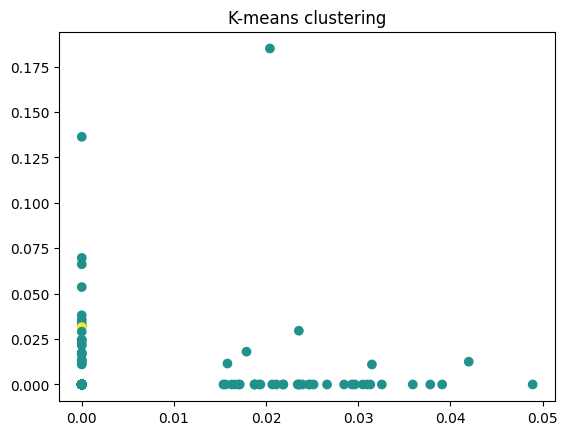

In [ ]:
X = df.values

import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(152)
k_means = KMeans(n_clusters = 5)
k_means = k_means.fit(X)

clusters = k_means.predict(X)

plt.scatter(X[:,0], X[:,1], c = clusters)
plt.title('K-means clustering')
plt.show()



# -- YOUR CODE HERE --

Выведите размеры кластеров. Полезной ли получилась кластеризация? Почему KMeans может выдать такой результат?

In [ ]:
# -- YOUR CODE HERE --
sizes = []
for i in set(clusters):
    sizes.append((i, list(clusters).count(i)))

print("Кластер | Размер")
for size in sizes:
    print(f"{size[0]} | {size[1]}")



Кластер | Размер
0 | 1
1 | 6
2 | 991
3 | 1
4 | 1


**Ответ:** можем заметить, что кластеризация не оказалась полезной, так у нас полное доминирование одного из классов, то есть практически все значения принадлежат одному классу, это можно объяснить тем, что KMeans стремится минимизировать внутрикластерные расстояния (сумму квадратов расстояний от точек до центроидов). В результате алгоритм будет отдавать приоритет крупному кластеру, чтобы уменьшить эту метрику, что приводит к игнорированию маленьких кластеров.
Большие кластеры сильно влияют на размещение центроидов, из-за чего маленькие кластеры могут быть некорректно определены или объединены с другими кластерами.

## Задание 3 (0.5 балла) Объяснение результатов

При кластеризации получилось $\geq 1$ кластера размера 1. Выведите исполнителей, которые составляют такие кластеры. Среди них должна быть группа The Beatles.

In [ ]:
# -- YOUR CODE HERE --
for i in range(5):
  if list(clusters).count(i) == 1:
    ind = np.where(clusters == i)
    for i in ind[0]:
      print(df.iloc[i].name)


enigma
the beatles
gunsnroses


Изучите данные, почему именно The Beatles выделяется?

Подсказка: посмотрите на долю пользователей, которые слушают каждого исполнителя, среднюю долю прослушивания.

In [ ]:
# -- YOUR CODE HERE --
# Вычисляем средние значения для каждой строки
row_means = np.mean(df, axis=1)


max_mean_row_index = np.argmax(row_means)



max_mean_row = df.iloc[max_mean_row_index].name

print("Максимальное среднее значение:", np.max(row_means))
print("Строка с максимальным средним значением:", max_mean_row)


Максимальное среднее значение: 0.01836897659205146
Строка с максимальным средним значением: the beatles


**Ответ:** Группа the beatles выделяется, так у нее самая большая доля прослушиваний среди всех пользователей.

## Задание 4 (0.5 балла) Улучшение кластеризации

Попытаемся избавиться от этой проблемы: нормализуйте данные при помощи `normalize`.

In [ ]:
from sklearn.preprocessing import normalize
norm_df = normalize(df)
norm_df = pd.DataFrame(norm_df,columns = df.columns, index = df.index)
norm_df1 = norm_df.copy() # используем в дальнейшем для визуализации
norm_df2 = norm_df.copy() # используем в дальнейшем для визуализации
norm_df

# -- YOUR CODE HERE --

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
the beatles,0.000000,0.000000,0.000000,0.0,0.012054,0.000000,0.0,0.0,0.025864,0.004880,...,0.000000,0.0,0.033554,0.010569,0.002199,0.004952,0.0,0.021302,0.0,0.000000
radiohead,0.009348,0.084688,0.000000,0.0,0.039505,0.002894,0.0,0.0,0.000000,0.008771,...,0.008120,0.0,0.000000,0.000000,0.005122,0.000000,0.0,0.000000,0.0,0.000000
deathcab for cutie,0.000000,0.017278,0.020144,0.0,0.024333,0.000000,0.0,0.0,0.000000,0.009391,...,0.085361,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.019622
coldplay,0.000000,0.000000,0.000000,0.0,0.011129,0.000000,0.0,0.0,0.000000,0.000000,...,0.144628,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
modest mouse,0.000000,0.000000,0.000000,0.0,0.010260,0.000000,0.0,0.0,0.000000,0.019597,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
michal w. smith,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
群星,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
agalloch,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
meshuggah,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


Примените KMeans с 5ю кластерами на преобразованной матрице, посмотрите на их размеры. Стало ли лучше? Может ли кластеризация быть полезной теперь?

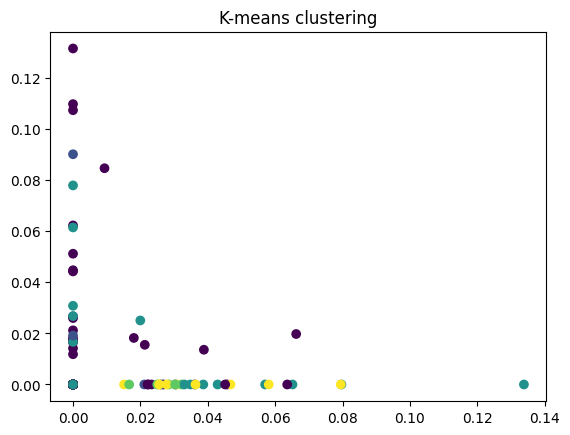

In [ ]:
# -- YOUR CODE HERE --

X = norm_df.values


np.random.seed(152)
k_means = KMeans(n_clusters = 5)
k_means = k_means.fit(X)

clusters = k_means.predict(X)

plt.scatter(X[:,0], X[:,1], c = clusters)
plt.title('K-means clustering')
plt.show()


In [ ]:
sizes = []
for i in set(clusters):
    sizes.append((i, list(clusters).count(i)))

print("Кластер | Размер")
for size in sizes:
    print(f"{size[0]} | {size[1]}")



Кластер | Размер
0 | 460
1 | 68
2 | 238
3 | 74
4 | 160


**Ответ:** нормализация явно помогла справиться с полной несбалансированностью наблюдений в кластерах, теперь количество наблюдений в каждом кластере стало достаточно большим, что уже может сделать кластеризацию полезной.


## Задание 5 (1 балл) Центроиды

Выведите для каждого кластера названия топ-10 исполнителей, ближайших к центроиду по косинусной мере. Проинтерпретируйте результат. Что можно сказать о смысле кластеров?

In [ ]:
from scipy.spatial.distance import cosine

km = KMeans(n_clusters=5,random_state=152)
km.fit(norm_df)
centroids = km.cluster_centers_


centroids_df = pd.DataFrame(centroids, columns=norm_df.columns)


# Находим топ-10 исполнителей, ближайших к центроиду по косинусной мере
top_artists_per_cluster = {}

for cluster_idx, centroid in enumerate(centroids):
    distances = norm_df.apply(lambda row: cosine(row, centroid), axis=1)
    closest_artists = distances.nsmallest(10).index
    top_artists_per_cluster[cluster_idx] = closest_artists.tolist()



print("Closest artists in each cluster:")
for cluster_idx, artists in top_artists_per_cluster.items():
    print(f"Cluster {cluster_idx + 1} is characterized by the following artists:")
    print(", ".join(artists))


Closest artists in each cluster:
Cluster 1 is characterized by the following artists:
radiohead, the arcade fire, sufjan stevens, belle and sebastian, the shins, the beatles, the pixies, animal collective, broken social scene, spoon
Cluster 2 is characterized by the following artists:
against me!, descendents, rancid, less than jake, big d and the kids table, streetlight manifesto, alkaline trio, nofx, the ramones, the bouncing souls
Cluster 3 is characterized by the following artists:
kelly clarkson, maroon5, coldplay, john mayer, nickelback, evril lavigne, ‌linkin park, the killers, evanescense, the fray
Cluster 4 is characterized by the following artists:
nas, jay-z, kanye west, lupe the gorilla, the roots featuring d'angelo, a tribe called quest, little brother, mos def, talib kweli, gangstarr
Cluster 5 is characterized by the following artists:
fall out boy, chiodos, brand new, saosin, taking back sunday, underoath, the used, all time low, cartel, paramore


**Ответ:** интпретация: кластеры представляют собой группы артистов, которые связаны общими жанровыми и стилистическими характеристиками. Каждая группа отражает определенные музыкальные предпочтения и вкусы слушателей. Но стоимт отметить, что пока данные кластеры не разделяют слушателей на узконаправленные предпочтения, тут все-таки пока что имеются общие очертания жанров.

## Задание 6 (1 балл) Визуализация

Хотелось бы как-то визуализировать полученную кластеризацию. Постройте точечные графики `plt.scatter` для нескольких пар признаков исполнителей, покрасив точки в цвета кластеров. Почему визуализации получились такими? Хорошо ли они отражают разделение на кластеры? Почему?

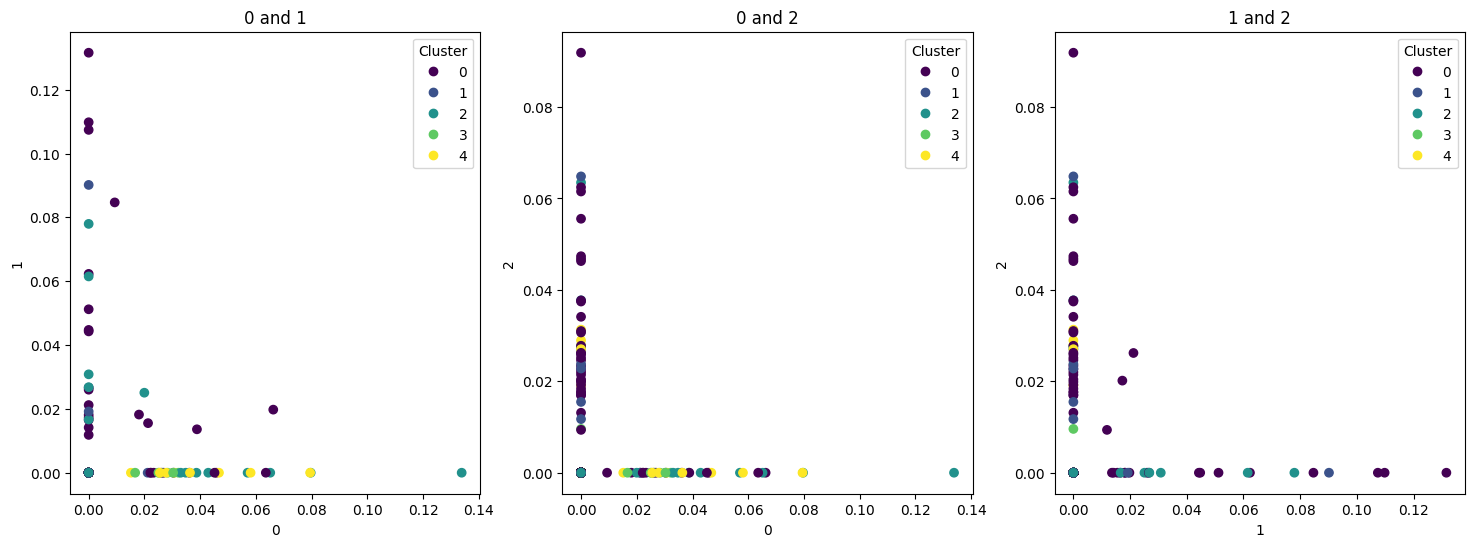

In [ ]:
import matplotlib.pyplot as plt


norm_df['Cluster'] = clusters

# Выбираем пары признаков (пользователей) для визуализации
pairs = [(0, 1), (0, 2), (1, 2)]


fig, axes = plt.subplots(1, len(pairs), figsize=(18, 6))

for i, (user1, user2) in enumerate(pairs):
    ax = axes[i]
    scatter = ax.scatter(norm_df[user1], norm_df[user2], c=norm_df['Cluster'], cmap='viridis')
    ax.set_xlabel(user1)
    ax.set_ylabel(user2)
    ax.set_title(f'{user1} and {user2}')
    ax.legend(*scatter.legend_elements(), title="Cluster")

plt.show()
# -- YOUR CODE HERE --

 **Ответ:** визуализации оказались не совсем качественными, в плане четкого разделения на кластеры, это можно объяснить тем, что распределение наших данных в основном представлено в виде фигур, похожих на прямоугольники, что затрудняет работу kmeans, так как он способен устанавливать закономерности, когда данные напоминаают очертания окружностей, то есть  кластеры имеют примерно одинаковый размер и форму (сферические кластеры одинакового радиуса)

Для визуализации данных высокой размерности существует метод t-SNE (стохастическое вложение соседей с t-распределением). Данный метод является нелинейным методом снижения размерности: каждый объект высокой размерности будет моделироваться объектов более низкой (например, 2) размерности таким образом, чтобы похожие объекты моделировались близкими, непохожие - далекими с большой вероятностью.

Примените `TSNE` из библиотеки `sklearn` и визуализируйте полученные объекты, покрасив их в цвета их кластеров

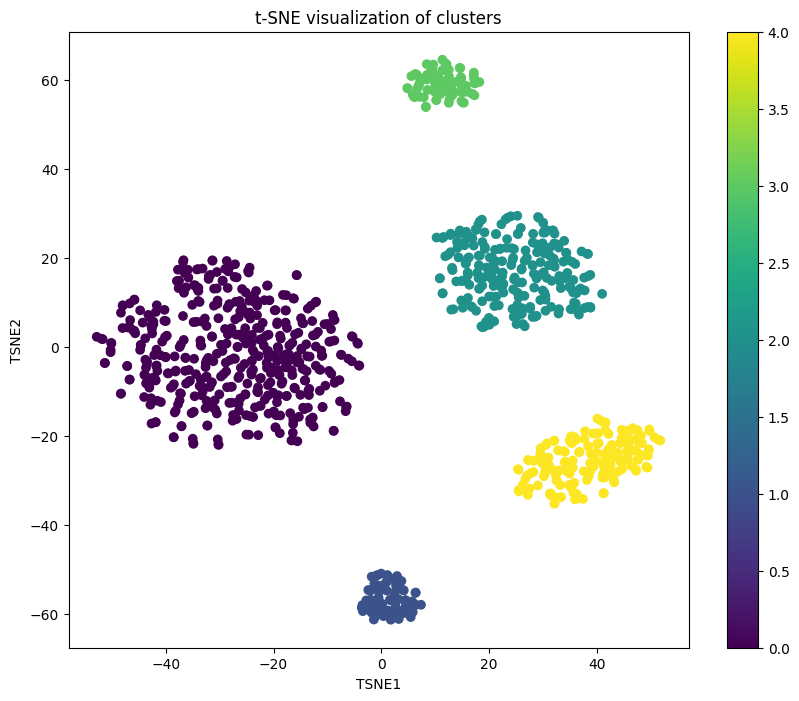

In [ ]:
from sklearn.manifold import TSNE
norm_df.columns = norm_df.columns.astype(str)

tsne = TSNE(n_components=2, random_state=152)
tsne_results = tsne.fit_transform(norm_df)

tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('t-SNE visualization of clusters')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()

# -- YOUR CODE HERE --

## Задание 7 (1 балл) Подбор гиперпараметров

Подберите оптимальное количество кластеров (максимум 100 кластеров) с использованием индекса Силуэта. Зафиксируйте `random_state=42`

In [ ]:
from sklearn.metrics import silhouette_score

best_k, best_score = None, -1
for k in range(2,100):
      k_means = KMeans(n_clusters = k, random_state=42)
      k_means = k_means.fit(norm_df1)
      clusters = k_means.predict(norm_df1)
      score = np.round(silhouette_score(X=norm_df1,
                              labels=clusters), 2)
      if score > best_score:
        best_score = score
        best_k = k
print('Best score {}, k = {}'.format(best_score, best_k))

Best score 0.02, k = 95


Выведите исполнителей, ближайших с центроидам (аналогично заданию 5). Как соотносятся результаты? Остался ли смысл кластеров прежним? Расскажите про смысл 1-2 интересных кластеров, если он изменился и кластеров слишком много, чтобы рассказать про все.

In [ ]:
# -- YOUR CODE HERE --
k_means = KMeans(n_clusters = best_k, random_state=42)
k_means = k_means.fit(norm_df1)
clusters = k_means.predict(norm_df1)

km = KMeans(n_clusters=best_k,random_state=42)
km.fit(norm_df1)
centroids = km.cluster_centers_


centroids_df = pd.DataFrame(centroids, columns=norm_df1.columns)


# Находим топ-10 исполнителей, ближайших к центроиду по косинусной мере
top_artists_per_cluster = {}

for cluster_idx, centroid in enumerate(centroids):
    distances = norm_df1.apply(lambda row: cosine(row, centroid), axis=1)
    closest_artists = distances.nsmallest(10).index
    top_artists_per_cluster[cluster_idx] = closest_artists.tolist()



print("Closest artists in each cluster:")
for cluster_idx, artists in top_artists_per_cluster.items():
    print(f"Cluster {cluster_idx + 1} is characterized by the following artists:")
    print(", ".join(artists))

Closest artists in each cluster:
Cluster 1 is characterized by the following artists:
circa survive, portugal. the man, cursive, citya and colour, the blood brothers, coheed and cambria, four year strong, owen, why?, manchester orchestra
Cluster 2 is characterized by the following artists:
the brian jonestown massacre, spiritualized®, black rebel motorcycle club, the dandy warhols, the verve, silver jews, pavement, the jesus and mary chain, velvet underground, sonic youth
Cluster 3 is characterized by the following artists:
squarepusher., autechre, amon tobin, boards of canada, aphex twin, prefuse 73, underworld, rjd2, burial, björk guğmunsdóttir
Cluster 4 is characterized by the following artists:
talib kweli, the roots featuring d'angelo, mos def, little brother, common, jurassic 5, cunninlynguists, lupe the gorilla, nas, a tribe called quest
Cluster 5 is characterized by the following artists:
mgmt, vampire weekend, tokyo police club, ratatat, kings of leon, the klaxons, justice, lo

**Ответ:** сравнивая с результатами кластеризации из задания 5, можно с уверенностью сказать, что кластеризация на 95 кластеров улучшила наши результаы, смысл каждого кластера стал более узок, то есть каждый кластер стал характеризоваться узконправлееностью жанра. Так, например, где-то присутсвуют реп исполнители, где-то классики, где-то хип-хоп, что нельзя было сказать про разбиение из задания 5. Проанализуем 52 кластер: этот кластер объединяет исполнителей, которые ассоциируются с жанрами пост-гранжа, альтернативного метала и нью-метала. Эти жанры стали особенно популярными в конце 1990-х и 2000-х годах. Музыка этих исполнителей часто характеризуется сочетанием тяжёлых гитарных риффов, эмоциональных вокальных линий и тематики, связанной с личными и эмоциональными переживаниями.

Сделайте t-SNE визуализацию полученной кластеризации.

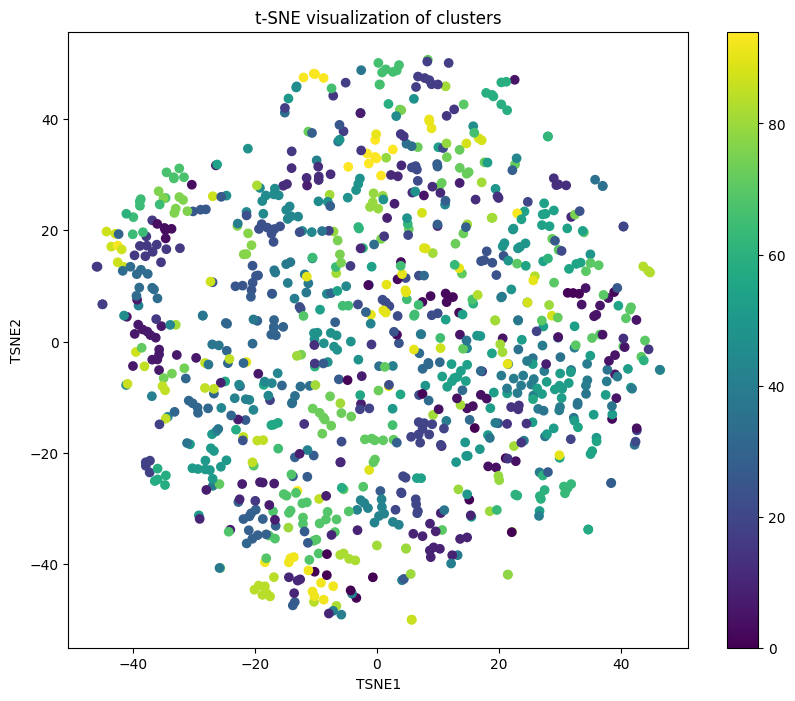

In [ ]:
# -- YOUR CODE HERE --

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(norm_df1)

# Создание DataFrame с результатами t-SNE
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

# Визуализация
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c=tsne_df['Cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title('t-SNE visualization of clusters')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.show()


Если кластеров получилось слишком много и визуально цвета плохо отличаются, покрасьте только какой-нибудь интересный кластер из задания выше (`c = (labels == i)`). Хорошо ли этот кластер отражается в визуализации?

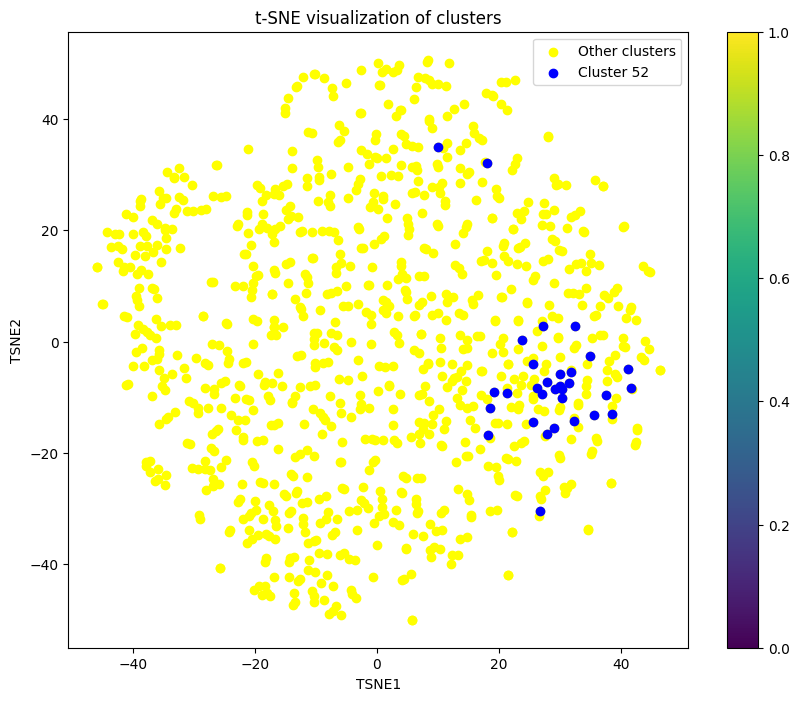

In [ ]:
# -- YOUR CODE HERE --

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(norm_df2)


tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['Cluster'] = clusters

# Выбор кластер 52)))
interesting_cluster = 52
tsne_df_interesting = tsne_df[tsne_df['Cluster'] == interesting_cluster]

# Визуализация интересного кластера
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_df['TSNE1'], tsne_df['TSNE2'], c='yellow', label='Other clusters')
scatter_interesting = plt.scatter(tsne_df_interesting['TSNE1'], tsne_df_interesting['TSNE2'], c='blue', label=f'Cluster {interesting_cluster}')
plt.colorbar(scatter_interesting)
plt.title('t-SNE visualization of clusters')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.legend()
plt.show()

**Ответ:** можно, сказать, что данный кластер достаточно хорошо отразился в визуализации, хоть и прусутсвуют некоторые выбросы

